In [149]:
import os
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

In [150]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [151]:
print(device)

cuda:0


In [4]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) # input dim (3) -> hidden dim (LSTM)
        self.fc = nn.Linear(hidden_dim, latent_dim) # hidden dim -> latent dim (z) (FC layer)

    def forward(self, x):
        # x: [B, T, C]
        h, _ = self.lstm(x)  # h: [B, T, H]
        h_last = h[:, -1, :]  # Last hidden state (sequence summary)
        z = self.fc(h_last)  # [B, latent_dim]
        return z

In [5]:
class LSTMDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, seq_len=10, num_layers=1):
        super(LSTMDecoder, self).__init__()
        self.seq_len = seq_len
        
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim) # latent dim -> hidden dim (FC layer)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True) #hidden dim -> hidden dim (LSTM)
        self.fc = nn.Linear(hidden_dim, output_dim) # hidden dim -> output dim (3) (FC layer)

    def forward(self, z):
        # z: [B, latent_dim]
        h0 = self.latent_to_hidden(z)  # latent vector [B, H] to hidden state
        h0_seq = h0.unsqueeze(1).repeat(1, self.seq_len, 1)  # Copy for the sequence length (T) [B, T, H]
        h_seq, _ = self.lstm(h0_seq) # Inference for 1 step (Make sequence)
        out = self.fc(h_seq)  # Recover for 3dim var with each time step output [B, T, output_dim]
        return out

In [6]:
class USAD_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_len=10):
        super(USAD_LSTM, self).__init__()
        self.encoder = LSTMEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder1 = LSTMDecoder(latent_dim, hidden_dim, input_dim, seq_len)
        self.decoder2 = LSTMDecoder(latent_dim, hidden_dim, input_dim, seq_len)

    def forward(self, x):
        z = self.encoder(x)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        return w1, w2, z

In [7]:
def data_norm(df,mode='train',scaler=''):
    """
    Normalize the data.
    df(dataframe) : Input
    return tmp(dataframe), scaler : normalized dataframe
    """
    columns = df.columns[1:]

    tmp = df.copy()
    if mode == 'train':
        # Normalize
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(tmp[columns])
    elif mode=='test':
        scaler = scaler
        scaled = scaler.transform(tmp[columns])
    # Insert the normalized value to the original frame
    tmp[columns] = scaled

    return tmp, scaler

In [8]:
def inverse_norm(tensor, scaler):
    """
    tensor: [N, T, C] → numpy 배열로 변환 후 역정규화 수행
    """
    shape = tensor.shape
    data = tensor.reshape(-1, shape[-1])
    inv = scaler.inverse_transform(data)
    return inv.reshape(shape)

In [9]:
def create_sequences(df, seq_len=10):
    """
    날짜 포함된 시퀀스 생성 함수
    df: ['date', 'rn', 'vl', 'wl'] 포함된 DataFrame
    반환: (data_seq, date_seq)
        - data_seq: torch.Tensor [N, seq_len, 3]
        - date_seq: List[List[str]] [N, seq_len]
    """
    cols = df.columns[1:]  # 날짜 제외한 나머지 변수
    values = df[cols].values.astype(np.float32)
    dates = df['dates'].values  # 문자열 형태로 추출

    data_sequences = []
    date_sequences = []

    for i in range(len(df) - seq_len + 1):
        data_seq = values[i:i+seq_len]
        date_seq = dates[i:i+seq_len]
        data_sequences.append(data_seq)
        date_sequences.append(date_seq)

    return torch.tensor(np.stack(data_sequences)), date_sequences

In [10]:
def create_combined_sequences(train_dfs, test_dfs, seq_len=120):
    """
    train_dfs(List): Input
    test_dfs(List): Input
    return train_seq(arr), val_seq(arr): train/val sliding window sequences tensor
    """
    
    train_seqs = []
    test_seqs = []
    train_dates = []
    test_dates = []

    for train, test in zip(train_dfs, test_dfs):
        train_seq, train_date = create_sequences(train, seq_len=seq_len)
        test_seq, test_date = create_sequences(test, seq_len=seq_len)
        train_seqs.append(train_seq)
        train_dates.extend(train_date)
        test_seqs.append(test_seq)
        test_dates.extend(test_date)
    
    return torch.cat(train_seqs, dim=0), torch.cat(test_seqs, dim=0), train_dates, test_dates

In [11]:
def create_dataloaders(train_seq, val_seq, batch_size=64, shuffle=True):
    """
    Create the dataloader.
    train_seq(tensor)
    val_seq(tensor)
    return train_loader, val_loader
    """
    # Make TensorDataset 생성 (Same input and output)
    train_dataset = TensorDataset(train_seq, train_seq) # X, y
    val_dataset = TensorDataset(val_seq, train_seq) # X, y

    # Make DataLoader (Load X,y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle) 
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [12]:
def train_usad_lstm(model, train_loader, device='cuda', num_epochs=30, sav_path = '', alpha=0.5, beta=0.5, lr = 1e-4):
    """
    Train the model
    """
    # Initialize the model with device (CPU, GPU)
    model = model.to(device)

    # Use the ADAM optimizer
    optimizer1 = optim.Adam(list(model.encoder.parameters()) + list(model.decoder1.parameters()), lr=lr)
    optimizer2 = optim.Adam(list(model.encoder.parameters()) + list(model.decoder2.parameters()), lr=lr)
    # Loss function
    criterion = nn.MSELoss()

    best_loss = float('inf')  # 가장 작은 loss 추적용
    save_path = sav_path  # 저장할 폴더
    os.makedirs(save_path, exist_ok=True)

    loss1_list = []
    loss2_list = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss1, epoch_loss2 = 0.0, 0.0

        for x, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
            x = x.to(device)
            # Phase 1
            # Initialize the gradient
            optimizer1.zero_grad()
            # Ouput w1 (_ : w2, z)
            w1, _, _ = model(x)
            # Calculate Loss function 1
            loss1 = alpha * criterion(w1, x)
            # Back-propagation
            loss1.backward()
            # Parameter update with the gradient
            optimizer1.step()
            epoch_loss1 += loss1.item()

            # Phase 2
            optimizer2.zero_grad()
            # Ouput w1 (_ : w1, z)
            _, w2, _ = model(x)
            # Calculate Loss function 2
            loss2 = beta * criterion(w2, x)
            # Back-propagation
            loss2.backward()
            # Parameter update with the gradient
            optimizer2.step()
            epoch_loss2 += loss2.item()

        avg_loss1 = epoch_loss1 / len(train_loader)
        avg_loss2 = epoch_loss2 / len(train_loader)

        loss1_list.append(avg_loss1)
        loss2_list.append(avg_loss2)

        print(f"[Epoch {epoch:03d}] Train Loss1: {epoch_loss1:.6f} | Train Loss2: {epoch_loss2:.6f}")

        # save weights file
        if avg_loss1 < best_loss:
            best_loss = avg_loss1
            torch.save(model.state_dict(), os.path.join(save_path, 'USAD_best.pth'))
            print(f"[Epoch {epoch}] 모델 저장됨: val_loss = {avg_loss1:.6f}")

    plt.figure(figsize=(8, 5))
    plt.plot(loss1_list, label='Loss1 (Encoder+Decoder1)')
    plt.plot(loss2_list, label='Loss2 (Encoder+Decoder2)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(sav_path, f'USAD_{seq_len}_train_loss_plot.png'))
    plt.close()
    print(f"[Saved] Training loss plot saved at {os.path.join(sav_path, f'USAD_{seq_len}_train_loss_plot.png')}")


In [13]:
def test_usad_lstm(model, test_loader, device='cuda'):
    model.eval()
    model = model.to(device)
    criterion = nn.MSELoss()

    total_loss1, total_loss2 = 0.0, 0.0
    all_x, all_w2 = [], []

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            w1, w2, _ = model(x)

            loss1 = criterion(w1, x).item()
            loss2 = criterion(w2, x).item()
            total_loss1 += loss1
            total_loss2 += loss2

            all_x.append(x.cpu())
            all_w2.append(w2.cpu())

    print(f"[Test] Loss1: {total_loss1:.6f} | Loss2: {total_loss2:.6f}")
    
    # 시계열 전체 보정 결과 반환
    all_x = torch.cat(all_x, dim=0)    # [N, 60, 3]
    all_w2 = torch.cat(all_w2, dim=0)  # [N, 60, 3]
    return all_x, all_w2


In [14]:
def compute_anomaly_scores(x_seq, w2_seq, mode='vl'):
    """
    x_seq, w2_seq: [N, T, 3]
    mode: 'vl' → 관로수위만 사용 / 'all' → 전체 변수 평균
    반환: [N] shape의 이상치 점수 벡터
    """
    # 관로수위 (index 2)만 비교
    errors = (x_seq - w2_seq) ** 2  # [N, T]
    scores = errors.mean(dim=1)  # 시퀀스별 평균 MSE → [N]
    return errors.numpy(), scores.numpy()

In [15]:
def determine_threshold(scores, method='iqr', k=3):
    """
    scores: 이상치 점수 벡터 (numpy)
    method: 'iqr', 'mean_std', 'percentile'
    """
    if method == 'iqr':
        q1 = np.percentile(scores, 25)
        q3 = np.percentile(scores, 75)
        iqr = q3 - q1
        threshold = q3 + 1.5 * iqr

    elif method == 'mean_std':
        mean = np.mean(scores)
        std = np.std(scores)
        threshold = mean + k * std

    elif method == 'percentile':
        threshold = np.percentile(scores, 95)

    else:
        raise ValueError("지원하지 않는 방식입니다.")

    return threshold

In [16]:
def plot_corrected_vs_original(original_seq, corrected_seq, input_seq, sav_path = '', sample_idx=0):
    """
    단일 시퀀스 비교 시각화 (60분간)
    """
    orig = original_seq[sample_idx]#.numpy()  # 관로 수위
    corr = corrected_seq[sample_idx]#.numpy()
    inputs = input_seq[sample_idx]
    if not os.path.isdir(sav_path):
        os.makedirs(sav_path)
    plt.figure(figsize=(12, 4))
    plt.plot(orig, label='Original (vl)', marker='o')
    plt.plot(corr, label='Corrected (w2)', marker='x')
    plt.plot(inputs, label='Input', marker='+')
    plt.title(f'Sample {sample_idx}: Sewer Level Original  vs Corrected')
    plt.xlabel('Time index (minute)')
    plt.ylabel('Sewer Level')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{sav_path}/{sample_idx}.png')

In [17]:
def plot_anomalies_on_timeseries(original_seq, anomaly_flags, sav_path='', sample_idx=0):
    """
    Plot(scatter) the anomlay detection results on the graph
    original_seq : [N, T] or [N, T, 3]
    anomaly_flags : [N, T] (bool array)
    sample_idx(int)
    """
    vl = original_seq[sample_idx]  # shape: [T]
    flags = anomaly_flags[sample_idx]  # shape: [T], bool

    if not os.path.isdir(sav_path):
        os.makedirs(sav_path)

    plt.figure(figsize=(12, 4))
    plt.plot(vl, label='Sewer Level (vl)', color='blue')

    # Scatter the anomaly
    if flags.any():
        plt.scatter(np.where(flags)[0], vl[flags], color='red', label='Detected Anomaly', zorder=3)

    plt.title(f'Sample {sample_idx} - Detected {flags.sum()} Anomalies')
    plt.xlabel('Time index (minute)')
    plt.ylabel('Sewer Level')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.savefig(f'{sav_path}/{sample_idx}_anomaly.png')
    plt.show()

In [103]:
def summarize_pointwise_anomaly_statistics(errors, anomaly_flags):
    """
    시점 단위 이상치 탐지 통계 요약
    errors: np.ndarray, shape [N] or [T] - pointwise 오차 벡터 (예: MAE or MSE)
    anomaly_flags: np.ndarray, shape [N] or [T] - 이상치 여부 (bool 배열)

    출력:
        - 총 시점 수
        - 이상치 시점 수 및 비율
        - 이상치 평균 오차
        - 정상값 평균 오차
    """
    total = len(errors)
    num_anomalies = np.sum(anomaly_flags)
    num_normals = total - num_anomalies

    mean_anomaly_error = np.mean(errors[anomaly_flags]) if num_anomalies > 0 else 0.0
    mean_normal_error = np.mean(errors[~anomaly_flags]) if num_normals > 0 else 0.0

    print("📊 시점 단위 이상치 탐지 통계 요약")
    print(f"- 총 시점 수: {total}")
    print(f"- 이상치 시점 수: {num_anomalies}")
    print(f"- 이상치 비율: {100.0 * num_anomalies / total:.2f}%")
    print(f"- 이상치 평균 오차: {mean_anomaly_error:.4f}")
    print(f"- 정상값 평균 오차: {mean_normal_error:.4f}")


In [19]:
def reconstruct_series_from_sequences(seq_array):
    """
    Merge the predicted sequences for all time step data
    seq_array: [N, T] numpy or tensor
    반환: [N+T-1] 배열 (시점 단위 결과)
    """
    # seq_array = seq_array.numpy()
    N, T = seq_array.shape
    summed = np.zeros(N + T - 1)
    count = np.zeros(N + T - 1)

    for i in range(N):
        summed[i:i+T] += seq_array[i]
        count[i:i+T] += 1

    return summed / count

## Load dataset (Several dataframes)

In [20]:
region = {0 : 'gwangjoo', 1 : 'changwon', 2 : 'pohang'}
fname = {0 : '2920010001045020', 1 : '4812110001018020', 2 : ''}
r_cd = 0

batch_size = 256
seq_len = 120
input_dim=3
hidden_dim=24
latent_dim=16

epochs = 100

data_dir = './trainset/sewer/'
# 파일 경로 정렬
train_paths = sorted(glob.glob(os.path.join(data_dir, 'train*.csv')))
test_paths = sorted(glob.glob(os.path.join(data_dir, 'org*.csv')))

# 'flag' 열 제외하고 불러오기
usecols = ['dates', 'rn', 'vl', 'wl']  # 필요한 컬럼만 명시

train_dfs = [pd.read_csv(path, encoding='cp949', usecols=usecols) for path in train_paths]
test_dfs = [pd.read_csv(path, encoding='cp949', usecols=usecols) for path in test_paths]


## Check NaNs

In [21]:
# 각 컬럼별 NaN 개수 누적용 (Series 초기화)
train_null = pd.Series(0, index=train_dfs[0].columns)
test_null = pd.Series(0, index=test_dfs[0].columns)

for train, test in zip(train_dfs, test_dfs):
    train_null += train.isnull().sum()
    test_null += test.isnull().sum()

print('Train set NaN 개수 (컬럼별):\n', train_null)
print('Test set NaN 개수 (컬럼별):\n', test_null)

# 전체 NaN 총합 출력
print(f"\nTrain set 전체 NaN 수: {train_null.sum()}")
print(f"Test set 전체 NaN 수: {test_null.sum()}")

Train set NaN 개수 (컬럼별):
 dates    0
rn       0
vl       0
wl       0
dtype: int64
Test set NaN 개수 (컬럼별):
 dates       0
rn          0
vl       3826
wl          0
dtype: int64

Train set 전체 NaN 수: 0
Test set 전체 NaN 수: 3826


## Data normalization (rain value, sewer level(vl), river level)

In [22]:
train_norm_dfs = []
test_norm_dfs = []
_, train_scaler = data_norm(pd.concat(train_dfs))

for train, test in zip(train_dfs, test_dfs):
    test.fillna(0.0, inplace=True)
    
    train_norm, _ = data_norm(train, scaler = train_scaler)
    test_norm, _ = data_norm(test, mode='test',scaler=train_scaler)
    
    test_norm['vl'] = test_norm['vl'].clip(lower= 0.0)
    
    train_norm_dfs.append(train_norm)
    test_norm_dfs.append(test_norm)

In [23]:
print('▶ Train set')
tmp_orig = pd.concat(train_dfs)
tmp_norm = pd.concat(train_norm_dfs)

print('Rain (rn) - Original min/max:', tmp_orig['rn'].min(), tmp_orig['rn'].max())
print('Rain (rn) - Normalized min/max:', tmp_norm['rn'].min(), tmp_norm['rn'].max())

print('Sewer level (vl) - Original min/max:', tmp_orig['vl'].min(), tmp_orig['vl'].max())
print('Sewer level (vl) - Normalized min/max:', tmp_norm['vl'].min(), tmp_norm['vl'].max())

print('River level (wl) - Original min/max:', tmp_orig['wl'].min(), tmp_orig['wl'].max())
print('River level (wl) - Normalized min/max:', tmp_norm['wl'].min(), tmp_norm['wl'].max())

print('\n▶ Test set')
tmp_test_orig = pd.concat(test_dfs)
tmp_test_norm = pd.concat(test_norm_dfs)

print('Test set Nan count:\n', tmp_test_orig.isnull().sum())

print('Rain (rn) - Original min/max:', tmp_test_orig['rn'].min(), tmp_test_orig['rn'].max())
print('Rain (rn) - Normalized min/max:', tmp_test_norm['rn'].min(), tmp_test_norm['rn'].max())

print('Sewer level (vl) - Original min/max:', tmp_test_orig['vl'].min(), tmp_test_orig['vl'].max())
print('Sewer level (vl) - Normalized min/max:', tmp_test_norm['vl'].min(), tmp_test_norm['vl'].max())

print('River level (wl) - Original min/max:', tmp_test_orig['wl'].min(), tmp_test_orig['wl'].max())
print('River level (wl) - Normalized min/max:', tmp_test_norm['wl'].min(), tmp_test_norm['wl'].max())


▶ Train set
Rain (rn) - Original min/max: 0.0 357.5
Rain (rn) - Normalized min/max: 0.0 1.0
Sewer level (vl) - Original min/max: 14.0 133.0
Sewer level (vl) - Normalized min/max: 0.0 1.0
River level (wl) - Original min/max: 0.93 5.93
River level (wl) - Normalized min/max: 0.0 1.0

▶ Test set
Test set Nan count:
 dates    0
rn       0
vl       0
wl       0
dtype: int64
Rain (rn) - Original min/max: 0.0 357.5
Rain (rn) - Normalized min/max: 0.0 1.0
Sewer level (vl) - Original min/max: 0.0 133.0
Sewer level (vl) - Normalized min/max: 0.0 1.0
River level (wl) - Original min/max: 0.93 5.93
River level (wl) - Normalized min/max: 0.0 0.9999999999999999


## Make dataset for the sequence data

In [24]:
train_seq, val_seq, train_date, test_date = create_combined_sequences(train_norm_dfs, test_norm_dfs, seq_len=seq_len)

print("Train shape:", train_seq.shape)  # (N_train, 60, 3)
print("Val shape:", val_seq.shape)      # (N_val, 60, 3)

Train shape: torch.Size([791760, 120, 3])
Val shape: torch.Size([791760, 120, 3])


In [25]:
train_date = np.stack(train_date)
test_date = np.stack(test_date)

## Initialize the model

In [26]:
model = USAD_LSTM(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, seq_len=seq_len)
example = torch.randn((batch_size,seq_len, input_dim)) 
w1, w2, z = model(example)

print(w1.shape)  # torch.Size([32, 10, 3])
print(w2.shape)  # torch.Size([32, 10, 3])

torch.Size([256, 120, 3])
torch.Size([256, 120, 3])


In [27]:
summary(model, input_size=(example.shape)) 

Layer (type:depth-idx)                   Output Shape              Param #
USAD_LSTM                                [256, 120, 3]             --
├─LSTMEncoder: 1-1                       [256, 16]                 --
│    └─LSTM: 2-1                         [256, 120, 24]            2,784
│    └─Linear: 2-2                       [256, 16]                 400
├─LSTMDecoder: 1-2                       [256, 120, 3]             --
│    └─Linear: 2-3                       [256, 24]                 408
│    └─LSTM: 2-4                         [256, 120, 24]            4,800
│    └─Linear: 2-5                       [256, 120, 3]             75
├─LSTMDecoder: 1-3                       [256, 120, 3]             --
│    └─Linear: 2-6                       [256, 24]                 408
│    └─LSTM: 2-7                         [256, 120, 24]            4,800
│    └─Linear: 2-8                       [256, 120, 3]             75
Total params: 13,750
Trainable params: 13,750
Non-trainable params: 0
Tot

## Create dataloader

In [28]:
# Create the data loader to load the dataset
train_loader, val_loader = create_dataloaders(train_seq, val_seq, batch_size=batch_size)

# Check the dataset shape
for x, y in train_loader:
    print(x.shape)  
    print(y.shape)  
    break


torch.Size([256, 120, 3])
torch.Size([256, 120, 3])


## Training

In [29]:
# Training Start
train_usad_lstm(model, train_loader, device=device, num_epochs=epochs,sav_path=f'./sav/USAD_{seq_len}_rn_vl_wl_gc/')


Epoch 1/100: 100%|██████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 247.00it/s]


[Epoch 001] Train Loss1: 2.061063 | Train Loss2: 3.087038
[Epoch 1] 모델 저장됨: val_loss = 0.000666


Epoch 2/100: 100%|██████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 224.63it/s]


[Epoch 002] Train Loss1: 0.454084 | Train Loss2: 0.462343
[Epoch 2] 모델 저장됨: val_loss = 0.000147


Epoch 3/100: 100%|██████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 249.83it/s]


[Epoch 003] Train Loss1: 0.382285 | Train Loss2: 0.369441
[Epoch 3] 모델 저장됨: val_loss = 0.000124


Epoch 4/100: 100%|██████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 245.13it/s]


[Epoch 004] Train Loss1: 0.352171 | Train Loss2: 0.325104
[Epoch 4] 모델 저장됨: val_loss = 0.000114


Epoch 5/100: 100%|██████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 233.87it/s]


[Epoch 005] Train Loss1: 0.333906 | Train Loss2: 0.306549
[Epoch 5] 모델 저장됨: val_loss = 0.000108


Epoch 6/100: 100%|██████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 236.15it/s]


[Epoch 006] Train Loss1: 0.322155 | Train Loss2: 0.296194
[Epoch 6] 모델 저장됨: val_loss = 0.000104


Epoch 7/100: 100%|██████████████████████████████████████████████████████| 3093/3093 [00:11<00:00, 260.46it/s]


[Epoch 007] Train Loss1: 0.314047 | Train Loss2: 0.290279
[Epoch 7] 모델 저장됨: val_loss = 0.000102


Epoch 8/100: 100%|██████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 250.53it/s]


[Epoch 008] Train Loss1: 0.306635 | Train Loss2: 0.285586
[Epoch 8] 모델 저장됨: val_loss = 0.000099


Epoch 9/100: 100%|██████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 256.69it/s]


[Epoch 009] Train Loss1: 0.300715 | Train Loss2: 0.281564
[Epoch 9] 모델 저장됨: val_loss = 0.000097


Epoch 10/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 243.43it/s]


[Epoch 010] Train Loss1: 0.296486 | Train Loss2: 0.278432
[Epoch 10] 모델 저장됨: val_loss = 0.000096


Epoch 11/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 247.36it/s]


[Epoch 011] Train Loss1: 0.291388 | Train Loss2: 0.274887
[Epoch 11] 모델 저장됨: val_loss = 0.000094


Epoch 12/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 254.96it/s]


[Epoch 012] Train Loss1: 0.287106 | Train Loss2: 0.271997
[Epoch 12] 모델 저장됨: val_loss = 0.000093


Epoch 13/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:11<00:00, 259.23it/s]


[Epoch 013] Train Loss1: 0.284508 | Train Loss2: 0.268357
[Epoch 13] 모델 저장됨: val_loss = 0.000092


Epoch 14/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 240.06it/s]


[Epoch 014] Train Loss1: 0.282336 | Train Loss2: 0.266422
[Epoch 14] 모델 저장됨: val_loss = 0.000091


Epoch 15/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 237.95it/s]


[Epoch 015] Train Loss1: 0.278049 | Train Loss2: 0.263486
[Epoch 15] 모델 저장됨: val_loss = 0.000090


Epoch 16/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 245.91it/s]


[Epoch 016] Train Loss1: 0.277070 | Train Loss2: 0.261764
[Epoch 16] 모델 저장됨: val_loss = 0.000090


Epoch 17/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 238.54it/s]


[Epoch 017] Train Loss1: 0.273836 | Train Loss2: 0.260257
[Epoch 17] 모델 저장됨: val_loss = 0.000089


Epoch 18/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 240.10it/s]


[Epoch 018] Train Loss1: 0.271473 | Train Loss2: 0.257795
[Epoch 18] 모델 저장됨: val_loss = 0.000088


Epoch 19/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:11<00:00, 260.22it/s]


[Epoch 019] Train Loss1: 0.269868 | Train Loss2: 0.257020
[Epoch 19] 모델 저장됨: val_loss = 0.000087


Epoch 20/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:11<00:00, 264.15it/s]


[Epoch 020] Train Loss1: 0.267686 | Train Loss2: 0.255400
[Epoch 20] 모델 저장됨: val_loss = 0.000087


Epoch 21/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:11<00:00, 259.94it/s]


[Epoch 021] Train Loss1: 0.265587 | Train Loss2: 0.254863
[Epoch 21] 모델 저장됨: val_loss = 0.000086


Epoch 22/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 244.58it/s]


[Epoch 022] Train Loss1: 0.262336 | Train Loss2: 0.252397
[Epoch 22] 모델 저장됨: val_loss = 0.000085


Epoch 23/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 237.02it/s]


[Epoch 023] Train Loss1: 0.258817 | Train Loss2: 0.251348
[Epoch 23] 모델 저장됨: val_loss = 0.000084


Epoch 24/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:11<00:00, 262.60it/s]


[Epoch 024] Train Loss1: 0.254546 | Train Loss2: 0.248831
[Epoch 24] 모델 저장됨: val_loss = 0.000082


Epoch 25/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 254.41it/s]


[Epoch 025] Train Loss1: 0.253243 | Train Loss2: 0.247287
[Epoch 25] 모델 저장됨: val_loss = 0.000082


Epoch 26/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 238.47it/s]


[Epoch 026] Train Loss1: 0.248724 | Train Loss2: 0.245965
[Epoch 26] 모델 저장됨: val_loss = 0.000080


Epoch 27/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 237.19it/s]


[Epoch 027] Train Loss1: 0.245237 | Train Loss2: 0.243888
[Epoch 27] 모델 저장됨: val_loss = 0.000079


Epoch 28/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 241.45it/s]


[Epoch 028] Train Loss1: 0.243422 | Train Loss2: 0.241685
[Epoch 28] 모델 저장됨: val_loss = 0.000079


Epoch 29/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 249.60it/s]


[Epoch 029] Train Loss1: 0.240468 | Train Loss2: 0.239468
[Epoch 29] 모델 저장됨: val_loss = 0.000078


Epoch 30/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 245.01it/s]


[Epoch 030] Train Loss1: 0.237402 | Train Loss2: 0.237868
[Epoch 30] 모델 저장됨: val_loss = 0.000077


Epoch 31/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:11<00:00, 261.85it/s]


[Epoch 031] Train Loss1: 0.233458 | Train Loss2: 0.235467
[Epoch 31] 모델 저장됨: val_loss = 0.000075


Epoch 32/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:11<00:00, 262.81it/s]


[Epoch 032] Train Loss1: 0.230792 | Train Loss2: 0.234082
[Epoch 32] 모델 저장됨: val_loss = 0.000075


Epoch 33/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 240.73it/s]


[Epoch 033] Train Loss1: 0.227226 | Train Loss2: 0.231765
[Epoch 33] 모델 저장됨: val_loss = 0.000073


Epoch 34/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 241.13it/s]


[Epoch 034] Train Loss1: 0.224925 | Train Loss2: 0.229986
[Epoch 34] 모델 저장됨: val_loss = 0.000073


Epoch 35/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 246.35it/s]


[Epoch 035] Train Loss1: 0.222368 | Train Loss2: 0.227002
[Epoch 35] 모델 저장됨: val_loss = 0.000072


Epoch 36/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 239.33it/s]


[Epoch 036] Train Loss1: 0.219341 | Train Loss2: 0.223839
[Epoch 36] 모델 저장됨: val_loss = 0.000071


Epoch 37/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:11<00:00, 258.07it/s]


[Epoch 037] Train Loss1: 0.217094 | Train Loss2: 0.220769
[Epoch 37] 모델 저장됨: val_loss = 0.000070


Epoch 38/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:11<00:00, 265.64it/s]


[Epoch 038] Train Loss1: 0.216331 | Train Loss2: 0.219826
[Epoch 38] 모델 저장됨: val_loss = 0.000070


Epoch 39/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 250.11it/s]


[Epoch 039] Train Loss1: 0.209171 | Train Loss2: 0.217697
[Epoch 39] 모델 저장됨: val_loss = 0.000068


Epoch 40/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 239.90it/s]


[Epoch 040] Train Loss1: 0.208624 | Train Loss2: 0.217031
[Epoch 40] 모델 저장됨: val_loss = 0.000067


Epoch 41/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 238.86it/s]


[Epoch 041] Train Loss1: 0.208796 | Train Loss2: 0.214803


Epoch 42/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 225.72it/s]


[Epoch 042] Train Loss1: 0.207464 | Train Loss2: 0.212086
[Epoch 42] 모델 저장됨: val_loss = 0.000067


Epoch 43/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 229.76it/s]


[Epoch 043] Train Loss1: 0.205727 | Train Loss2: 0.208764
[Epoch 43] 모델 저장됨: val_loss = 0.000067


Epoch 44/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 243.53it/s]


[Epoch 044] Train Loss1: 0.205199 | Train Loss2: 0.208039
[Epoch 44] 모델 저장됨: val_loss = 0.000066


Epoch 45/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:11<00:00, 260.74it/s]


[Epoch 045] Train Loss1: 0.203413 | Train Loss2: 0.206069
[Epoch 45] 모델 저장됨: val_loss = 0.000066


Epoch 46/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 234.43it/s]


[Epoch 046] Train Loss1: 0.202000 | Train Loss2: 0.203886
[Epoch 46] 모델 저장됨: val_loss = 0.000065


Epoch 47/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 244.07it/s]


[Epoch 047] Train Loss1: 0.199971 | Train Loss2: 0.202389
[Epoch 47] 모델 저장됨: val_loss = 0.000065


Epoch 48/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 237.87it/s]


[Epoch 048] Train Loss1: 0.199053 | Train Loss2: 0.201242
[Epoch 48] 모델 저장됨: val_loss = 0.000064


Epoch 49/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 238.41it/s]


[Epoch 049] Train Loss1: 0.197120 | Train Loss2: 0.199618
[Epoch 49] 모델 저장됨: val_loss = 0.000064


Epoch 50/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 247.75it/s]


[Epoch 050] Train Loss1: 0.196234 | Train Loss2: 0.198841
[Epoch 50] 모델 저장됨: val_loss = 0.000063


Epoch 51/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 232.08it/s]


[Epoch 051] Train Loss1: 0.194686 | Train Loss2: 0.197228
[Epoch 51] 모델 저장됨: val_loss = 0.000063


Epoch 52/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 239.01it/s]


[Epoch 052] Train Loss1: 0.197700 | Train Loss2: 0.194154


Epoch 53/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 239.41it/s]


[Epoch 053] Train Loss1: 0.192789 | Train Loss2: 0.192214
[Epoch 53] 모델 저장됨: val_loss = 0.000062


Epoch 54/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 239.99it/s]


[Epoch 054] Train Loss1: 0.191984 | Train Loss2: 0.192228
[Epoch 54] 모델 저장됨: val_loss = 0.000062


Epoch 55/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 237.35it/s]


[Epoch 055] Train Loss1: 0.190623 | Train Loss2: 0.190398
[Epoch 55] 모델 저장됨: val_loss = 0.000062


Epoch 56/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 231.53it/s]


[Epoch 056] Train Loss1: 0.189857 | Train Loss2: 0.190535
[Epoch 56] 모델 저장됨: val_loss = 0.000061


Epoch 57/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 232.83it/s]


[Epoch 057] Train Loss1: 0.187060 | Train Loss2: 0.187793
[Epoch 57] 모델 저장됨: val_loss = 0.000060


Epoch 58/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 257.30it/s]


[Epoch 058] Train Loss1: 0.188257 | Train Loss2: 0.187966


Epoch 59/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 237.61it/s]


[Epoch 059] Train Loss1: 0.185463 | Train Loss2: 0.185954
[Epoch 59] 모델 저장됨: val_loss = 0.000060


Epoch 60/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 241.09it/s]


[Epoch 060] Train Loss1: 0.184410 | Train Loss2: 0.185927
[Epoch 60] 모델 저장됨: val_loss = 0.000060


Epoch 61/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 246.22it/s]


[Epoch 061] Train Loss1: 0.182201 | Train Loss2: 0.184309
[Epoch 61] 모델 저장됨: val_loss = 0.000059


Epoch 62/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 249.41it/s]


[Epoch 062] Train Loss1: 0.181818 | Train Loss2: 0.184113
[Epoch 62] 모델 저장됨: val_loss = 0.000059


Epoch 63/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 243.47it/s]


[Epoch 063] Train Loss1: 0.180515 | Train Loss2: 0.182732
[Epoch 63] 모델 저장됨: val_loss = 0.000058


Epoch 64/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 248.31it/s]


[Epoch 064] Train Loss1: 0.179739 | Train Loss2: 0.182040
[Epoch 64] 모델 저장됨: val_loss = 0.000058


Epoch 65/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 241.06it/s]


[Epoch 065] Train Loss1: 0.178306 | Train Loss2: 0.180845
[Epoch 65] 모델 저장됨: val_loss = 0.000058


Epoch 66/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 252.09it/s]


[Epoch 066] Train Loss1: 0.176458 | Train Loss2: 0.179171
[Epoch 66] 모델 저장됨: val_loss = 0.000057


Epoch 67/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 245.84it/s]


[Epoch 067] Train Loss1: 0.177001 | Train Loss2: 0.179293


Epoch 68/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 240.41it/s]


[Epoch 068] Train Loss1: 0.176180 | Train Loss2: 0.178133
[Epoch 68] 모델 저장됨: val_loss = 0.000057


Epoch 69/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 249.07it/s]


[Epoch 069] Train Loss1: 0.173718 | Train Loss2: 0.177028
[Epoch 69] 모델 저장됨: val_loss = 0.000056


Epoch 70/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 243.56it/s]


[Epoch 070] Train Loss1: 0.173105 | Train Loss2: 0.176904
[Epoch 70] 모델 저장됨: val_loss = 0.000056


Epoch 71/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 237.49it/s]


[Epoch 071] Train Loss1: 0.173409 | Train Loss2: 0.175337


Epoch 72/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 241.53it/s]


[Epoch 072] Train Loss1: 0.171462 | Train Loss2: 0.173332
[Epoch 72] 모델 저장됨: val_loss = 0.000055


Epoch 73/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 241.87it/s]


[Epoch 073] Train Loss1: 0.170971 | Train Loss2: 0.172923
[Epoch 73] 모델 저장됨: val_loss = 0.000055


Epoch 74/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 235.52it/s]


[Epoch 074] Train Loss1: 0.169124 | Train Loss2: 0.171501
[Epoch 74] 모델 저장됨: val_loss = 0.000055


Epoch 75/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 256.42it/s]


[Epoch 075] Train Loss1: 0.168491 | Train Loss2: 0.170298
[Epoch 75] 모델 저장됨: val_loss = 0.000054


Epoch 76/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 251.50it/s]


[Epoch 076] Train Loss1: 0.167840 | Train Loss2: 0.169599
[Epoch 76] 모델 저장됨: val_loss = 0.000054


Epoch 77/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 249.77it/s]


[Epoch 077] Train Loss1: 0.166686 | Train Loss2: 0.168326
[Epoch 77] 모델 저장됨: val_loss = 0.000054


Epoch 78/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 233.18it/s]


[Epoch 078] Train Loss1: 0.165230 | Train Loss2: 0.166762
[Epoch 78] 모델 저장됨: val_loss = 0.000053


Epoch 79/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 235.65it/s]


[Epoch 079] Train Loss1: 0.164880 | Train Loss2: 0.167004
[Epoch 79] 모델 저장됨: val_loss = 0.000053


Epoch 80/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 251.17it/s]


[Epoch 080] Train Loss1: 0.164220 | Train Loss2: 0.165795
[Epoch 80] 모델 저장됨: val_loss = 0.000053


Epoch 81/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 248.11it/s]


[Epoch 081] Train Loss1: 0.162106 | Train Loss2: 0.163537
[Epoch 81] 모델 저장됨: val_loss = 0.000052


Epoch 82/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 235.30it/s]


[Epoch 082] Train Loss1: 0.161356 | Train Loss2: 0.162814
[Epoch 82] 모델 저장됨: val_loss = 0.000052


Epoch 83/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 246.00it/s]


[Epoch 083] Train Loss1: 0.159611 | Train Loss2: 0.162346
[Epoch 83] 모델 저장됨: val_loss = 0.000052


Epoch 84/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 238.66it/s]


[Epoch 084] Train Loss1: 0.158619 | Train Loss2: 0.161698
[Epoch 84] 모델 저장됨: val_loss = 0.000051


Epoch 85/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 233.75it/s]


[Epoch 085] Train Loss1: 0.157255 | Train Loss2: 0.160955
[Epoch 85] 모델 저장됨: val_loss = 0.000051


Epoch 86/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:11<00:00, 266.46it/s]


[Epoch 086] Train Loss1: 0.154449 | Train Loss2: 0.159199
[Epoch 86] 모델 저장됨: val_loss = 0.000050


Epoch 87/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 254.56it/s]


[Epoch 087] Train Loss1: 0.153901 | Train Loss2: 0.159656
[Epoch 87] 모델 저장됨: val_loss = 0.000050


Epoch 88/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 233.89it/s]


[Epoch 088] Train Loss1: 0.150178 | Train Loss2: 0.157677
[Epoch 88] 모델 저장됨: val_loss = 0.000049


Epoch 89/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 233.79it/s]


[Epoch 089] Train Loss1: 0.148100 | Train Loss2: 0.156295
[Epoch 89] 모델 저장됨: val_loss = 0.000048


Epoch 90/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 253.30it/s]


[Epoch 090] Train Loss1: 0.146092 | Train Loss2: 0.154113
[Epoch 90] 모델 저장됨: val_loss = 0.000047


Epoch 91/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 244.45it/s]


[Epoch 091] Train Loss1: 0.143795 | Train Loss2: 0.151953
[Epoch 91] 모델 저장됨: val_loss = 0.000046


Epoch 92/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:11<00:00, 259.09it/s]


[Epoch 092] Train Loss1: 0.141954 | Train Loss2: 0.147947
[Epoch 92] 모델 저장됨: val_loss = 0.000046


Epoch 93/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:11<00:00, 265.62it/s]


[Epoch 093] Train Loss1: 0.140149 | Train Loss2: 0.144409
[Epoch 93] 모델 저장됨: val_loss = 0.000045


Epoch 94/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 252.80it/s]


[Epoch 094] Train Loss1: 0.138936 | Train Loss2: 0.141442
[Epoch 94] 모델 저장됨: val_loss = 0.000045


Epoch 95/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 241.86it/s]


[Epoch 095] Train Loss1: 0.137665 | Train Loss2: 0.139322
[Epoch 95] 모델 저장됨: val_loss = 0.000045


Epoch 96/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 247.15it/s]


[Epoch 096] Train Loss1: 0.136096 | Train Loss2: 0.137233
[Epoch 96] 모델 저장됨: val_loss = 0.000044


Epoch 97/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:12<00:00, 241.17it/s]


[Epoch 097] Train Loss1: 0.135683 | Train Loss2: 0.135266
[Epoch 97] 모델 저장됨: val_loss = 0.000044


Epoch 98/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 231.99it/s]


[Epoch 098] Train Loss1: 0.133919 | Train Loss2: 0.133520
[Epoch 98] 모델 저장됨: val_loss = 0.000043


Epoch 99/100: 100%|█████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 229.99it/s]


[Epoch 099] Train Loss1: 0.132852 | Train Loss2: 0.132124
[Epoch 99] 모델 저장됨: val_loss = 0.000043


Epoch 100/100: 100%|████████████████████████████████████████████████████| 3093/3093 [00:13<00:00, 237.24it/s]

[Epoch 100] Train Loss1: 0.130900 | Train Loss2: 0.129962
[Epoch 100] 모델 저장됨: val_loss = 0.000042
[Saved] Training loss plot saved at ./sav/USAD_120_rn_vl_wl_gc/USAD_120_train_loss_plot.png


## Load the model weights

In [29]:
model.load_state_dict(torch.load(f'./sav/USAD_{seq_len}_rn_vl_wl_gc/USAD_best.pth'))

<All keys matched successfully>

## Predict and get the predicted sewer level

In [32]:
# Test
original_seq, corrected_seq = test_usad_lstm(model, val_loader, device=device)


[Test] Loss1: 0.198344 | Loss2: 0.214717


In [33]:
original_seq = inverse_norm(original_seq, train_scaler)
corrected_seq = inverse_norm(corrected_seq, train_scaler)

In [60]:
# Select the correted sequence only sewer level"
original_vl =  original_seq[:, :, 1]  # [N, 60]
corrected_vl = corrected_seq[:, :, 1]  # [N, 60]

## Merge the sequences data to the all time step data ([N,T] -> [N+T-1,])

In [36]:
md = int(len(original_seq)/2)

In [134]:
np.stack(test_dfs[0]['vl'].to_list()).shape

(395999,)

In [136]:
# 2. 전체 시계열 복원
original_series_g = reconstruct_series_from_sequences(original_vl[:md])
corrected_series_g = reconstruct_series_from_sequences(corrected_vl[:md])
val_series_g = np.stack(test_dfs[0]['vl'].to_list())
original_series_c = reconstruct_series_from_sequences(original_vl[md:])
corrected_series_c = reconstruct_series_from_sequences(corrected_vl[md:])
val_series_c = np.stack(test_dfs[1]['vl'].to_list())
# 3. 시점 단위 에러 계산


In [141]:
point_errors_g = (corrected_series_g - val_series_g) ** 2  # [N + T - 1]
point_errors_c = (corrected_series_c - val_series_c) ** 2  # [N + T - 1]

In [42]:
tt = pd.date_range('20240301','20241201',freq='T',inclusive='left')[1:]

In [144]:
def determine_threshold(scores, method='percentile', percentile=98):
    return np.percentile(scores, percentile)

In [145]:
# threshold_g = determine_threshold(point_errors_g, method='iqr')  # 또는 'mean_std'
# threshold_c = determine_threshold(point_errors_c, method='iqr')  # 또는 'mean_std'
threshold_g = determine_threshold(point_errors_g)  # 또는 'mean_std'
threshold_c = determine_threshold(point_errors_c)  # 또는 'mean_std'
threshold_g = max(threshold_g, 4.0)
threshold_c = max(threshold_c, 4.0)
anomaly_flags_g = point_errors_g > threshold_g  # [N + T - 1] 형태
anomaly_flags_c = point_errors_c > threshold_c  # [N + T - 1] 형태

In [96]:
print("광주 임계값:", threshold_g)
print("광주 탐지된 이상치 수:", np.sum(anomaly_flags_g))
print("창원 임계값:", threshold_c)
print("창원 탐지된 이상치 수:", np.sum(anomaly_flags_c))

광주 임계값: 4.0
광주 탐지된 이상치 수: 4669
창원 임계값: 7.392479649977487
창원 탐지된 이상치 수: 7920


In [146]:
print("광주 임계값:", threshold_g)
print("광주 탐지된 이상치 수:", np.sum(anomaly_flags_g))
print("창원 임계값:", threshold_c)
print("창원 탐지된 이상치 수:", np.sum(anomaly_flags_c))

광주 임계값: 4.502578421426167
광주 탐지된 이상치 수: 7920
창원 임계값: 8.638192681019433
창원 탐지된 이상치 수: 7920


In [137]:
original_norm_g = original_series_g.round()
corrected_norm_g = corrected_series_g.round()
input_seq_g = val_series_g.round()
original_norm_c = original_series_c.round()
corrected_norm_c = corrected_series_c.round()
input_seq_c = val_series_c.round()

In [138]:
def plot_decadal_timeseries_with_anomalies(
    tt, original, predicted, input_data=None, anomaly_flags=None,
    save_dir=None, interval_days=10
):
    """
    시계열을 10일 단위로 나누어 시각화하며, 이상치는 빨간 점으로 표시

    Parameters:
    - tt: DatetimeIndex, 시계열 시간
    - original: np.array [N]
    - predicted: np.array [N]
    - input_data: np.array [N] or None
    - anomaly_flags: np.array(bool) [N] or None → 이상치 여부
    - save_dir: 그래프 저장 폴더 (없으면 plt.show())
    - interval_days: 분할 간격 (기본 10일)
    """

    df = pd.DataFrame({
        'date': tt,
        'original': original,
        'predicted': predicted
    })
    if input_data is not None:
        df['input'] = input_data
    if anomaly_flags is not None:
        df['anomaly'] = anomaly_flags
    else:
        df['anomaly'] = False

    df = df.set_index('date')

    # 날짜 단위로 분할
    start_date = df.index.min()
    end_date = df.index.max()
    periods = pd.date_range(start=start_date, end=end_date, freq=f'{interval_days}D')

    for i in range(len(periods) - 1):
        t0, t1 = periods[i], periods[i+1]
        window = df[(df.index >= t0) & (df.index < t1)]

        if window.empty:
            continue

        plt.figure(figsize=(14, 4))
        plt.plot(window.index, window['original'], label='Original', color='black')
        plt.plot(window.index, window['predicted'], label='Reconstructed', color='green', alpha=0.7)
        if input_data is not None:
            plt.plot(window.index, window['input'], label='Input', color='blue', alpha=0.5)

        # 이상치 시각화
        anomaly_points = window[window['anomaly']]
        if not anomaly_points.empty:
            plt.scatter(
                anomaly_points.index,
                anomaly_points['original'],
                color='red',
                label='Anomaly',
                zorder=3
            )

        plt.title(f'{t0.date()} ~ {t1.date()} Sewer Level Reconstruction')
        plt.xlabel('Date')
        plt.ylabel('Sewer Level')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            fname = f"{t0.strftime('%Y%m%d')}_{t1.strftime('%Y%m%d')}.png"
            plt.savefig(os.path.join(save_dir, fname), dpi=300)
            plt.close()
            print(f"✅ Saved: {fname}")
        else:
            plt.show()


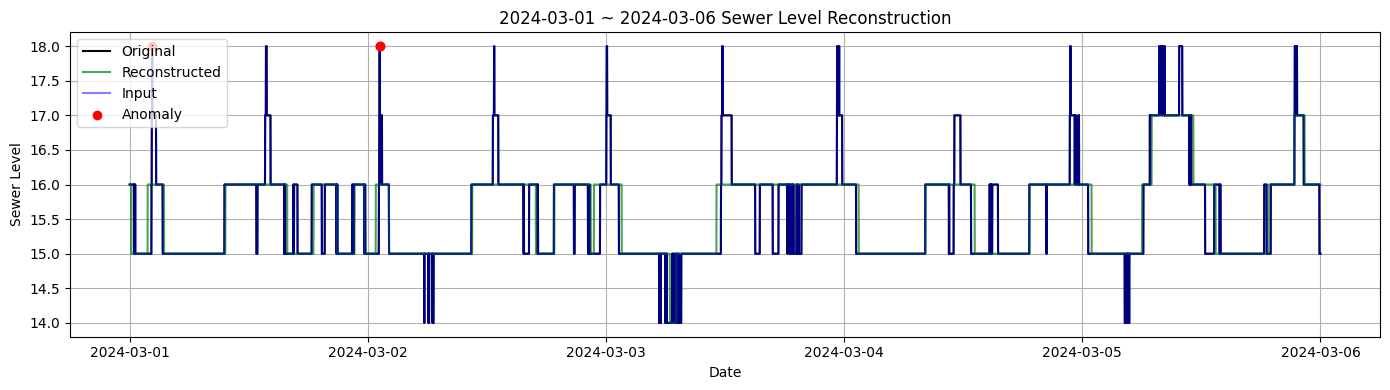

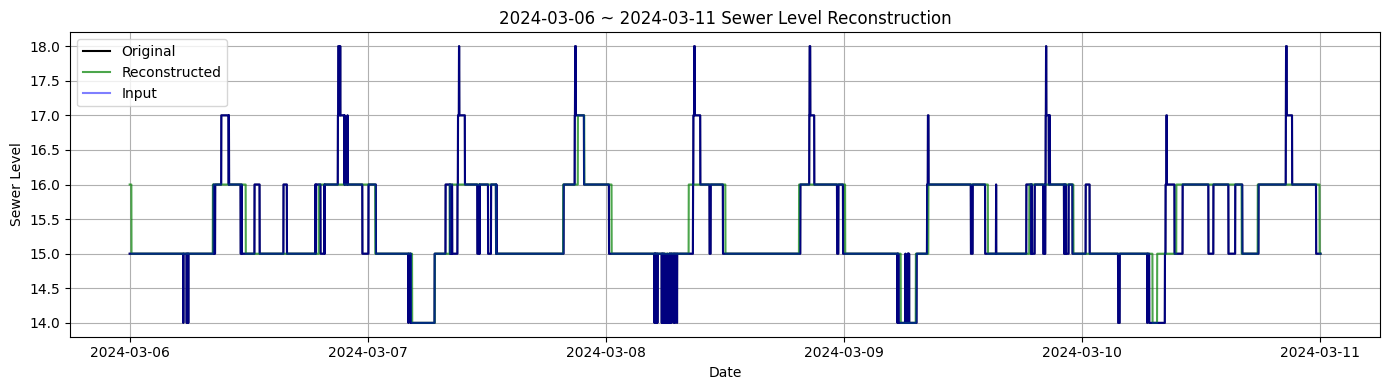

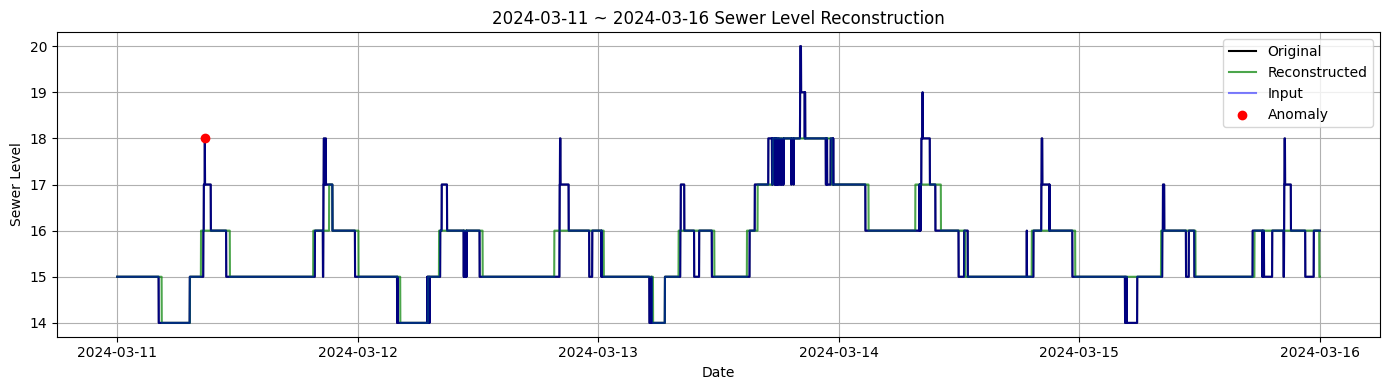

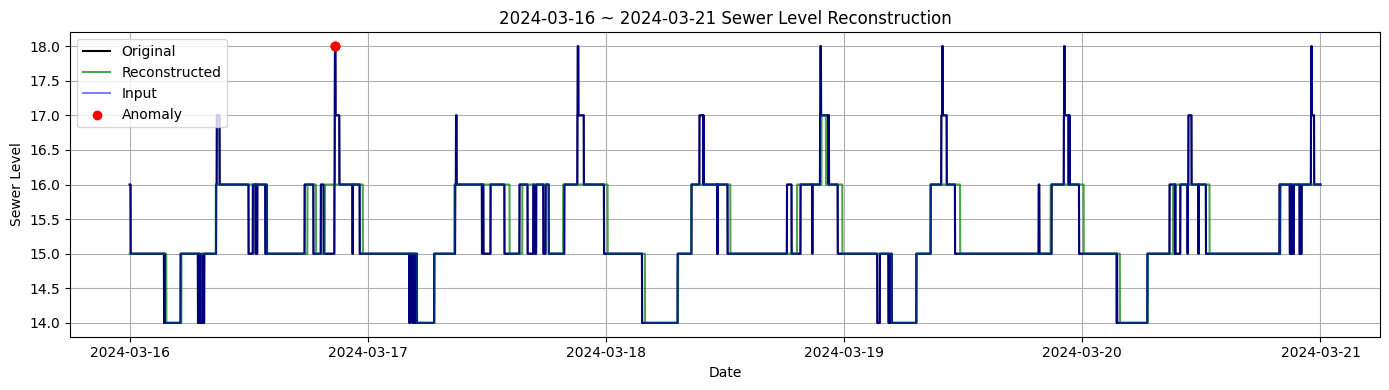

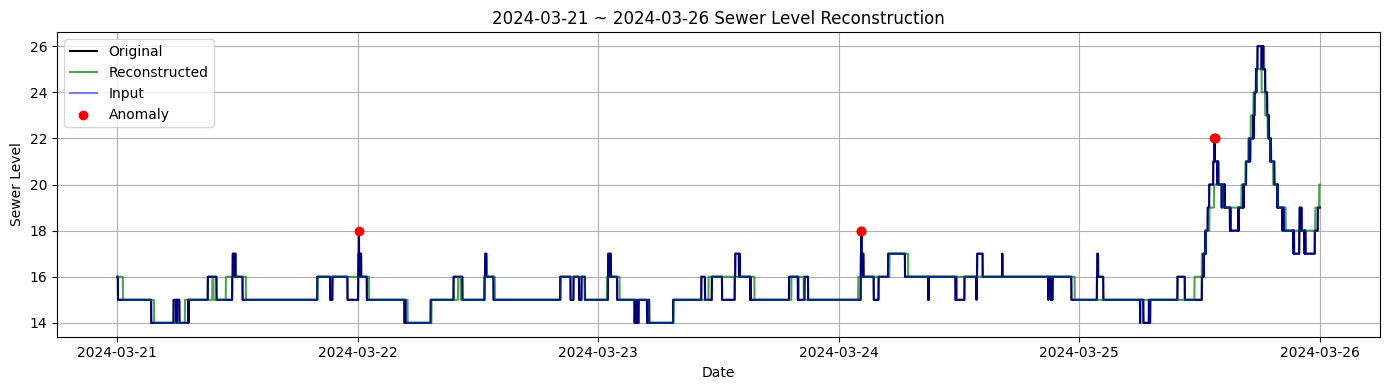

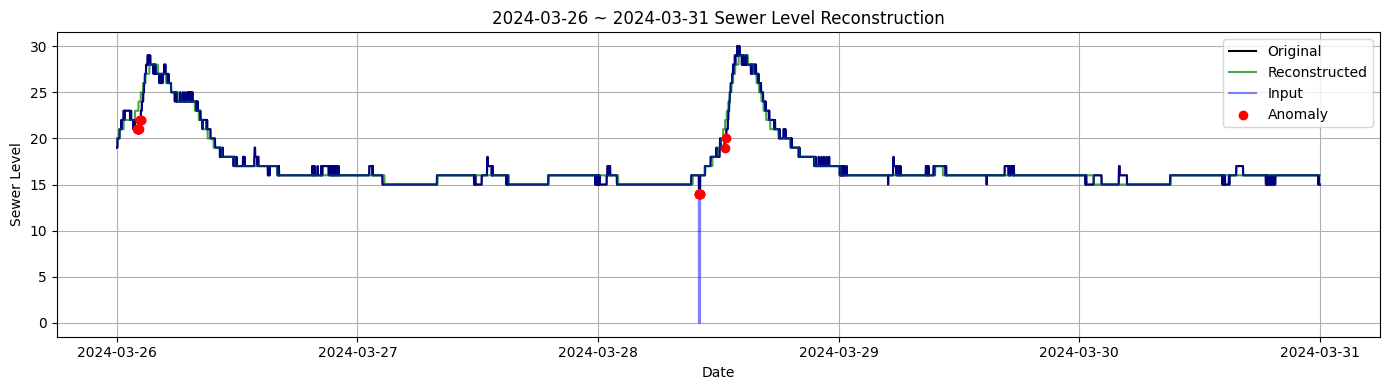

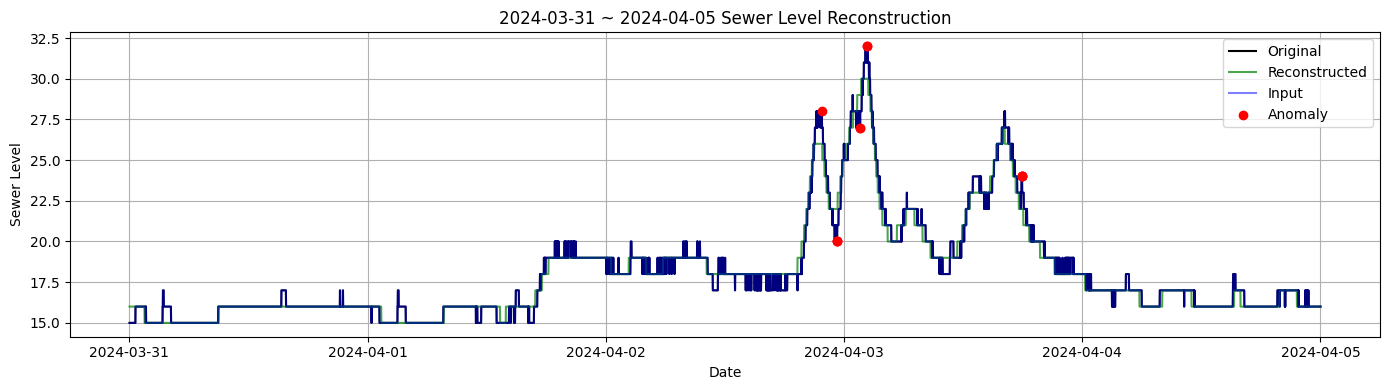

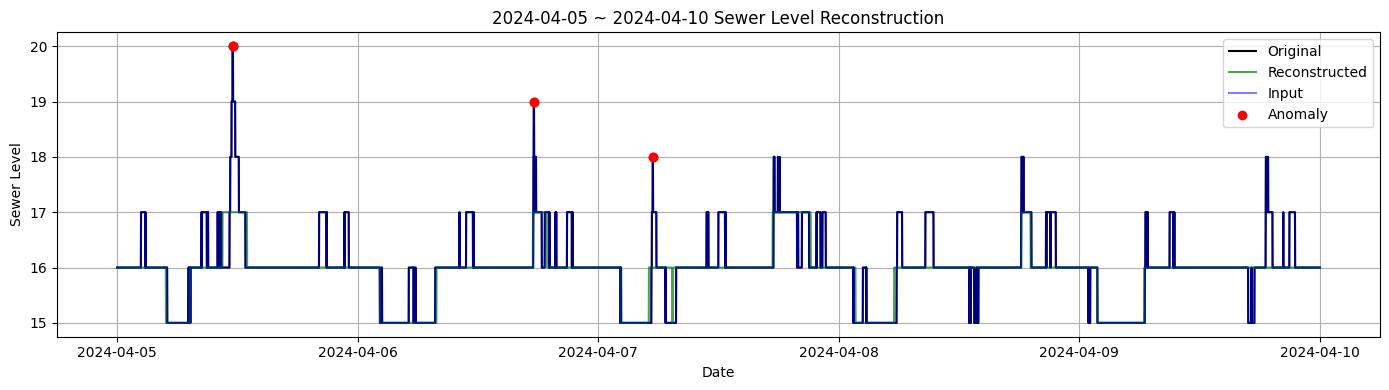

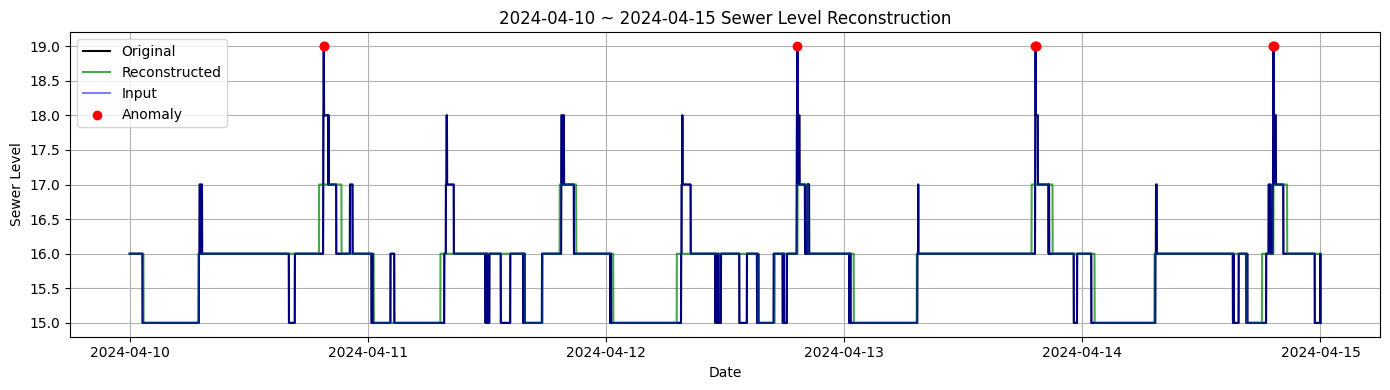

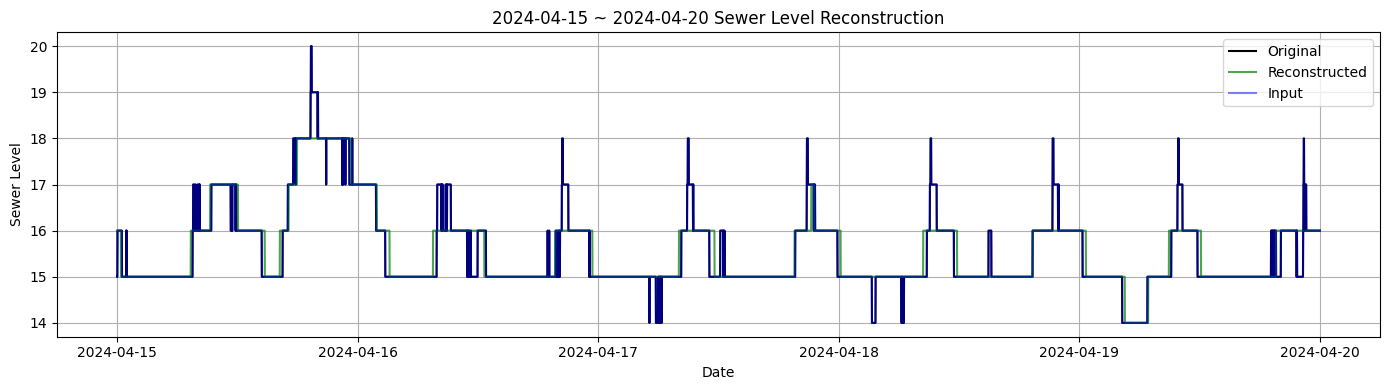

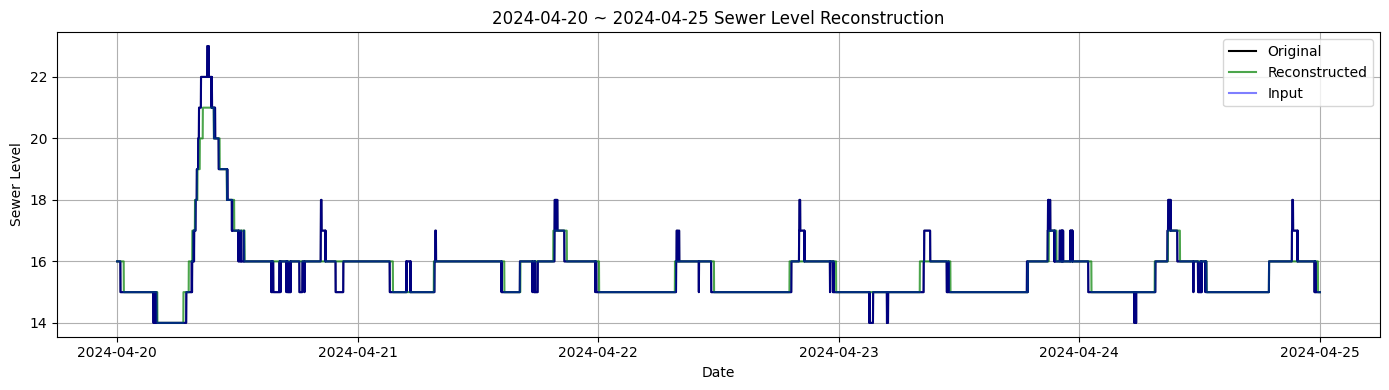

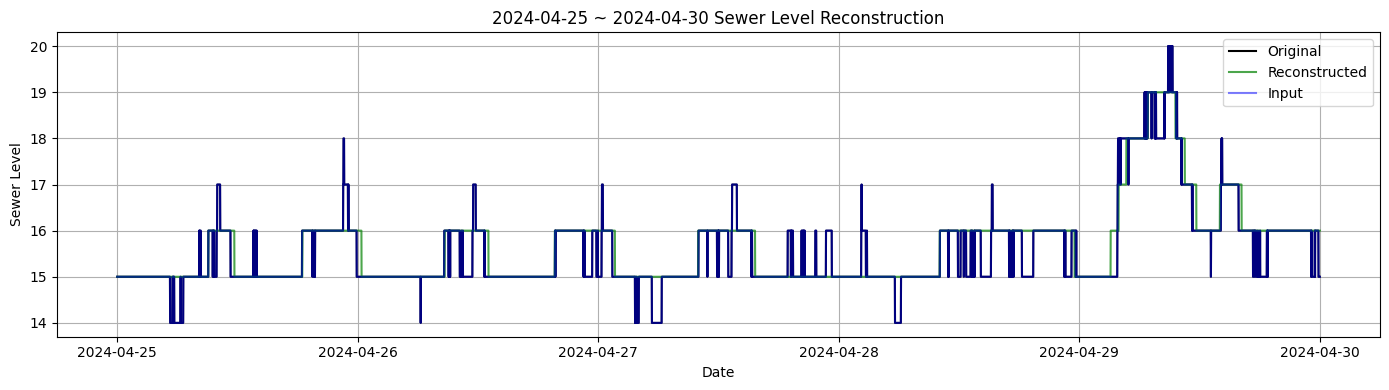

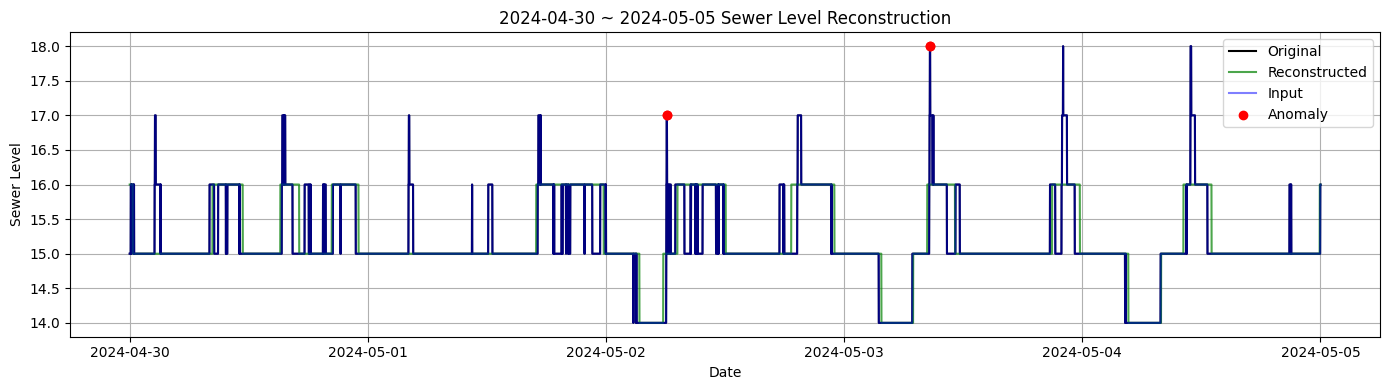

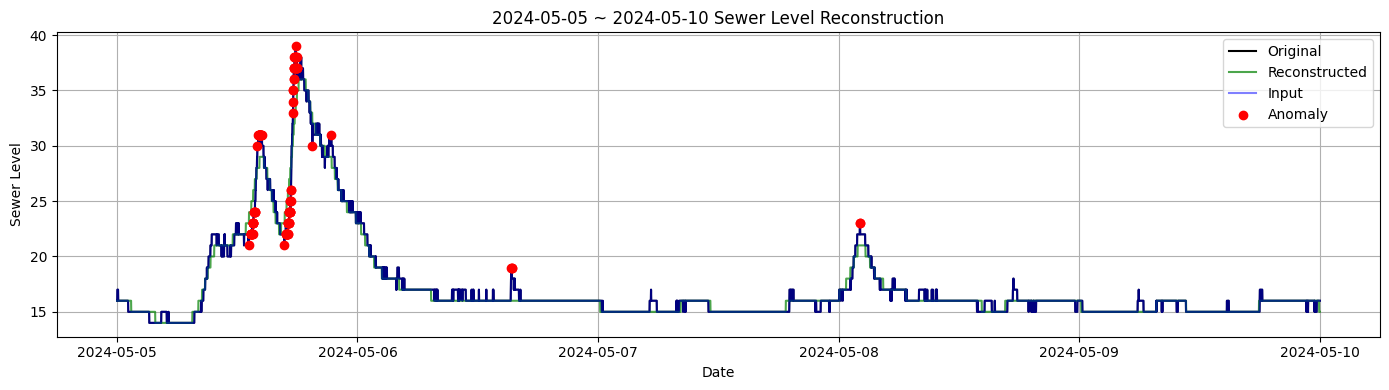

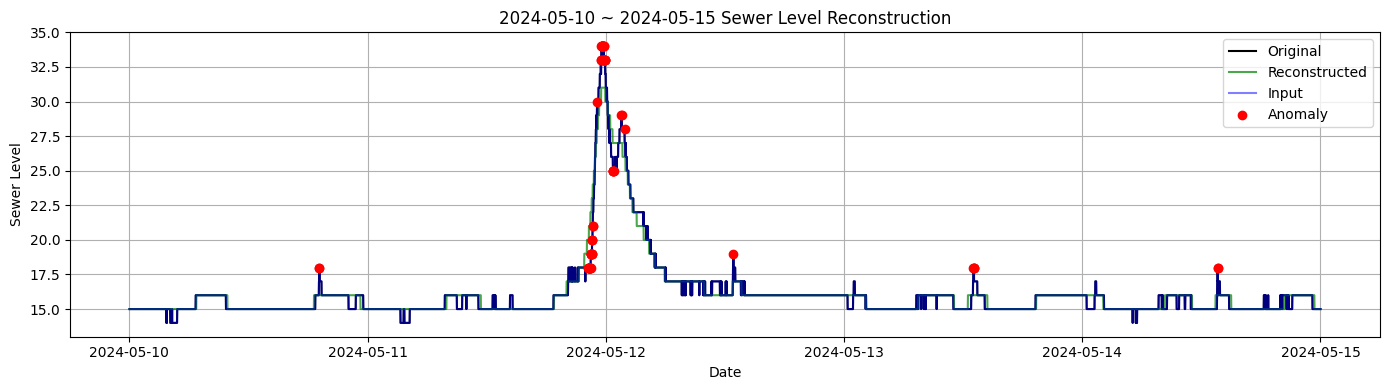

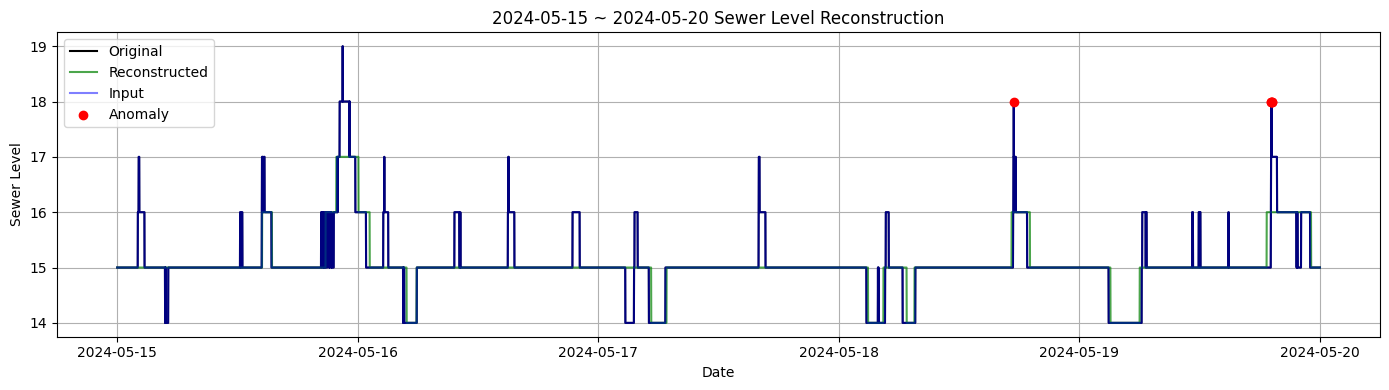

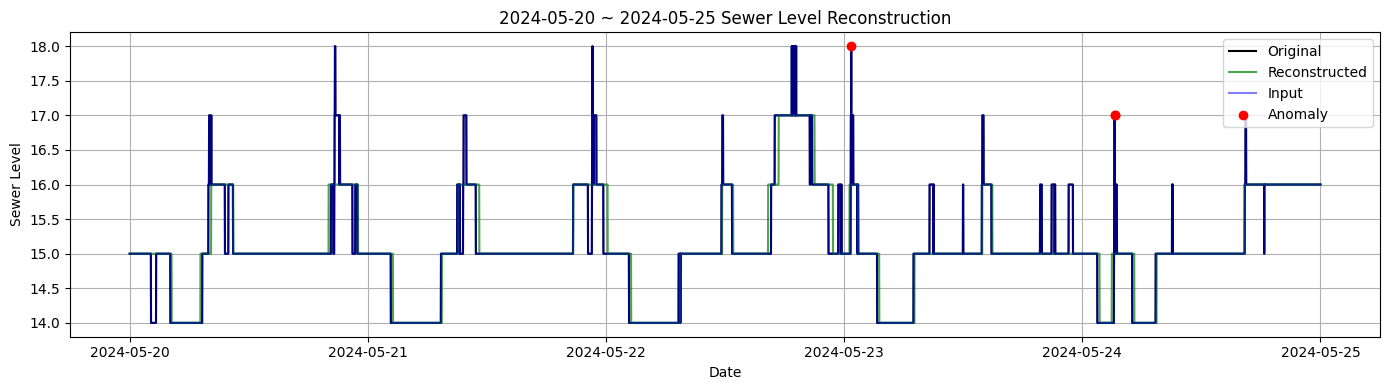

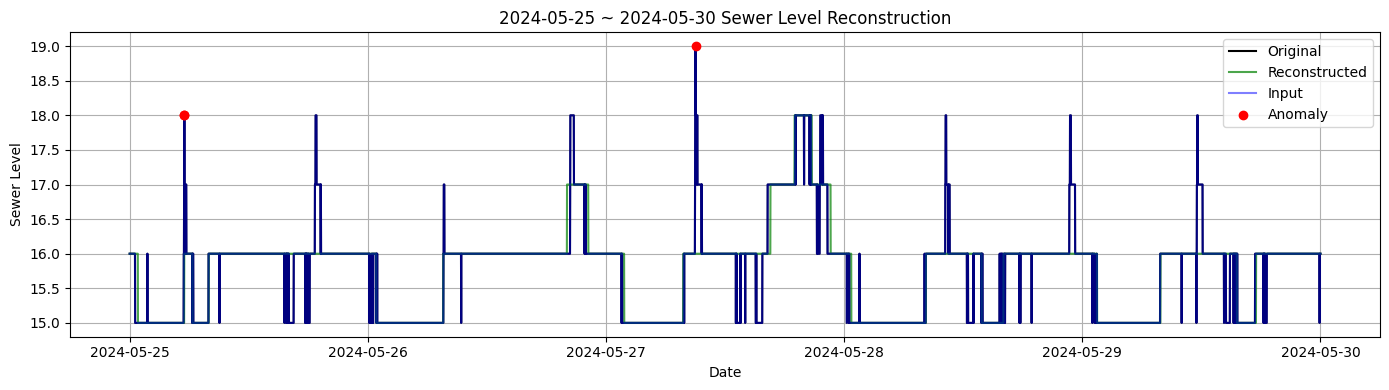

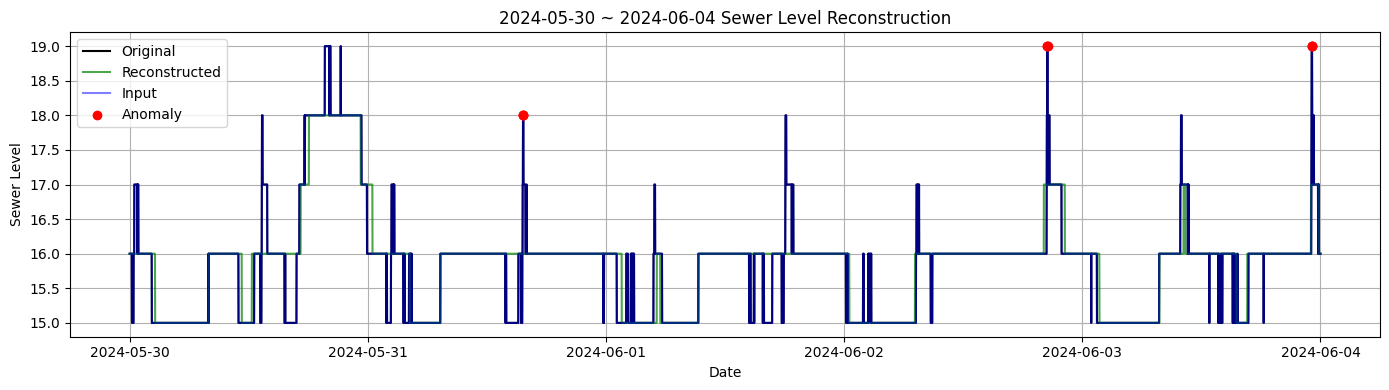

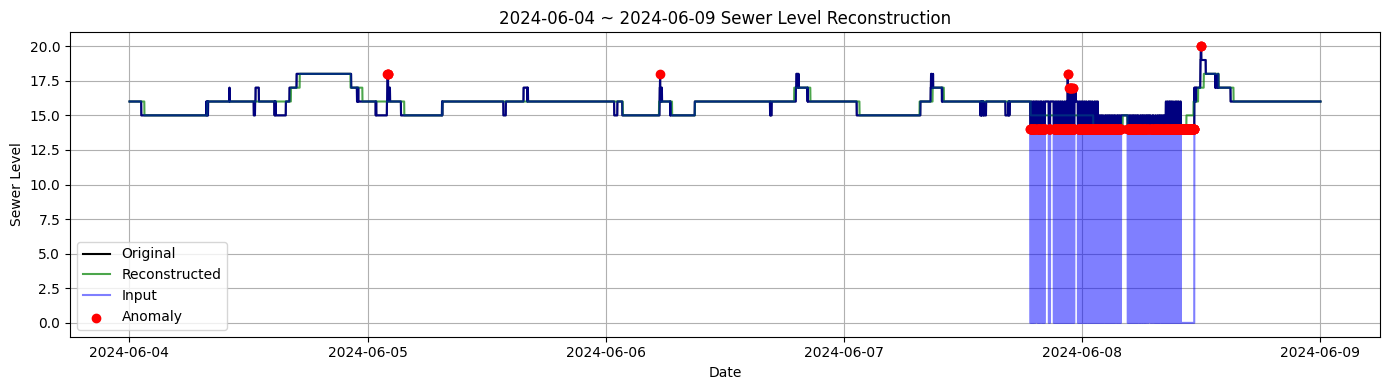

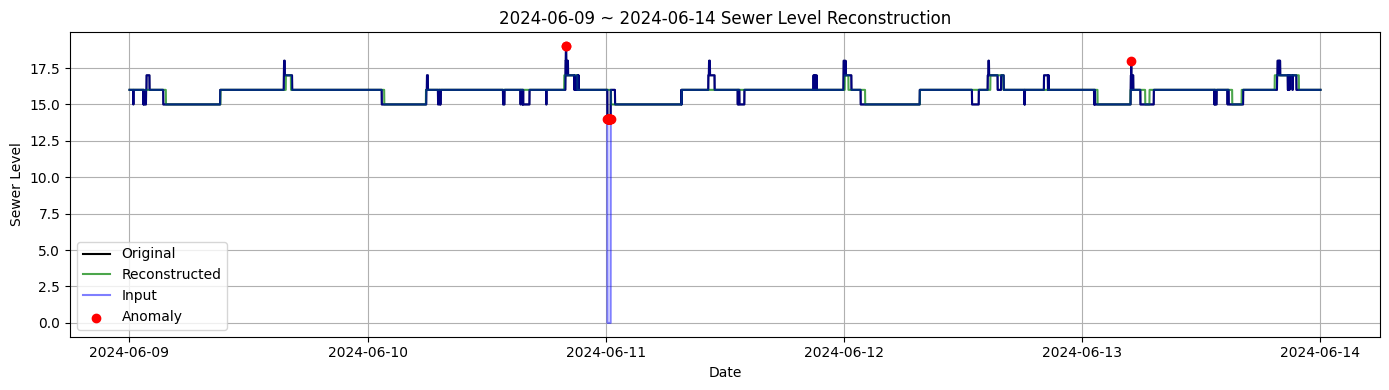

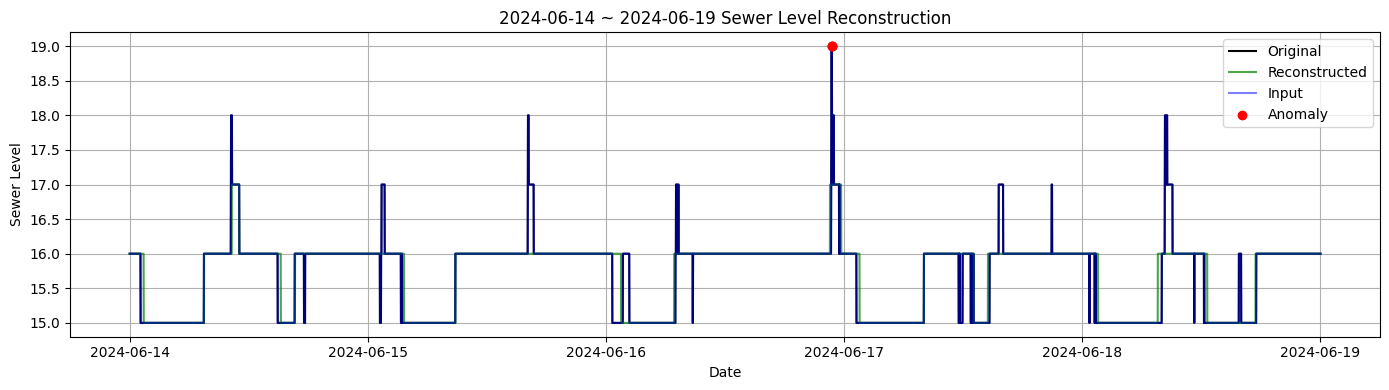

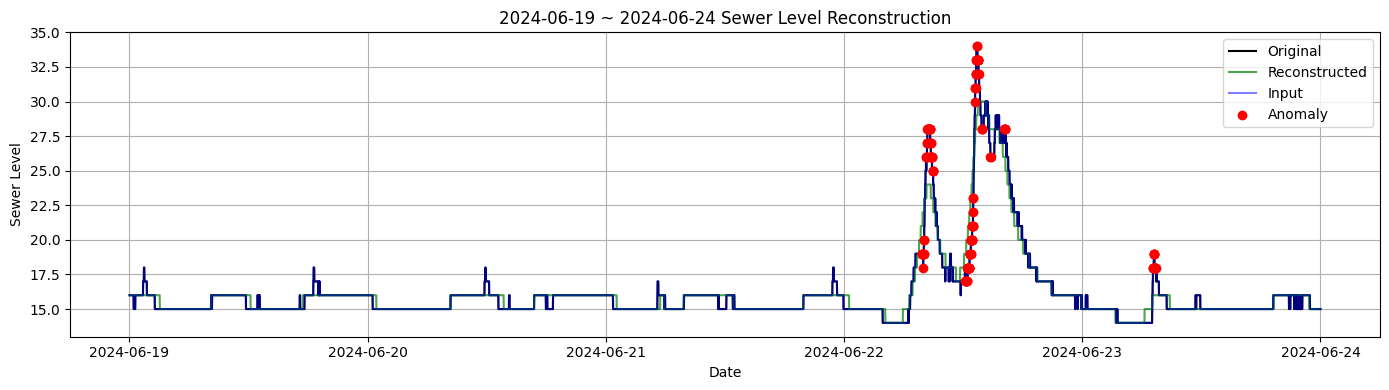

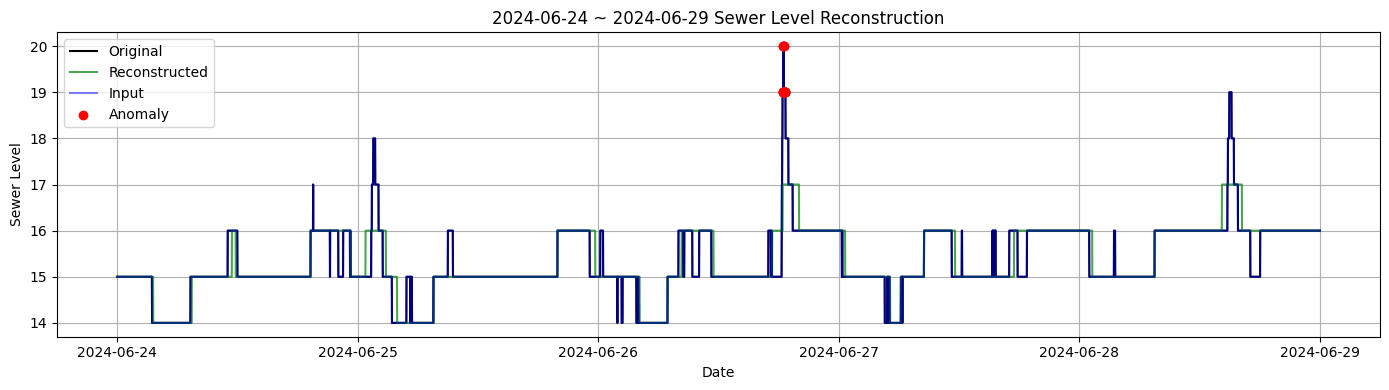

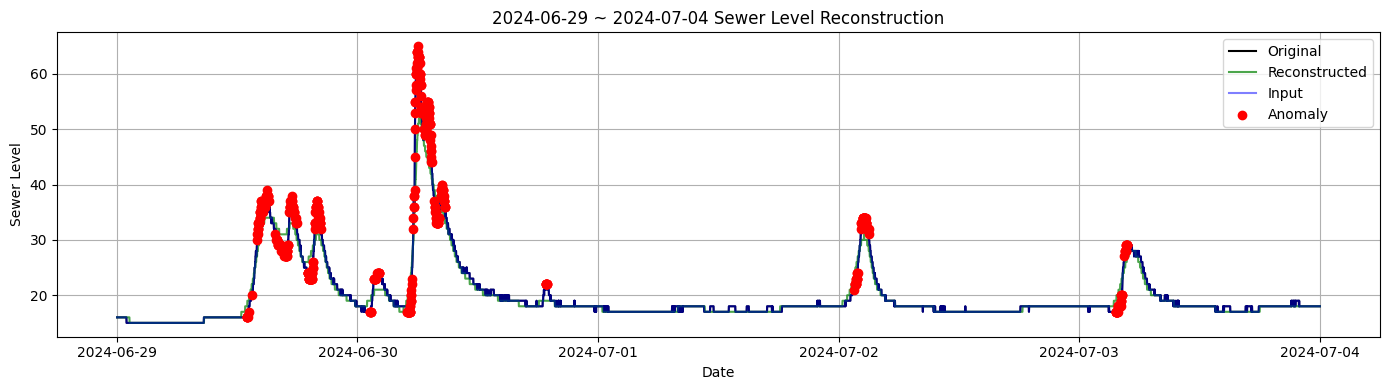

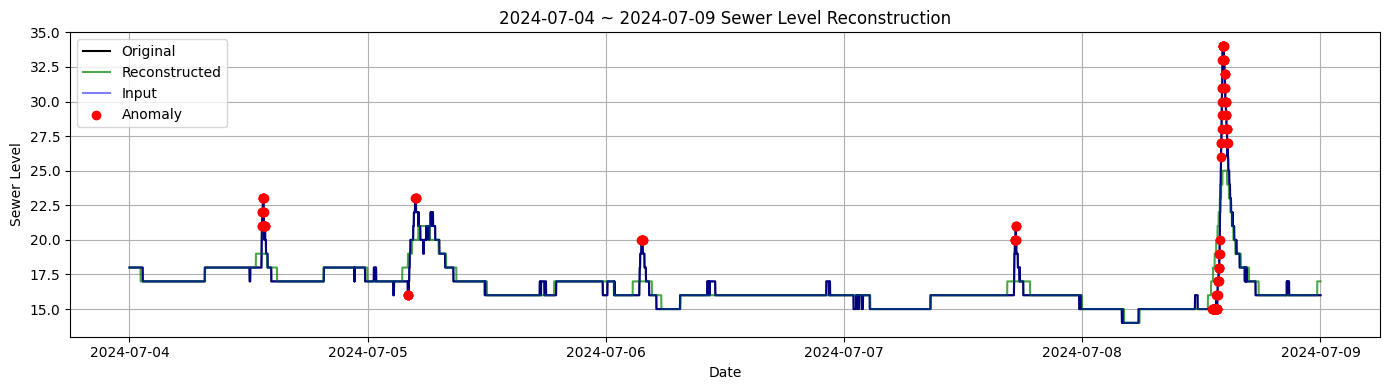

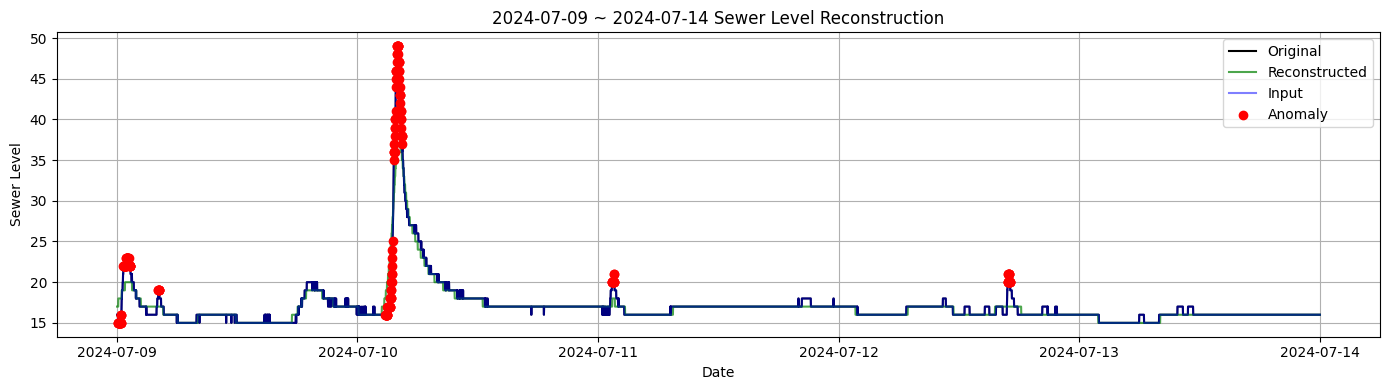

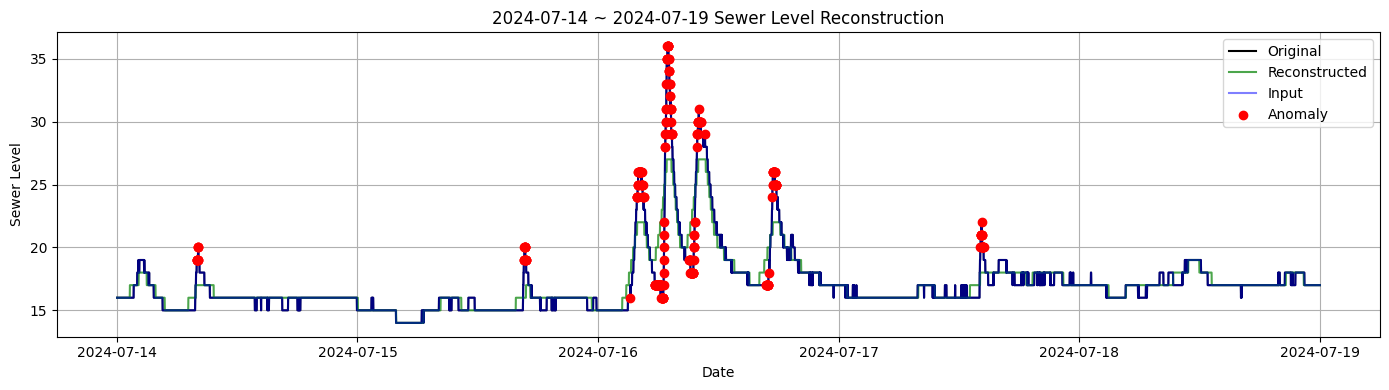

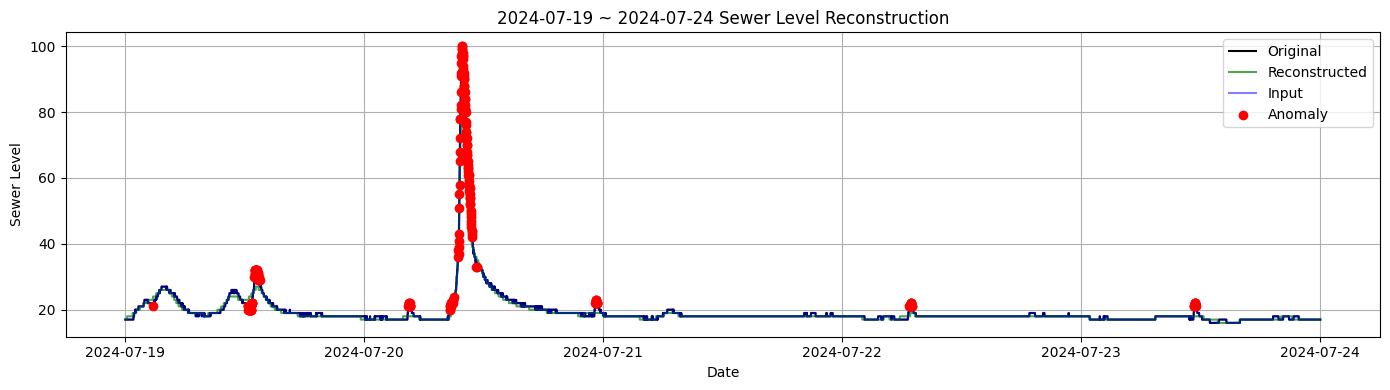

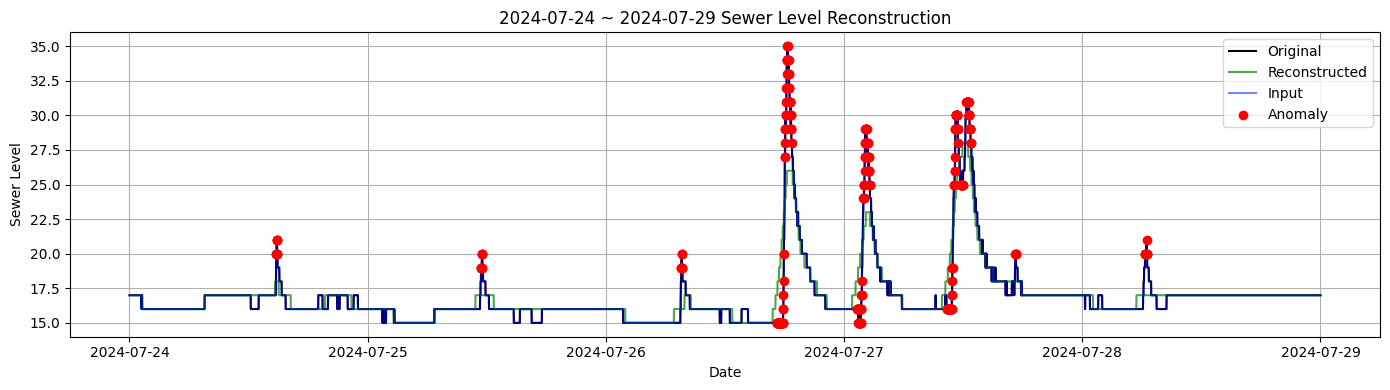

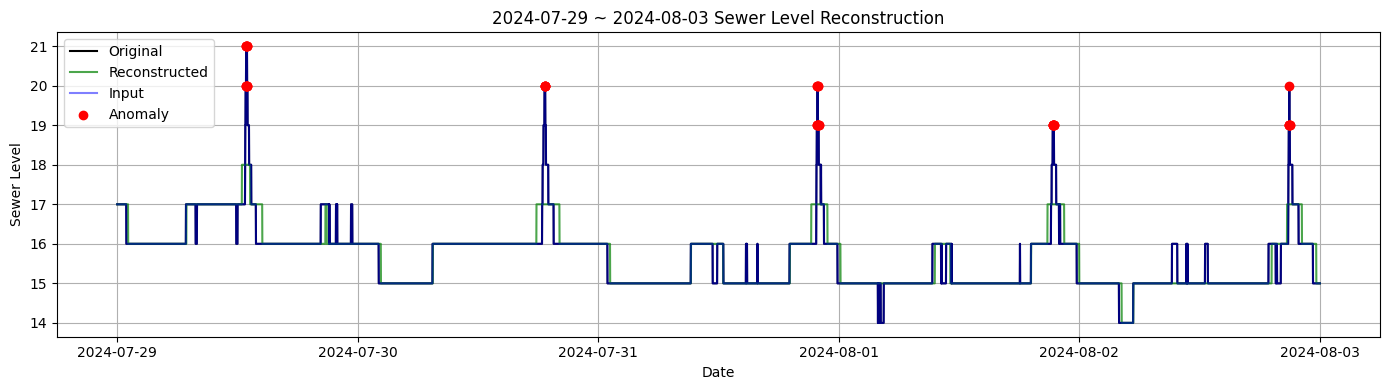

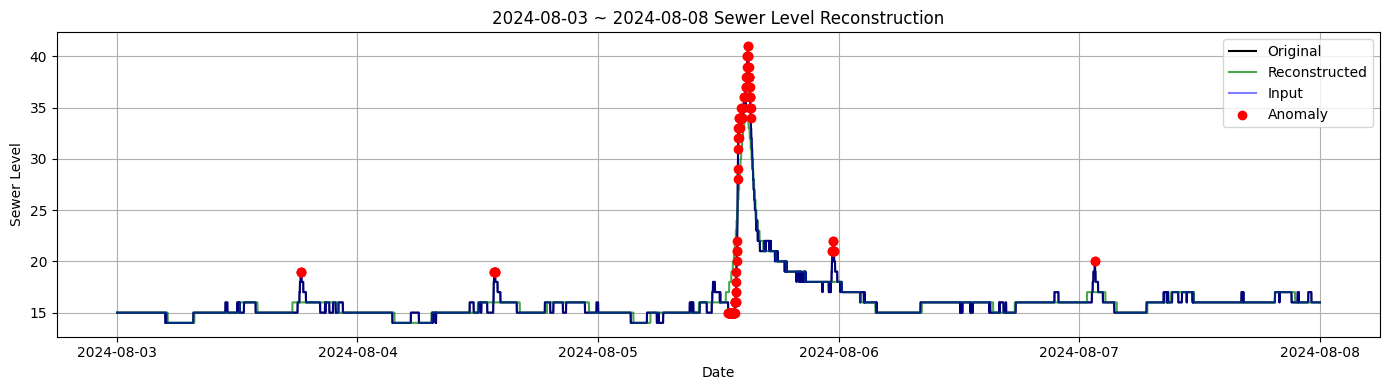

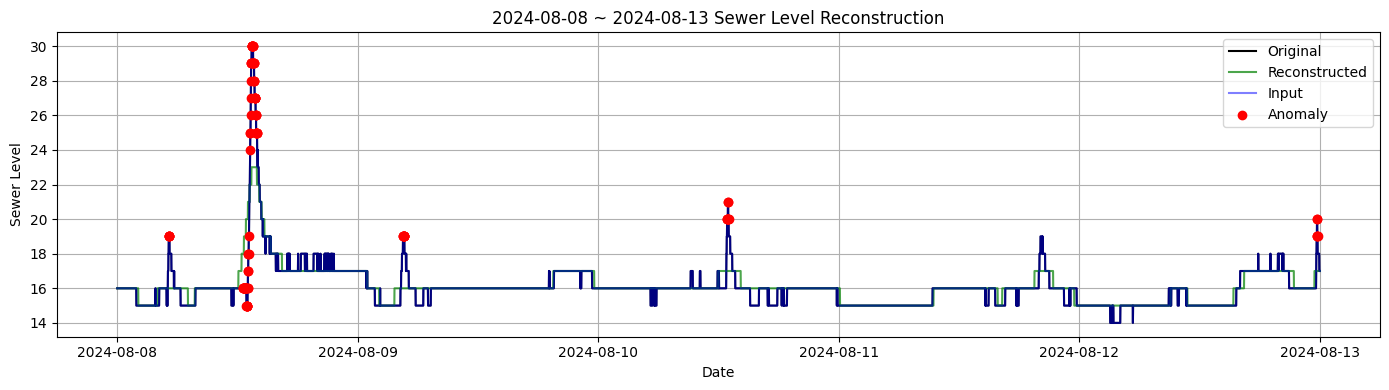

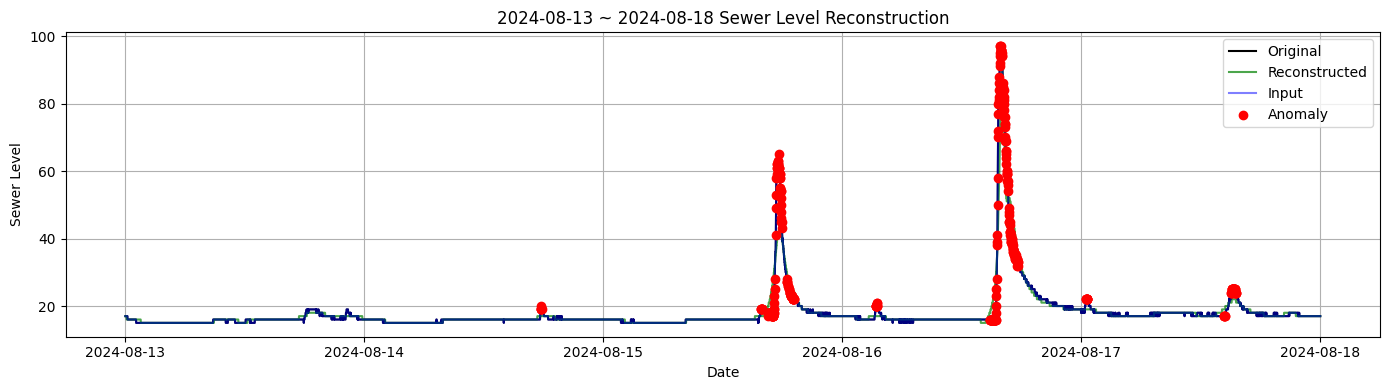

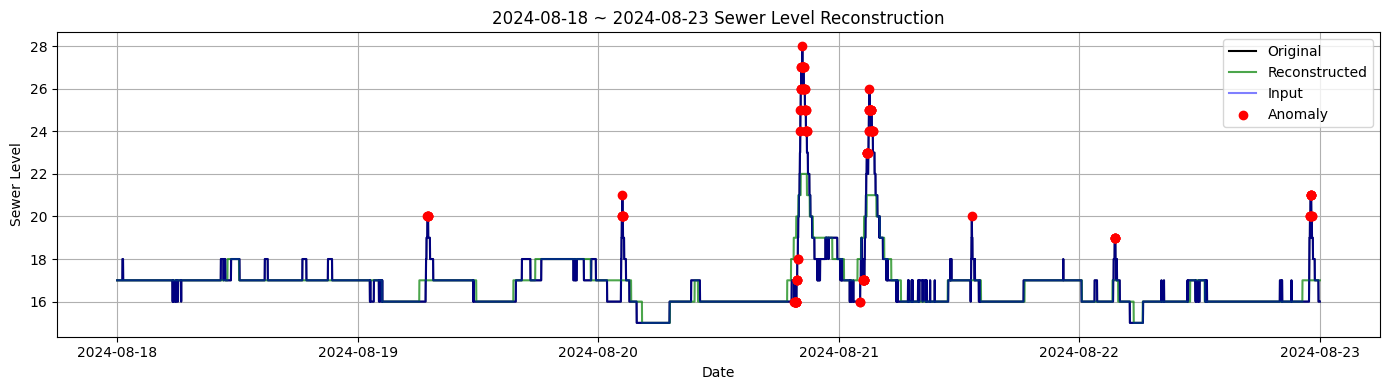

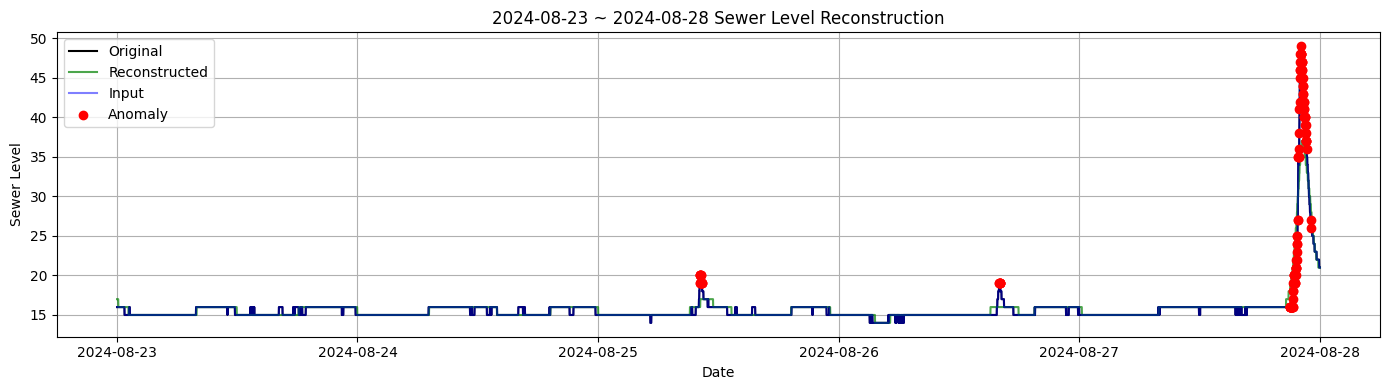

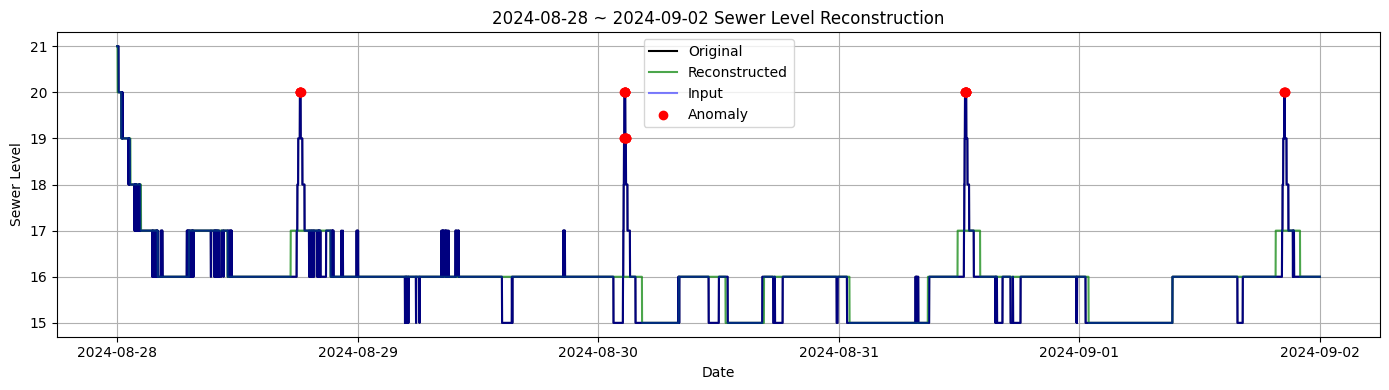

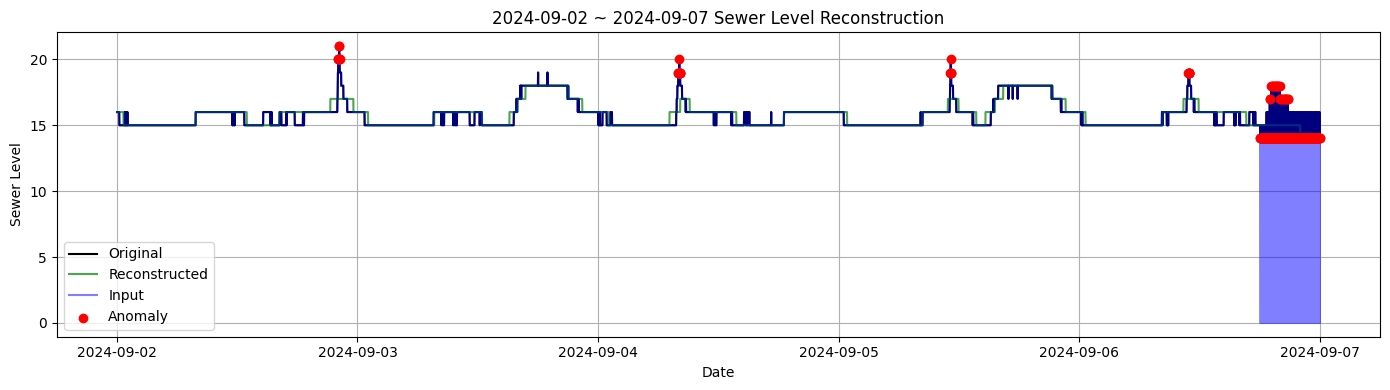

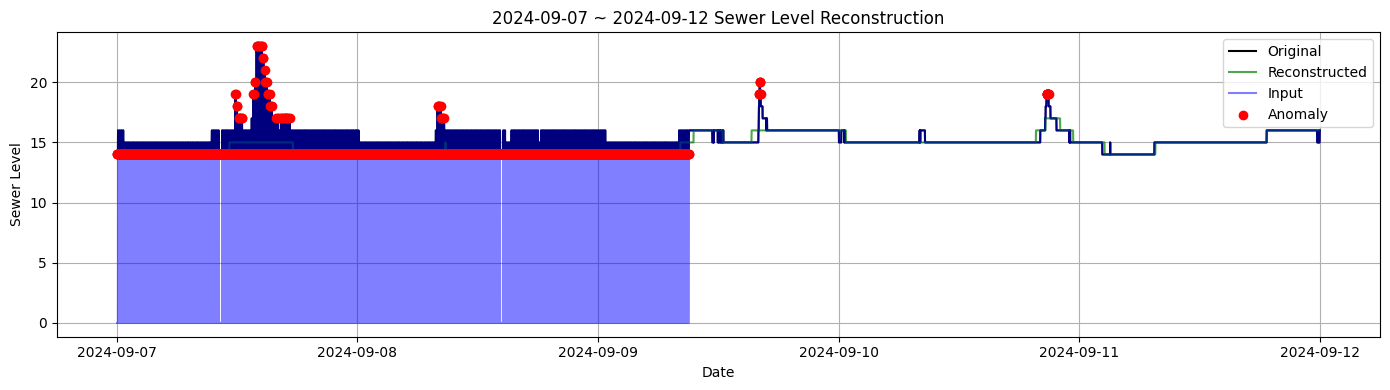

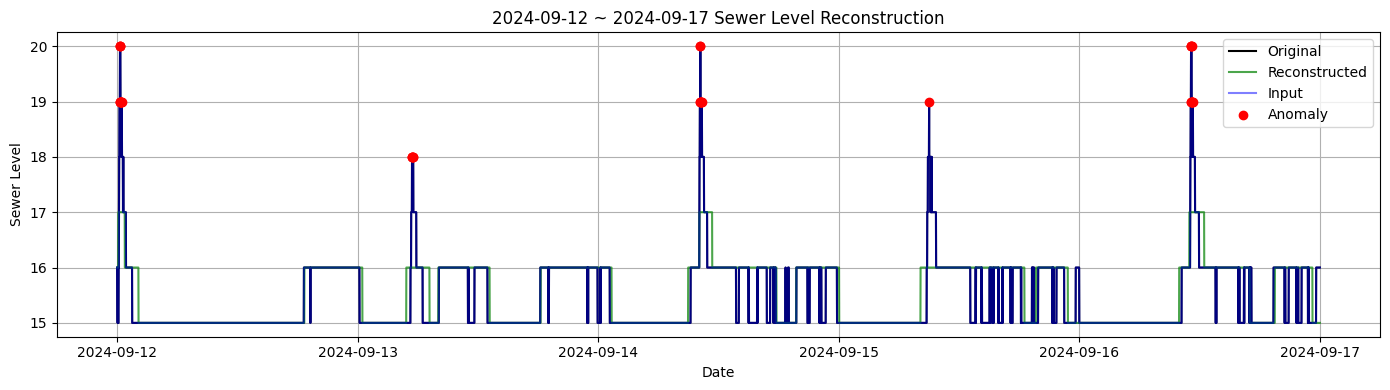

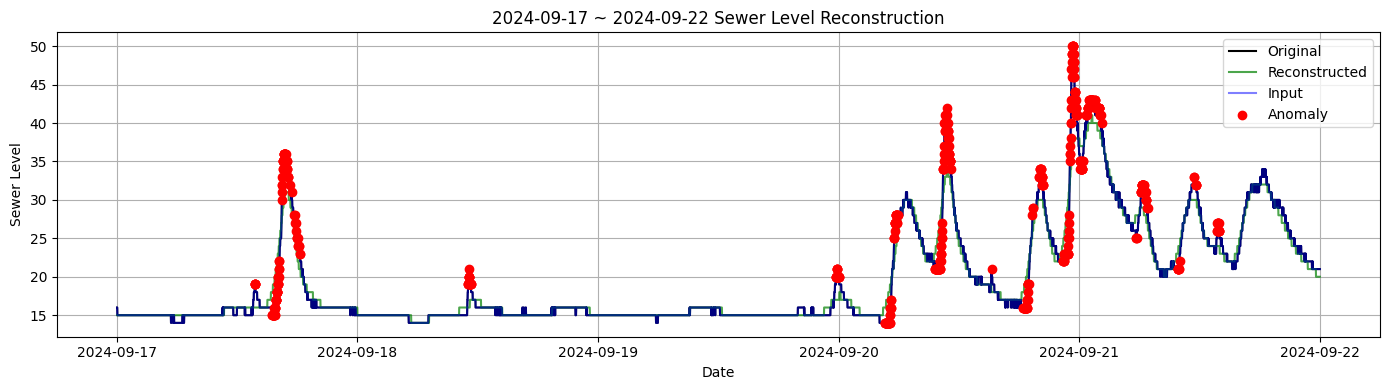

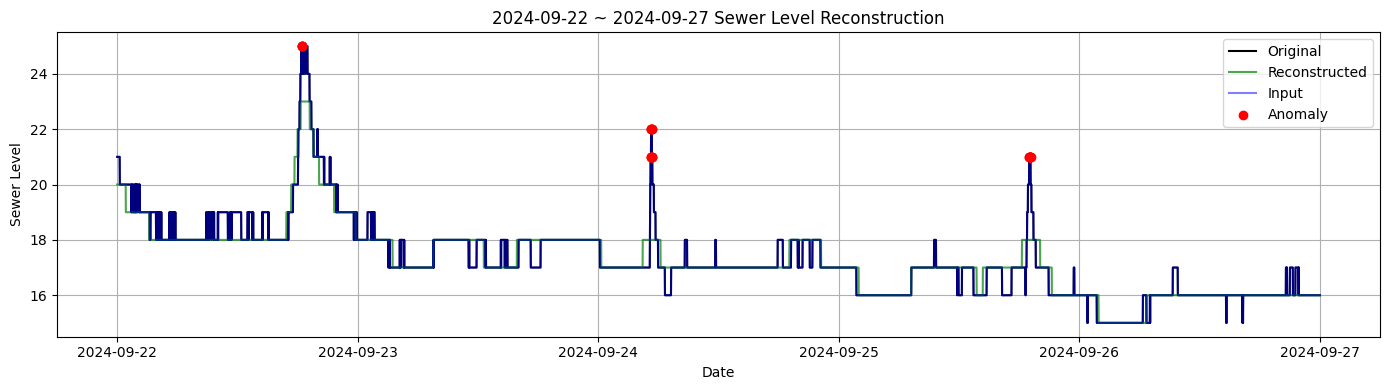

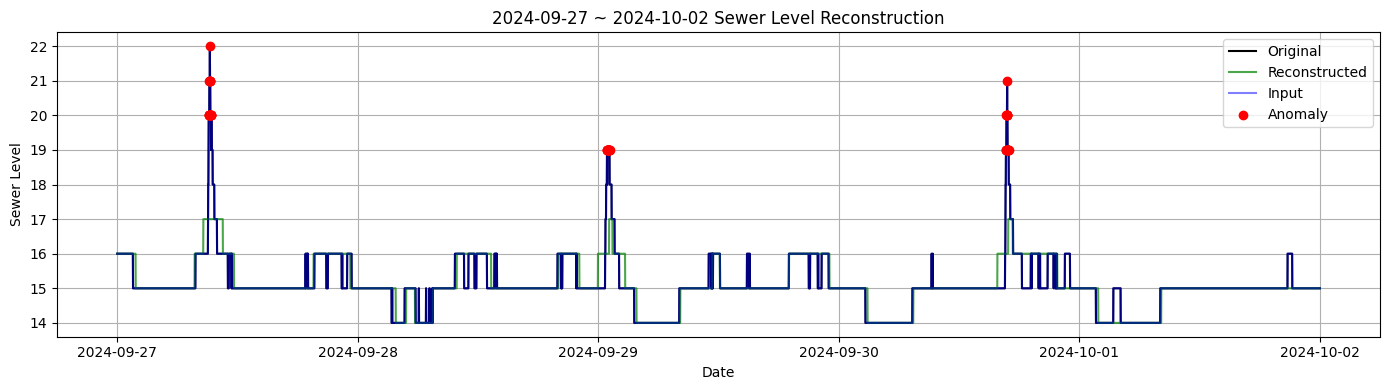

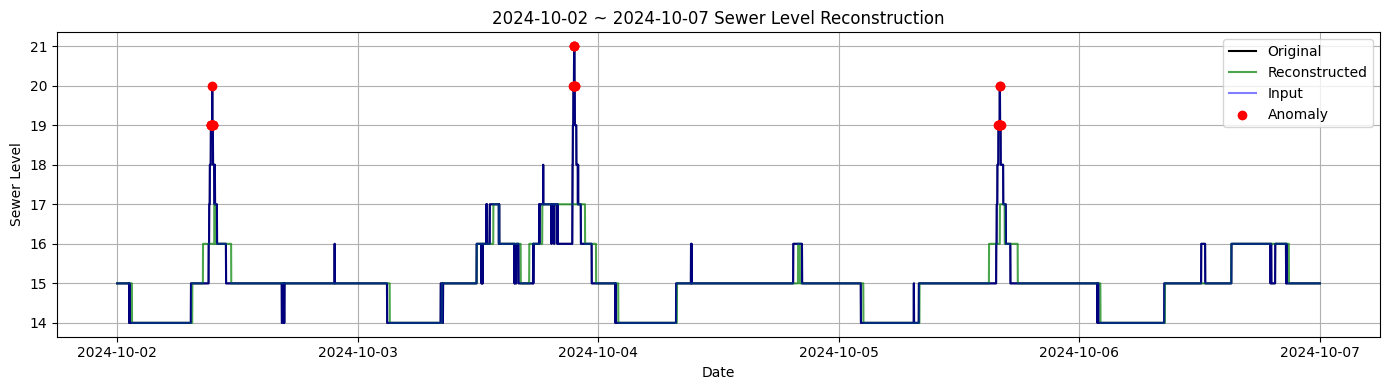

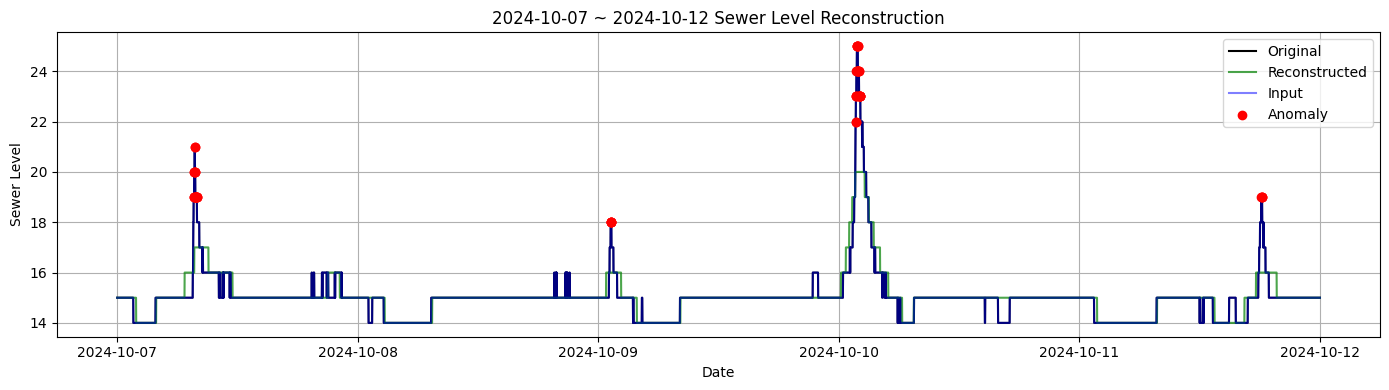

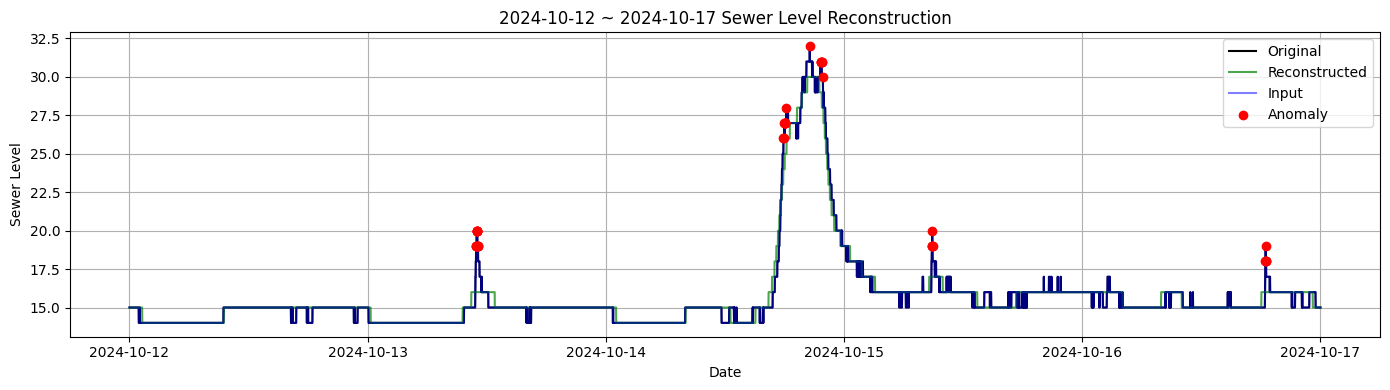

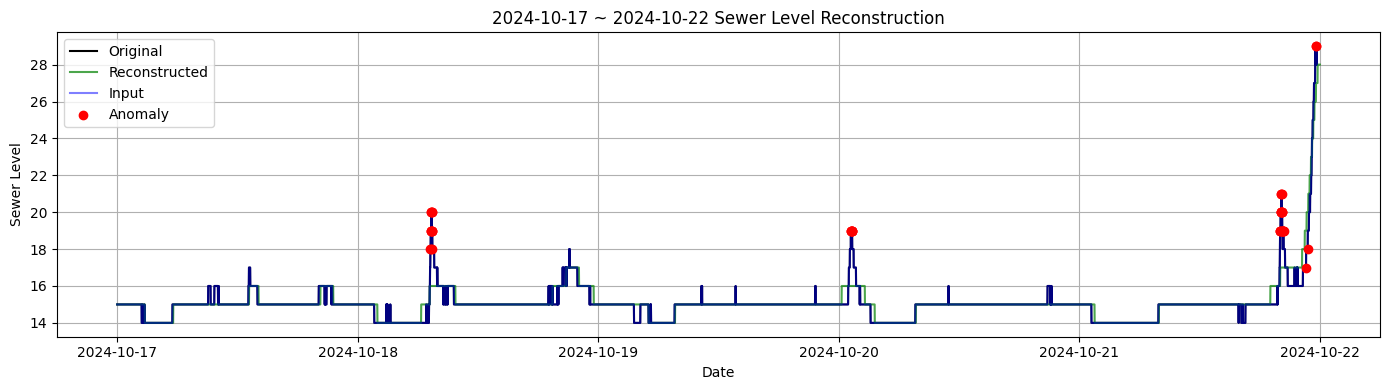

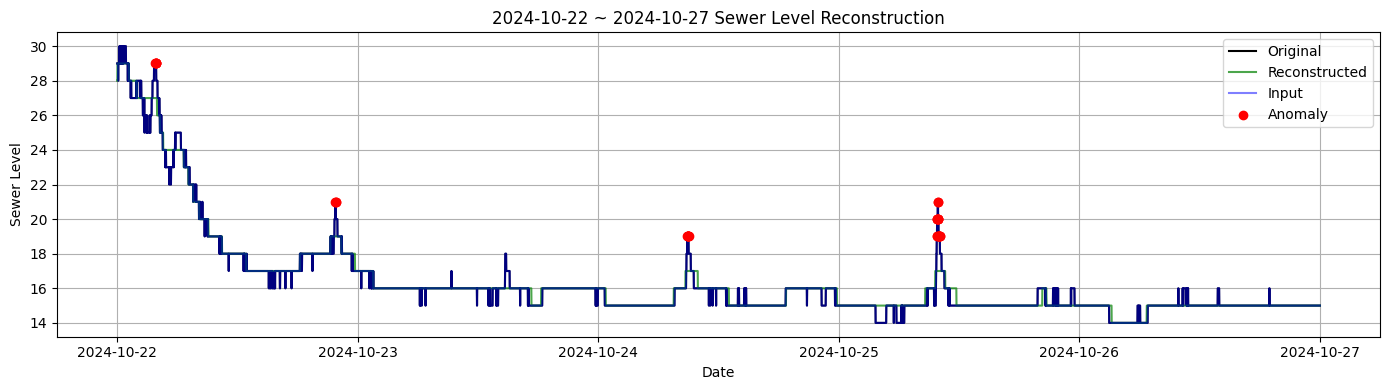

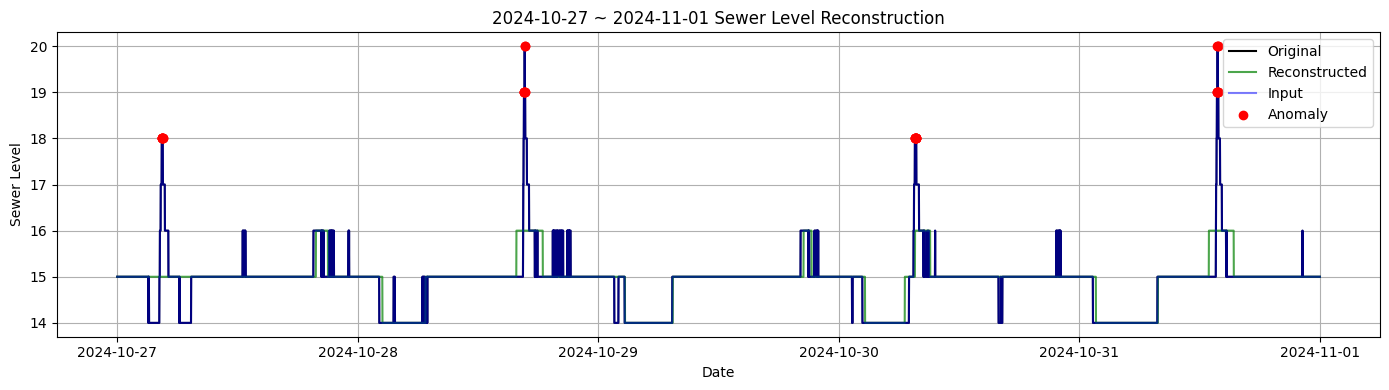

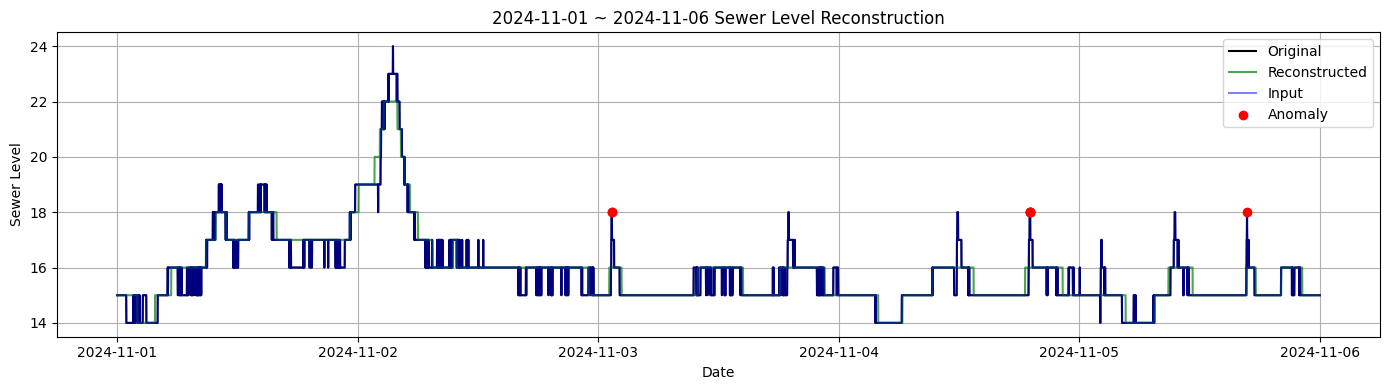

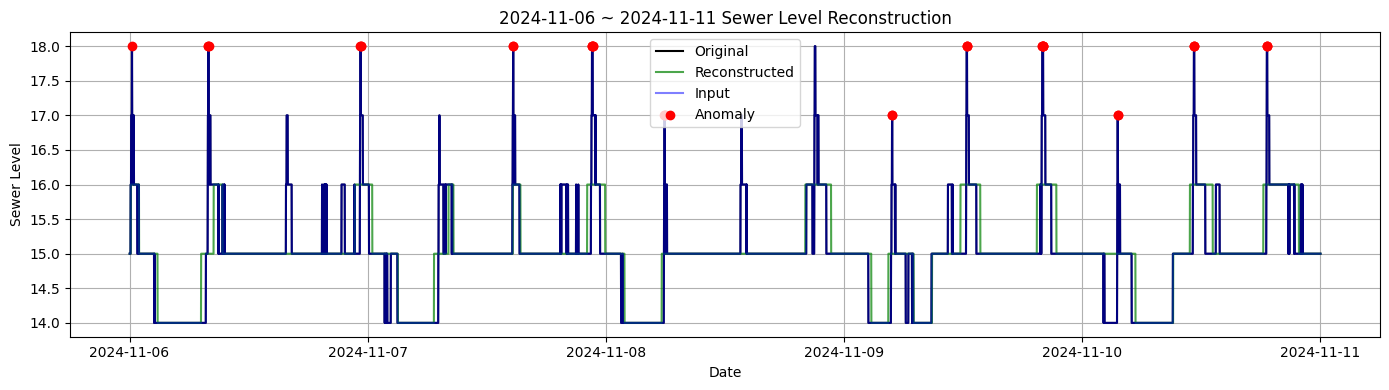

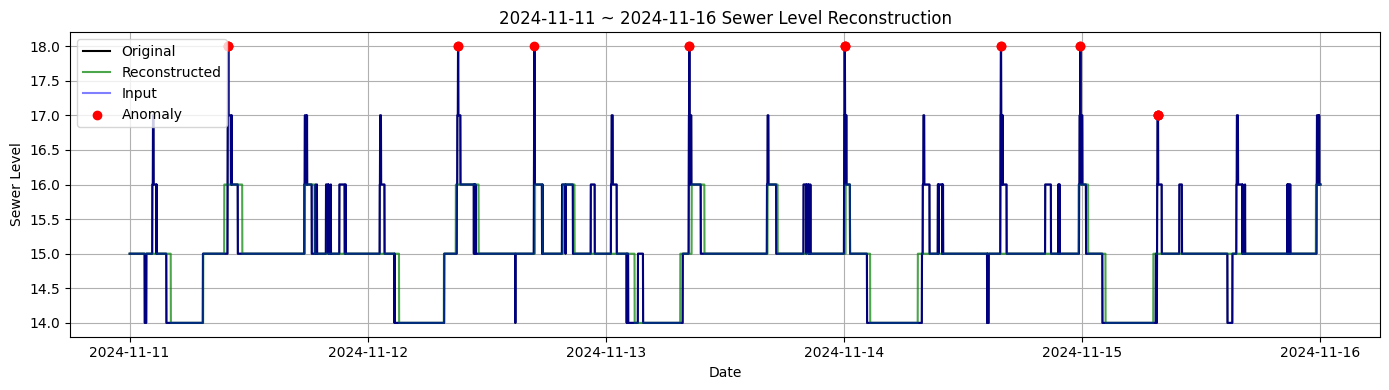

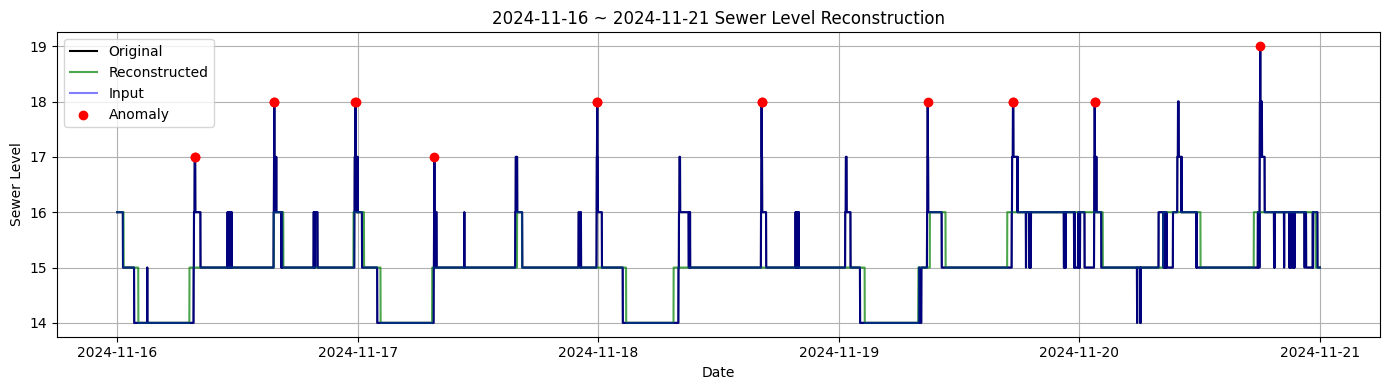

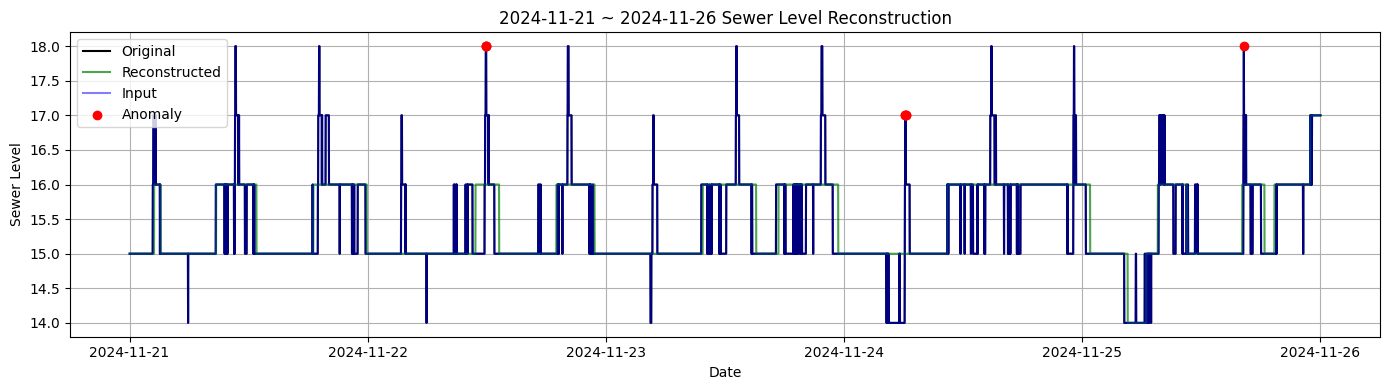

In [147]:
import matplotlib.dates as mdates
plot_decadal_timeseries_with_anomalies(
    tt=tt,
    original=original_norm_g, 
    predicted=corrected_norm_g, 
    input_data=input_seq_g,
    anomaly_flags=anomaly_flags_g,  
    # save_dir='./imgs/USAD_120_gc/gwangjoo/',
    interval_days=5
)

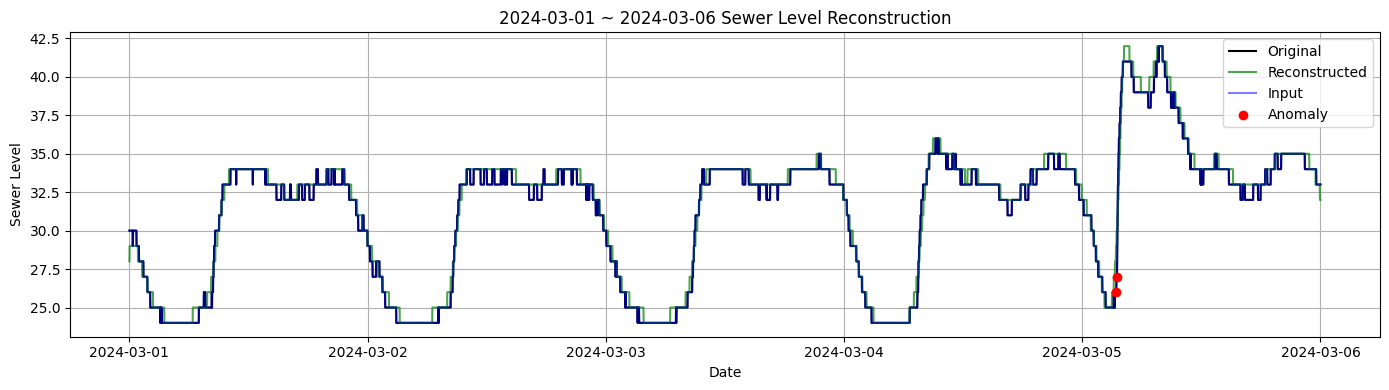

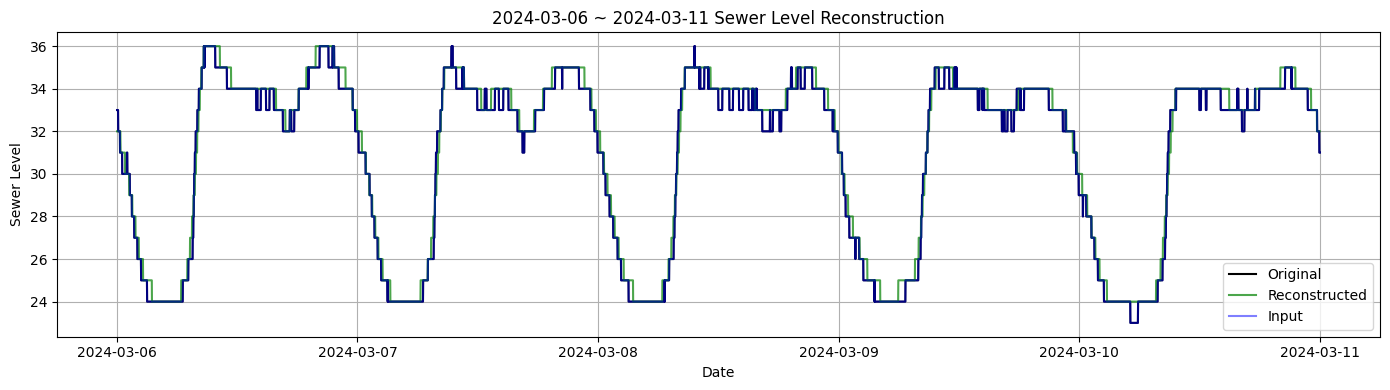

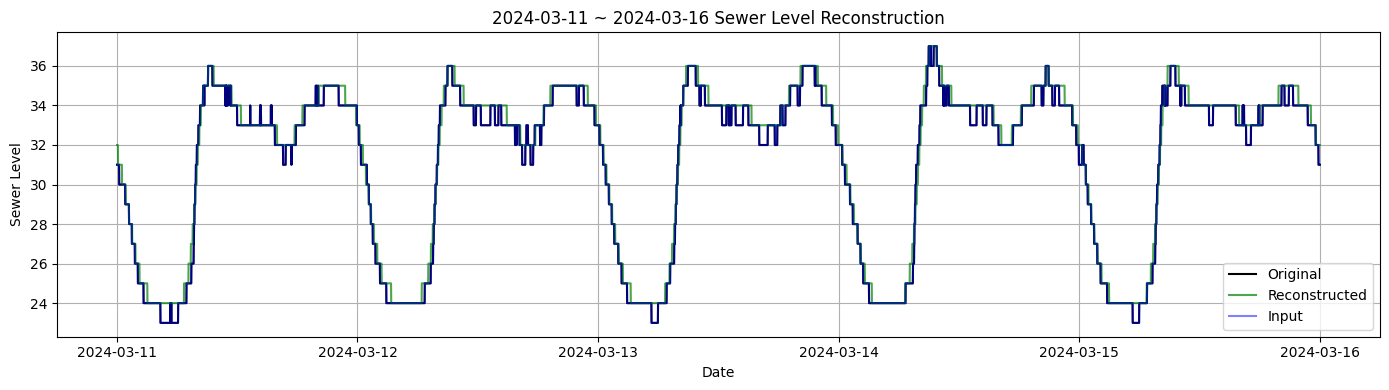

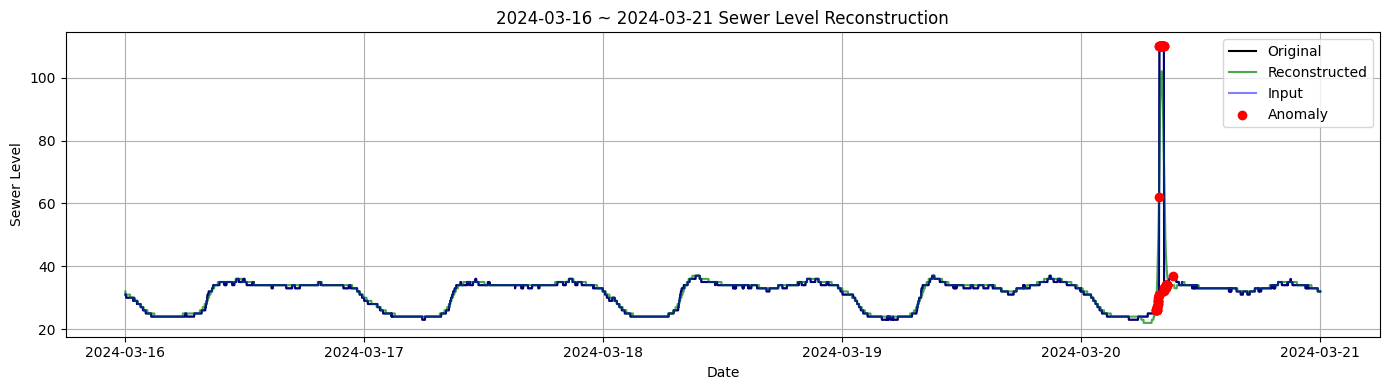

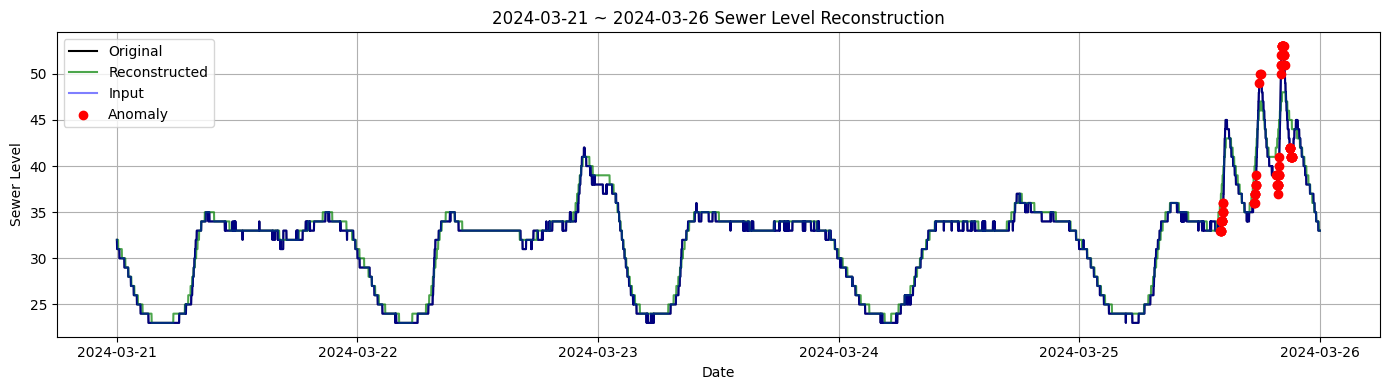

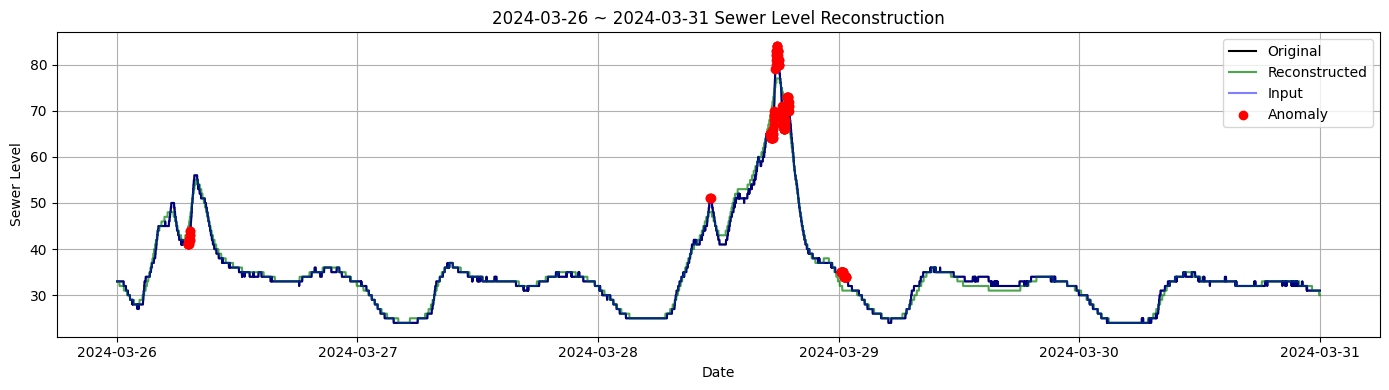

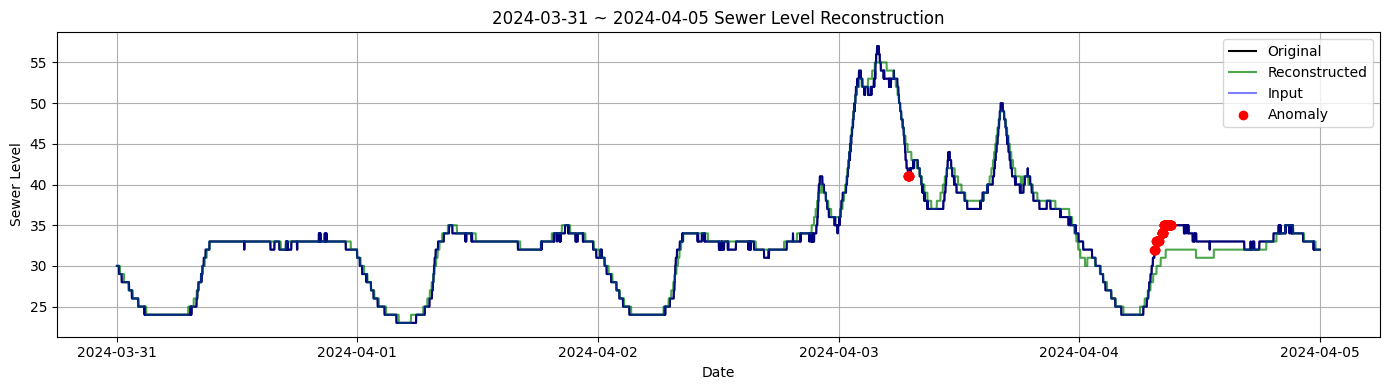

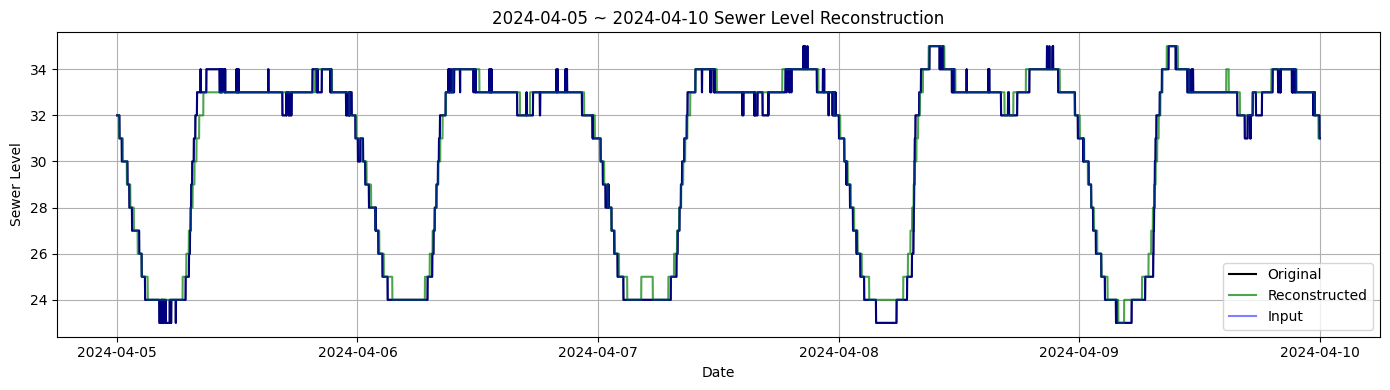

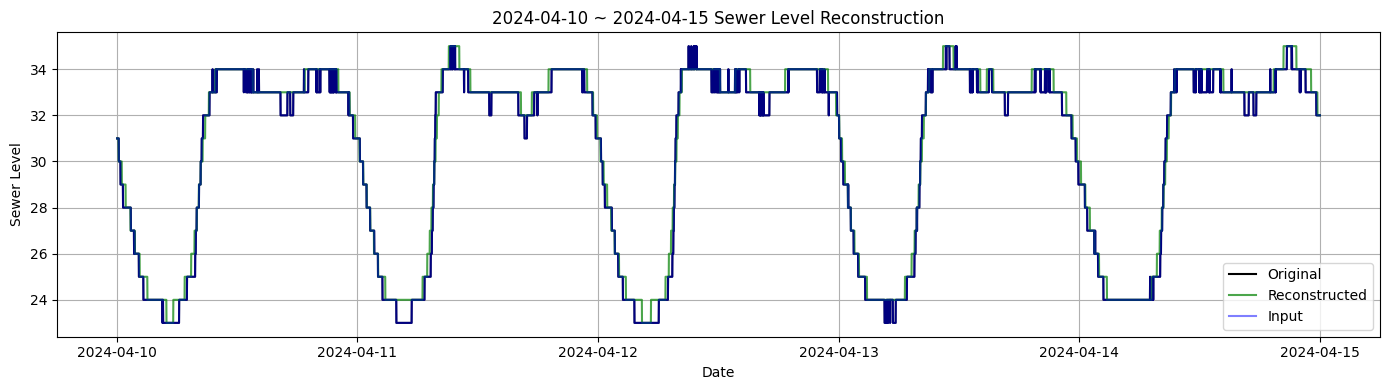

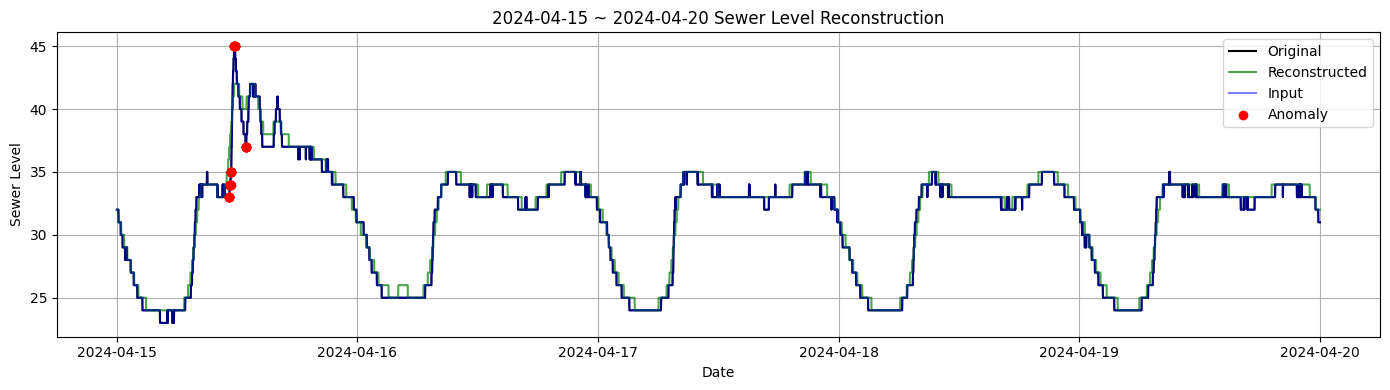

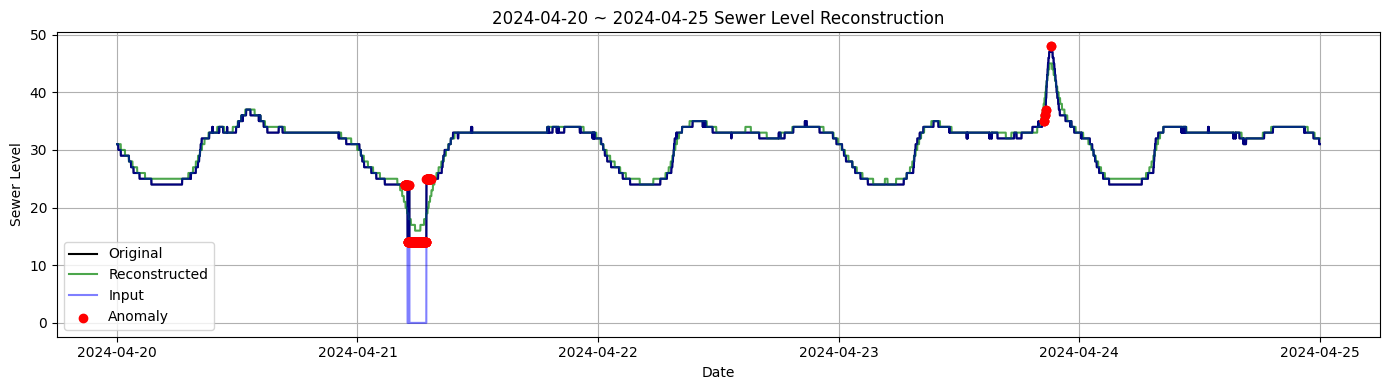

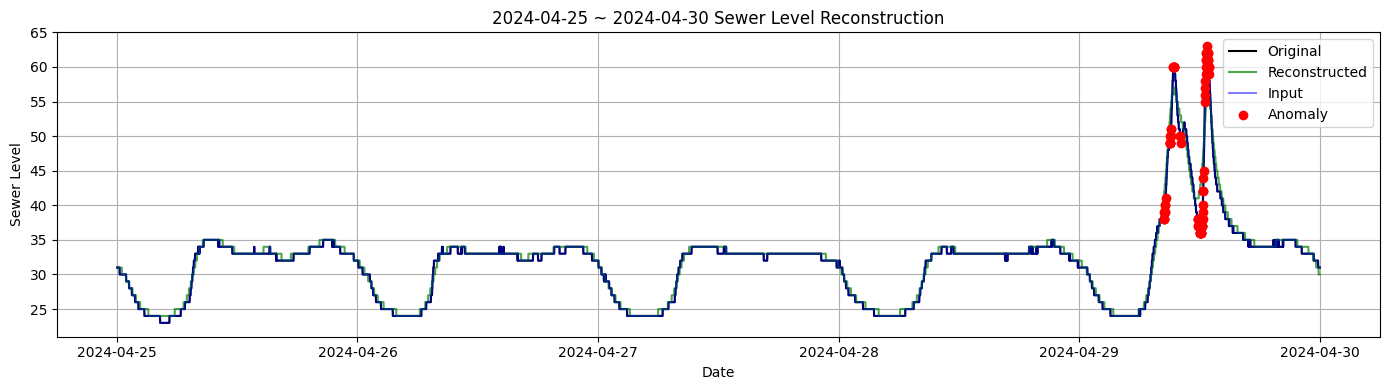

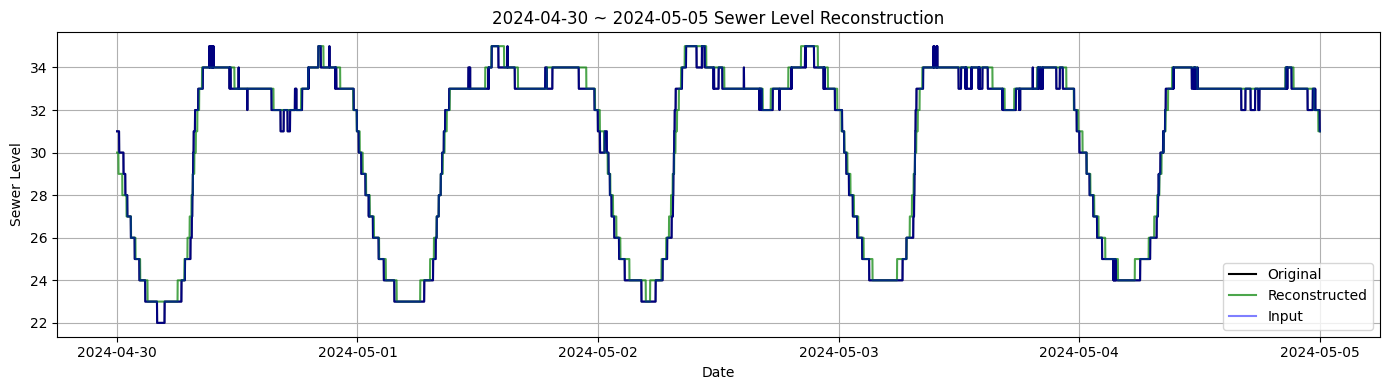

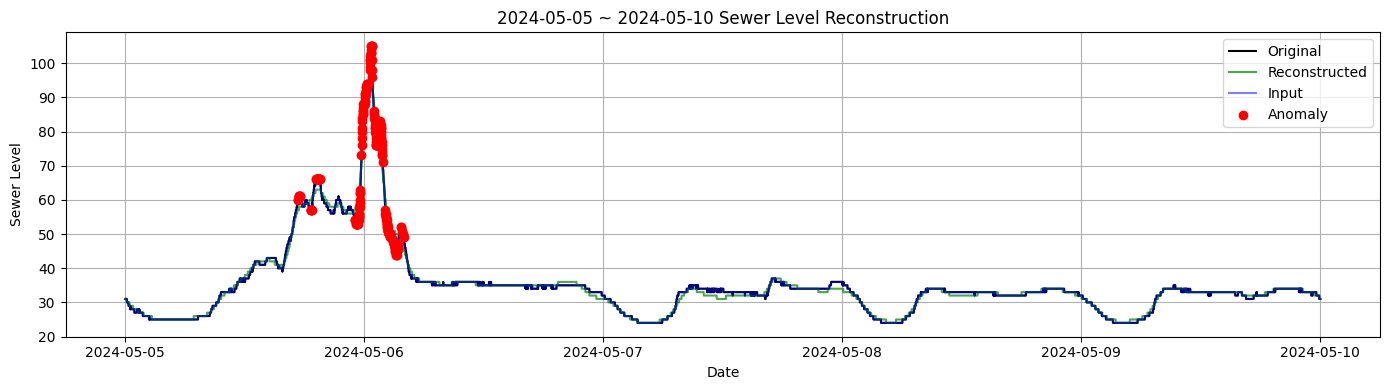

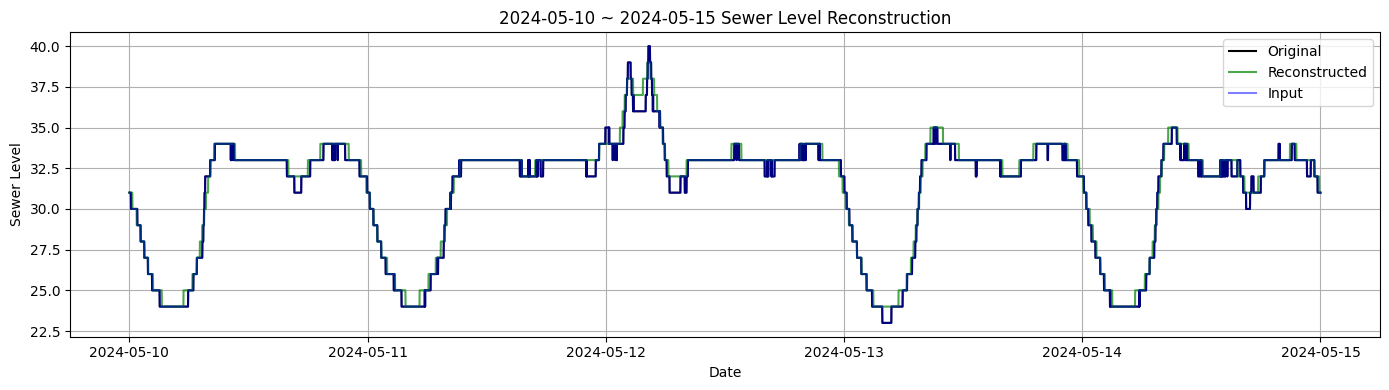

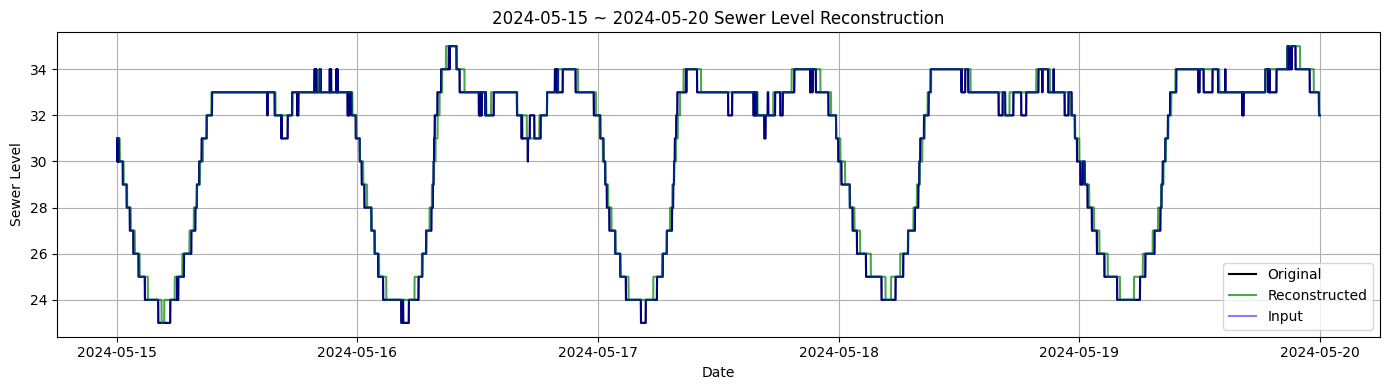

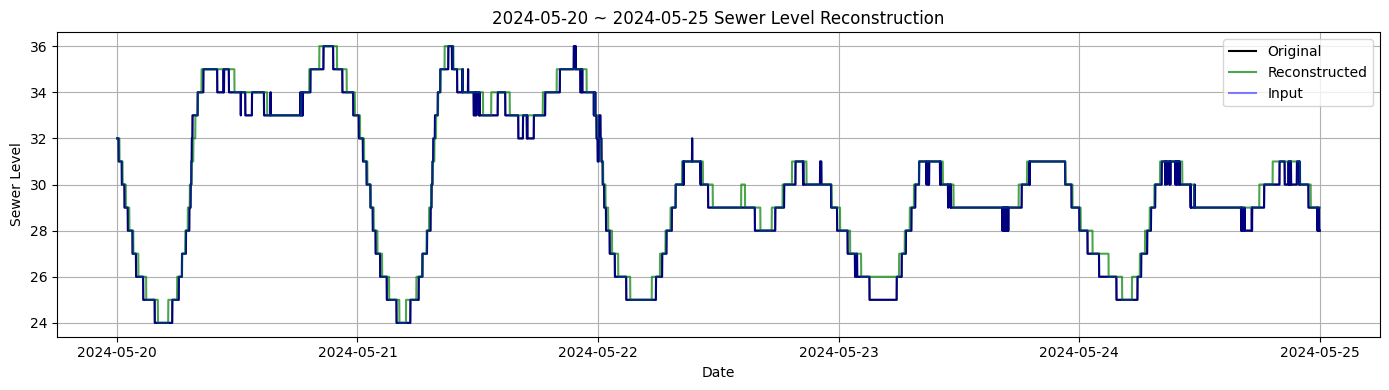

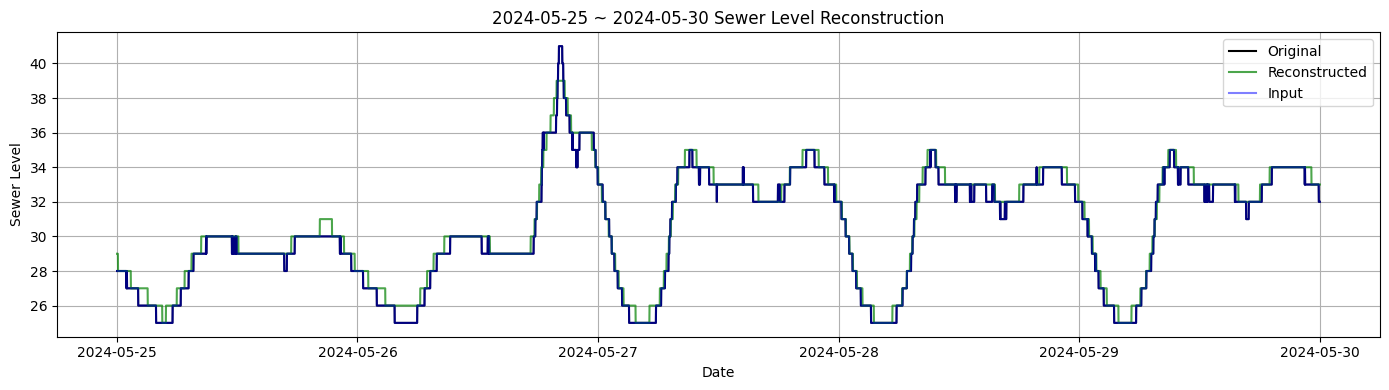

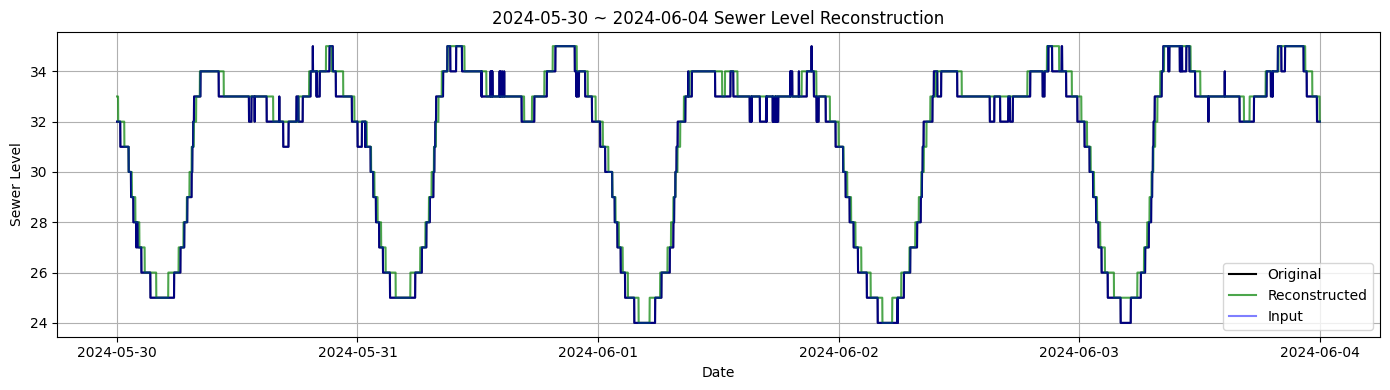

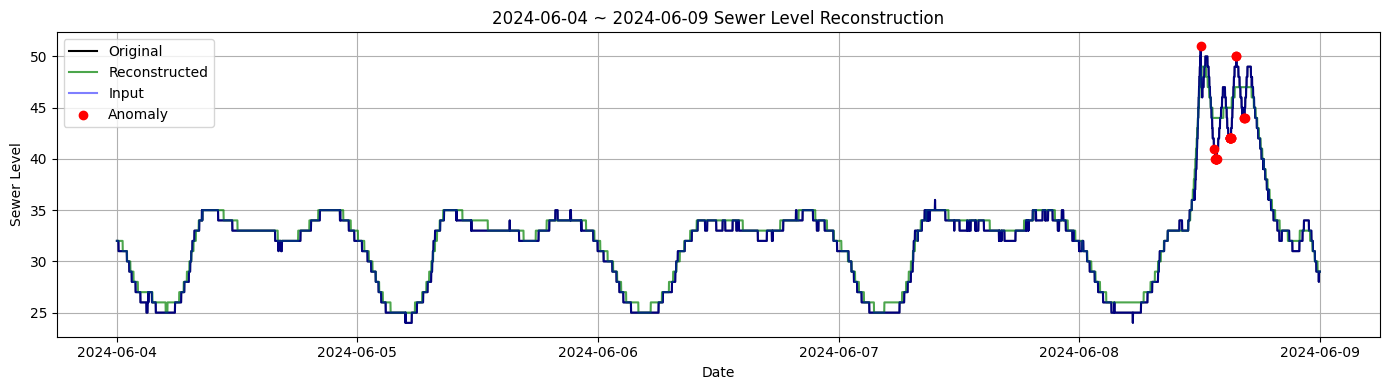

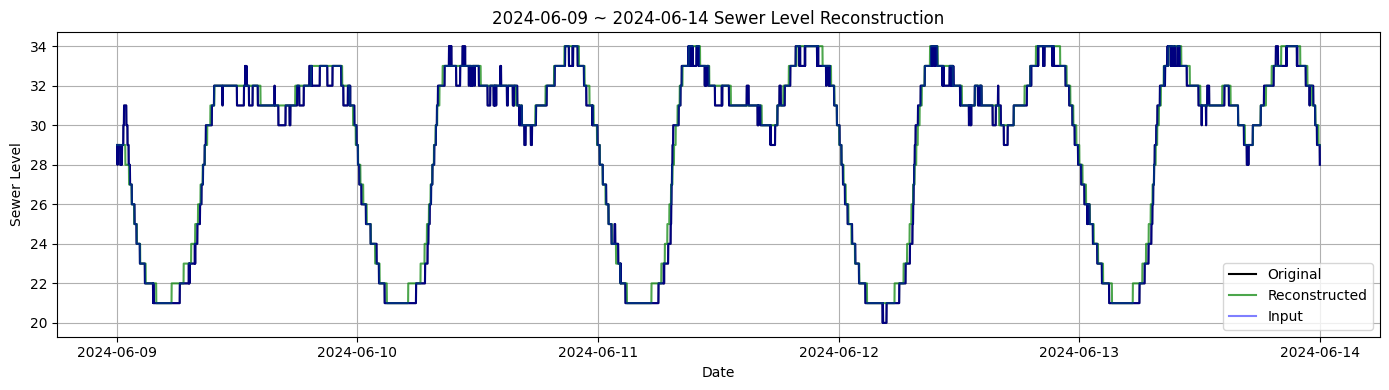

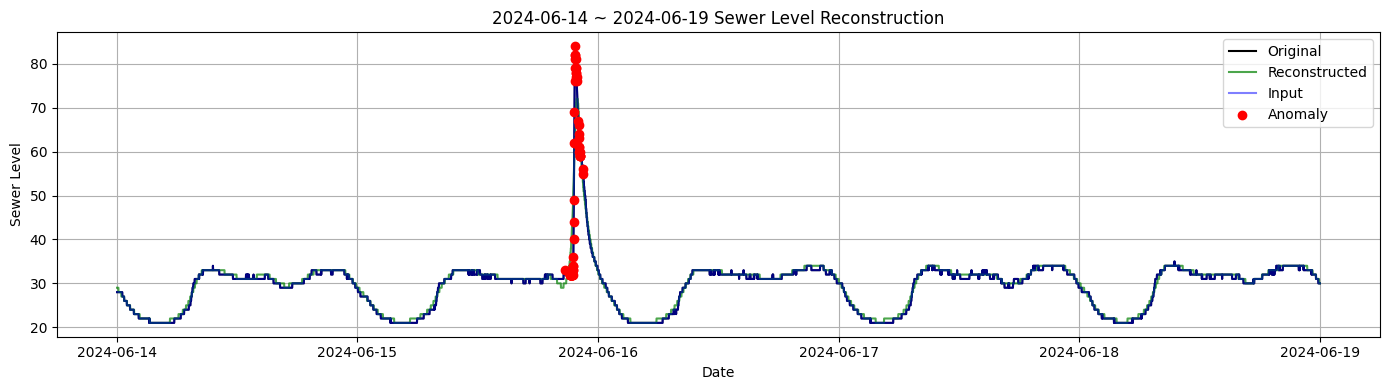

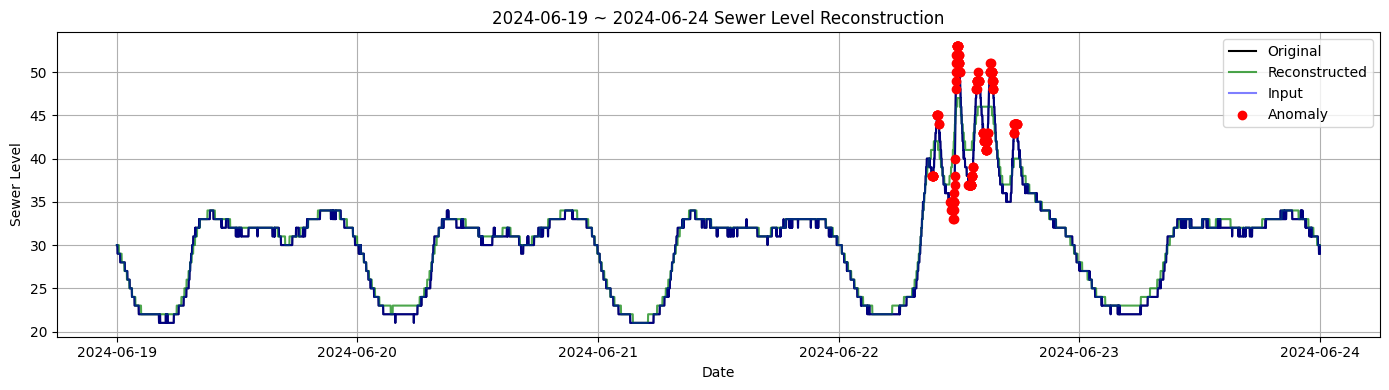

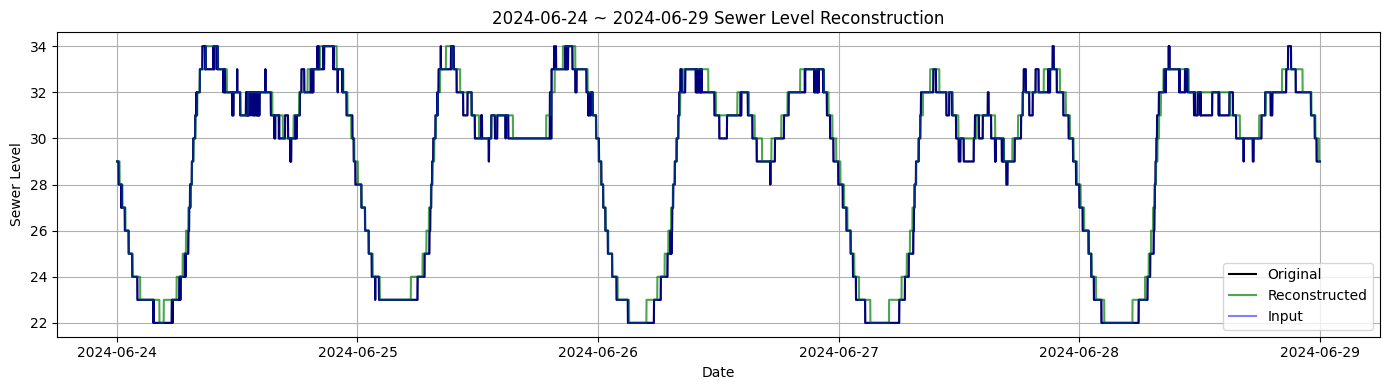

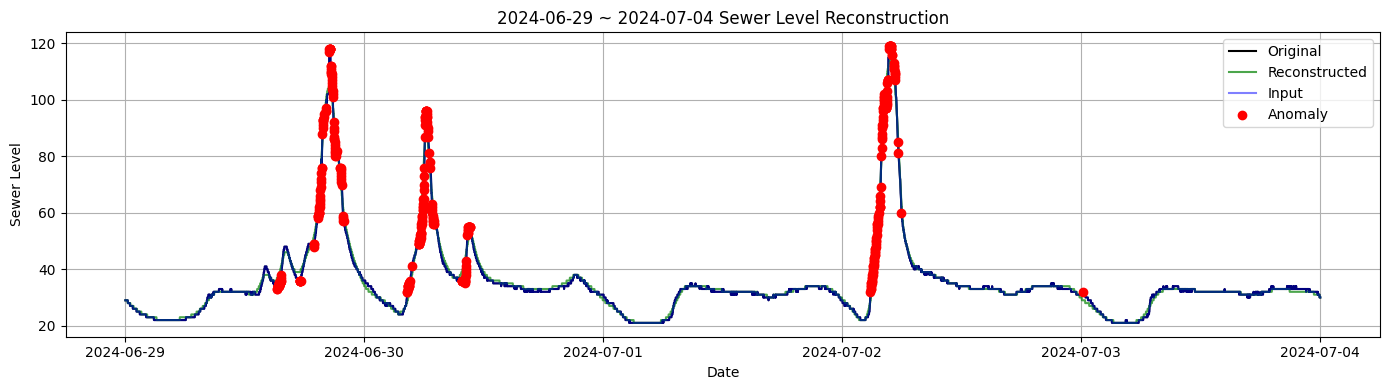

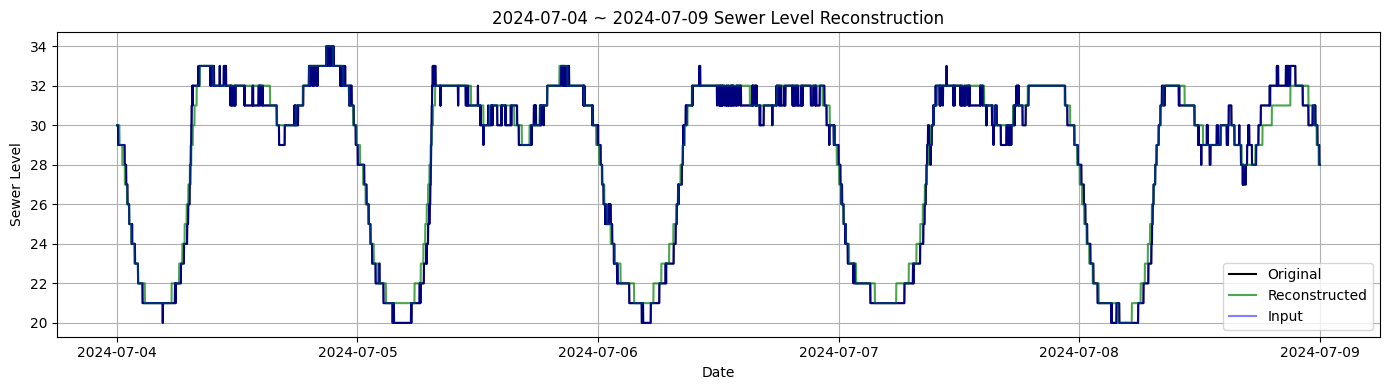

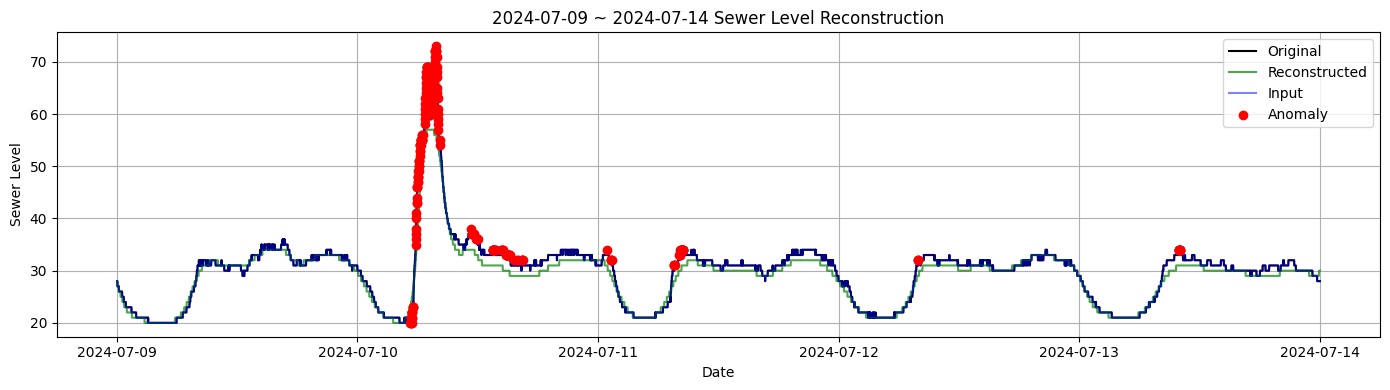

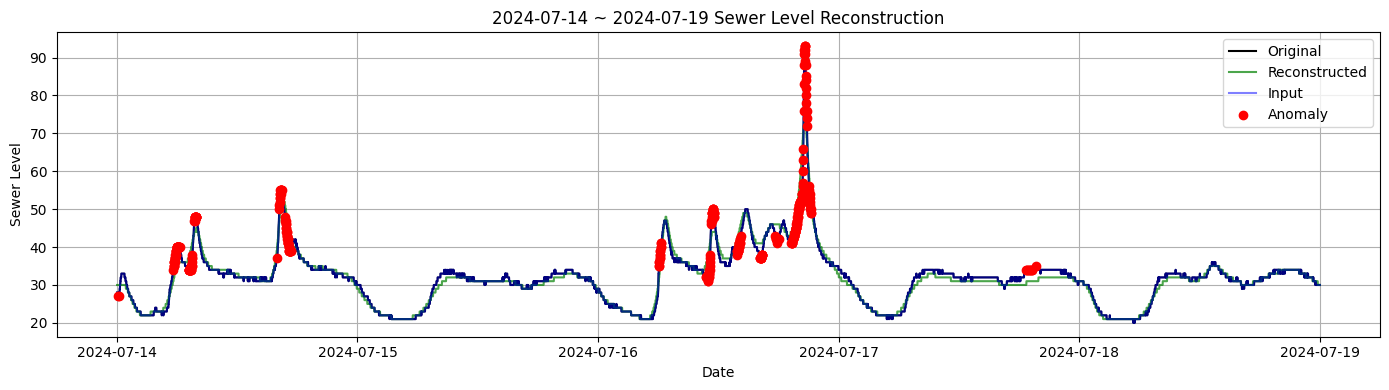

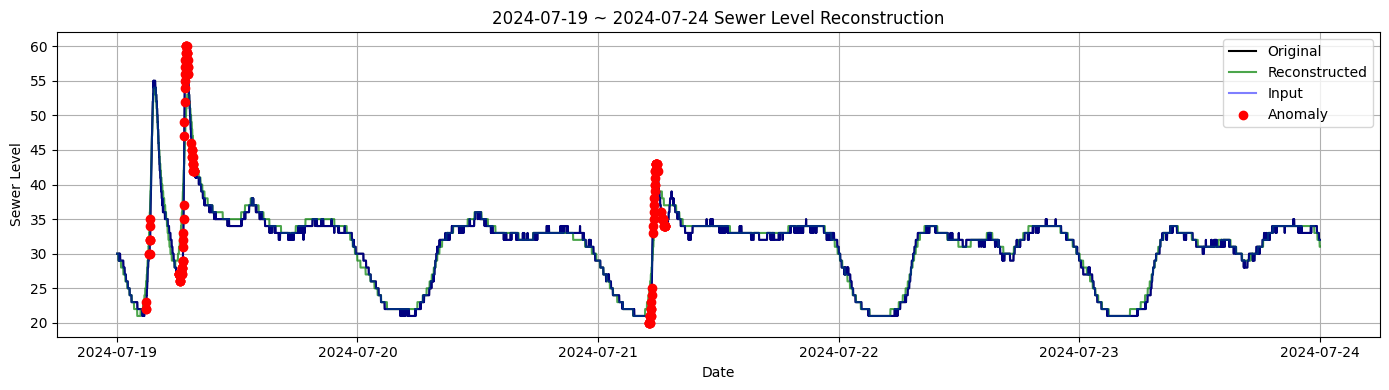

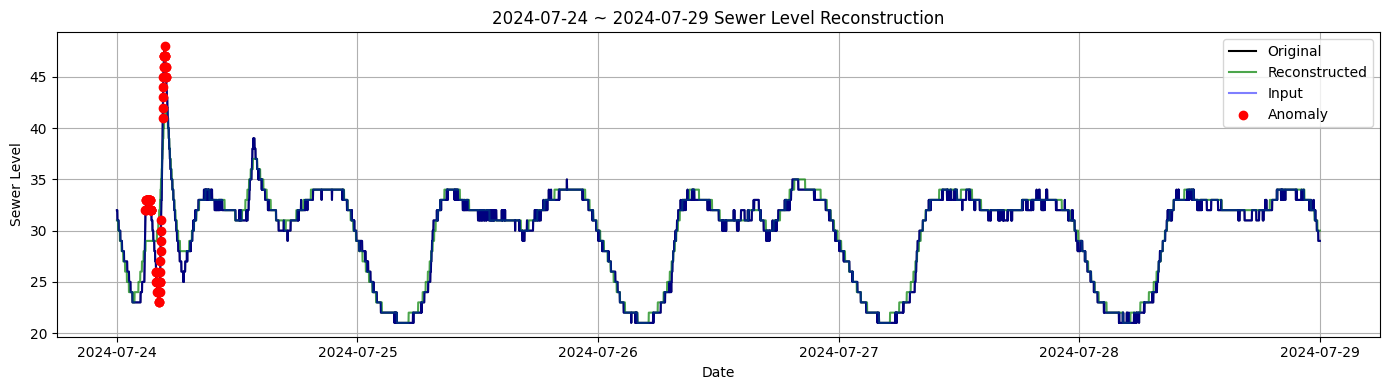

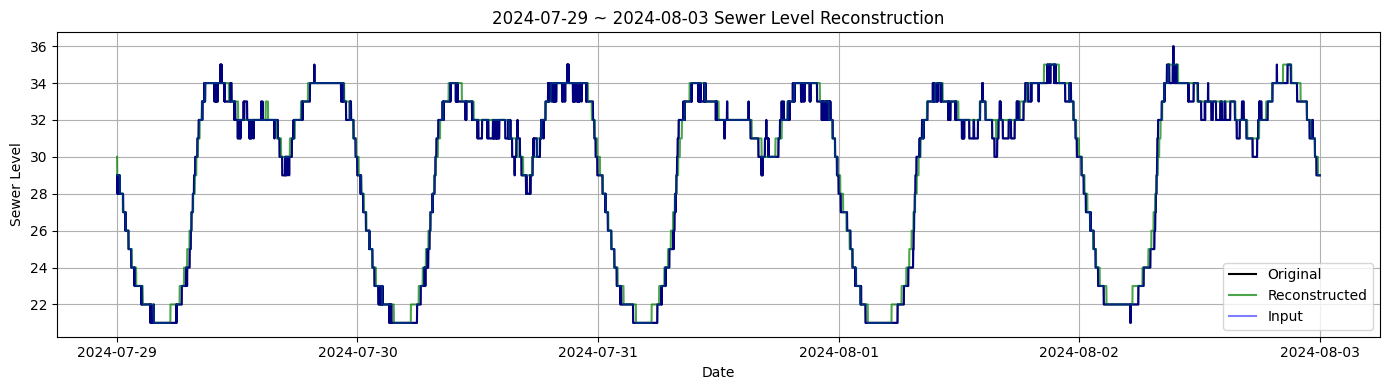

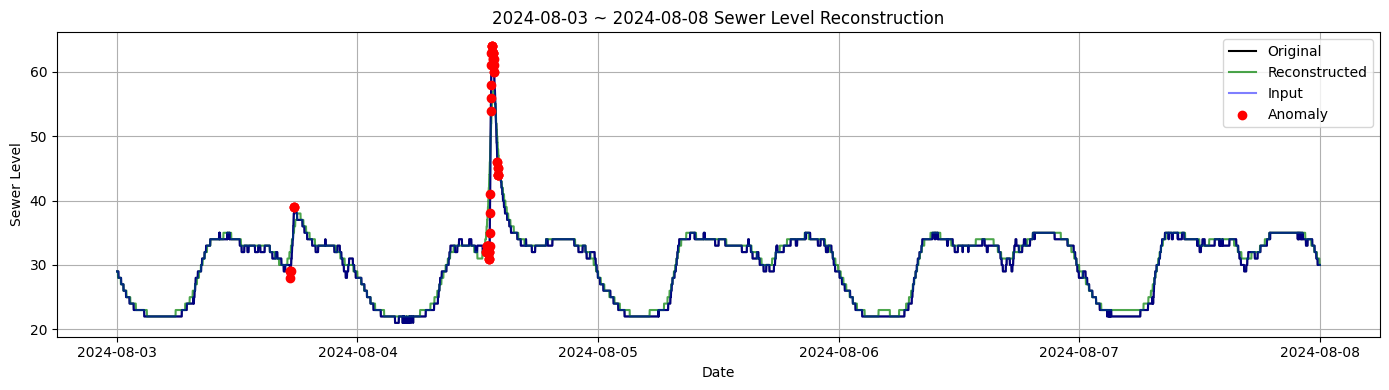

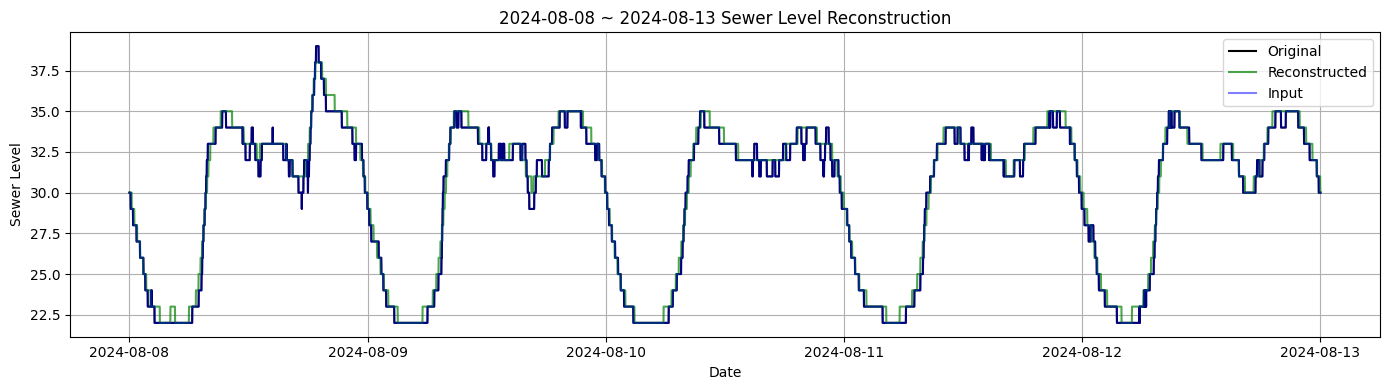

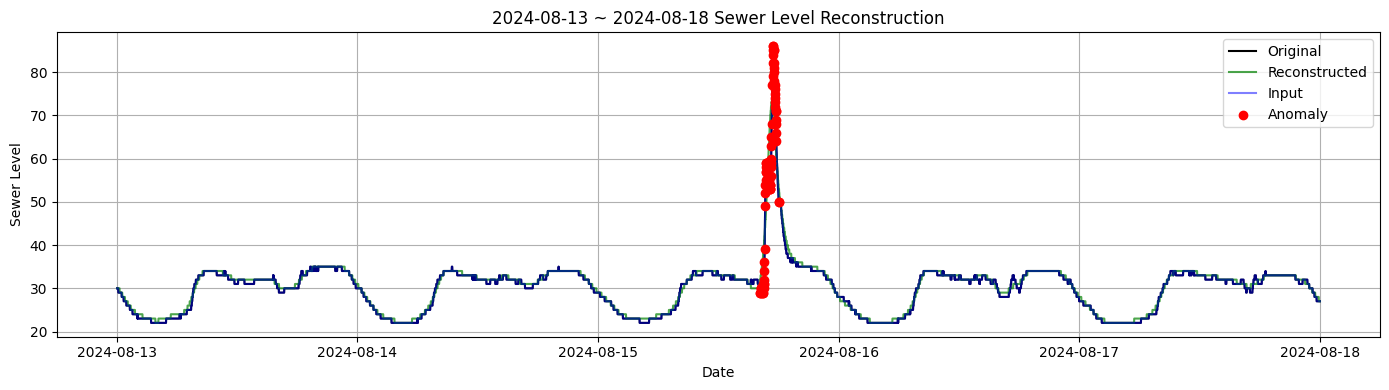

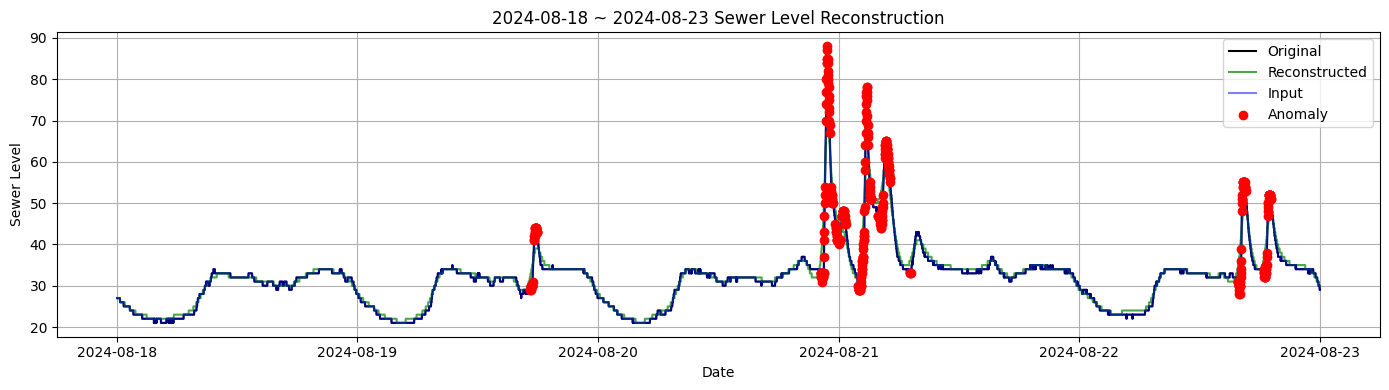

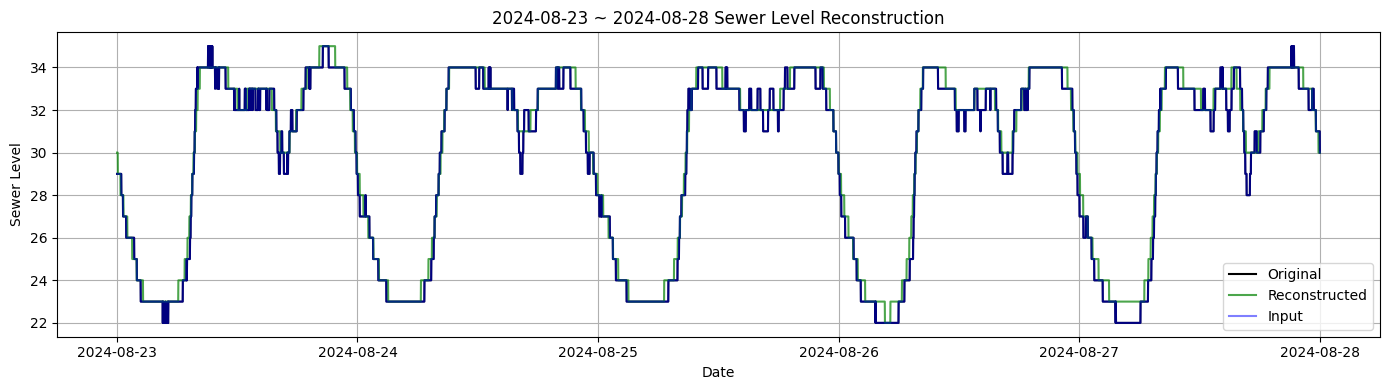

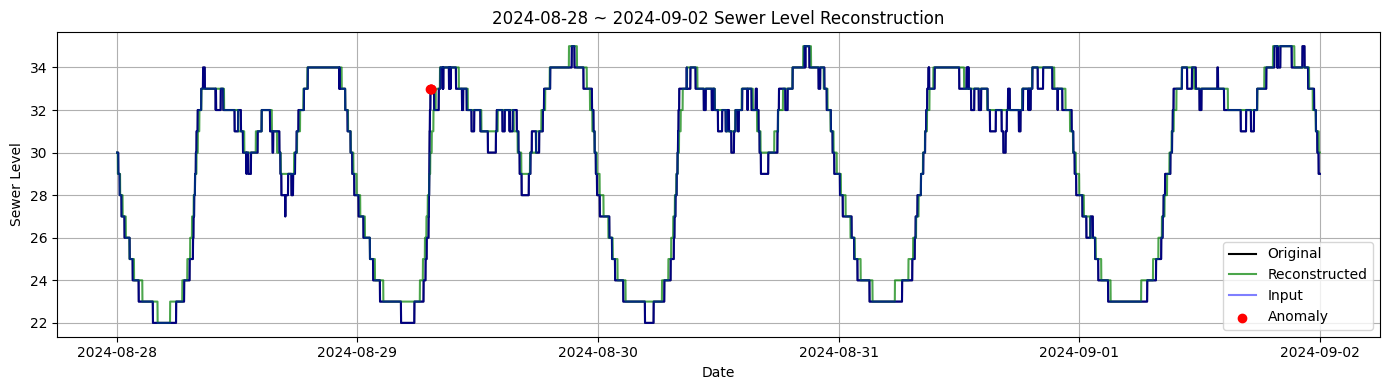

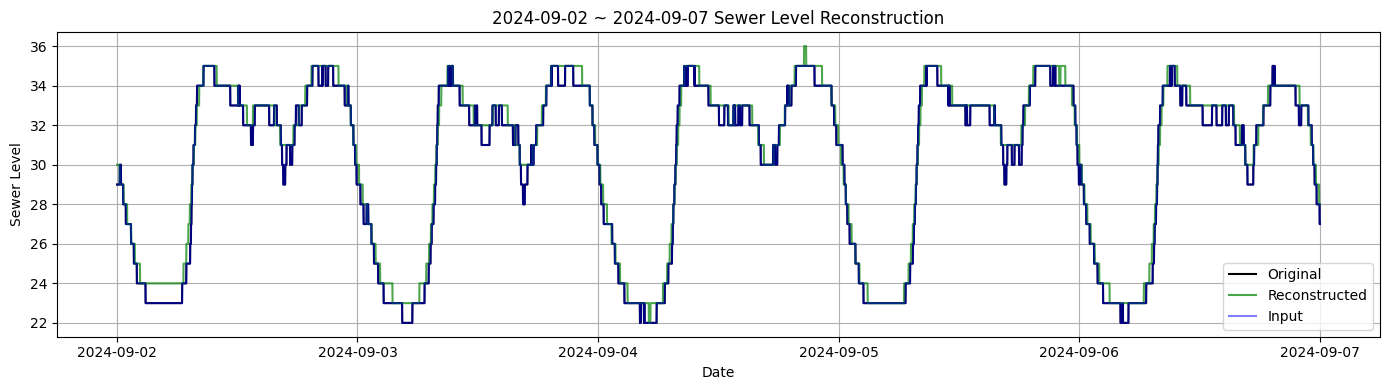

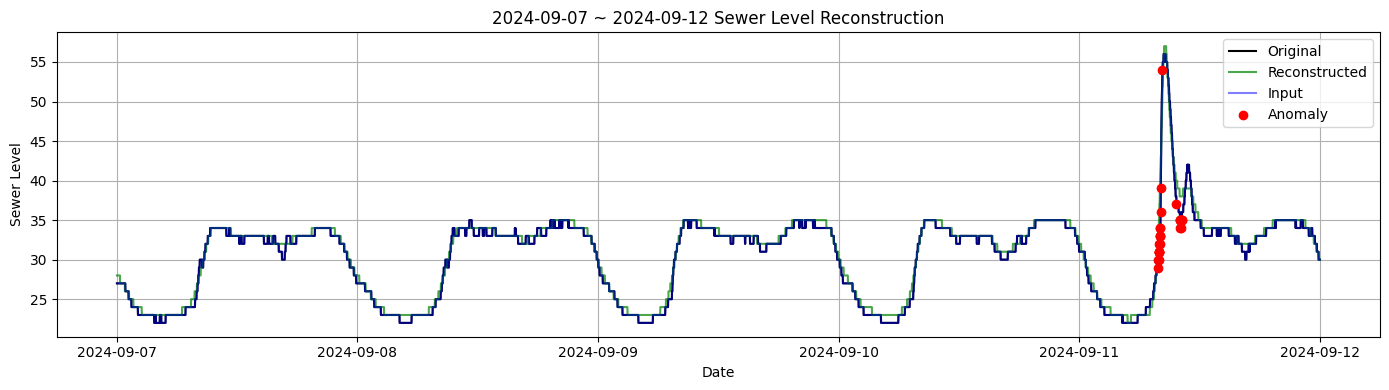

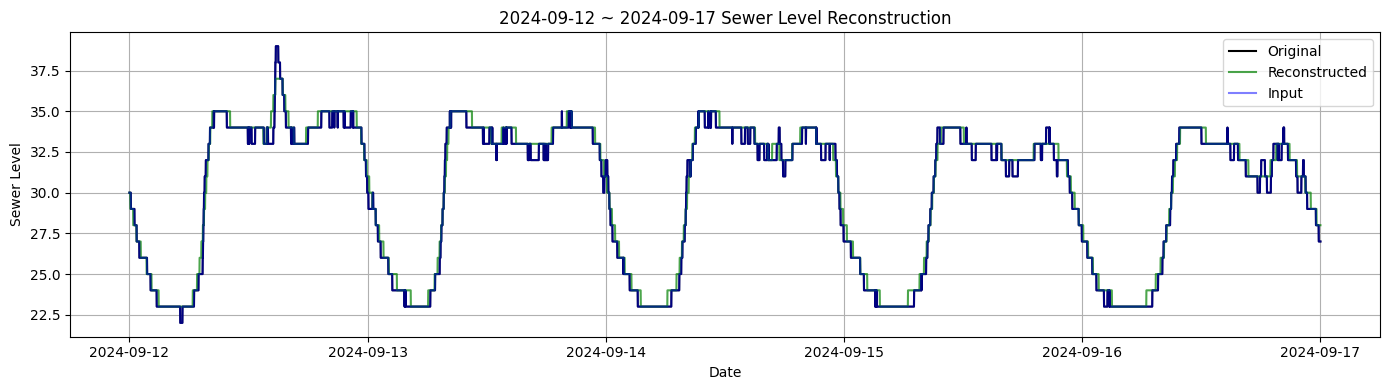

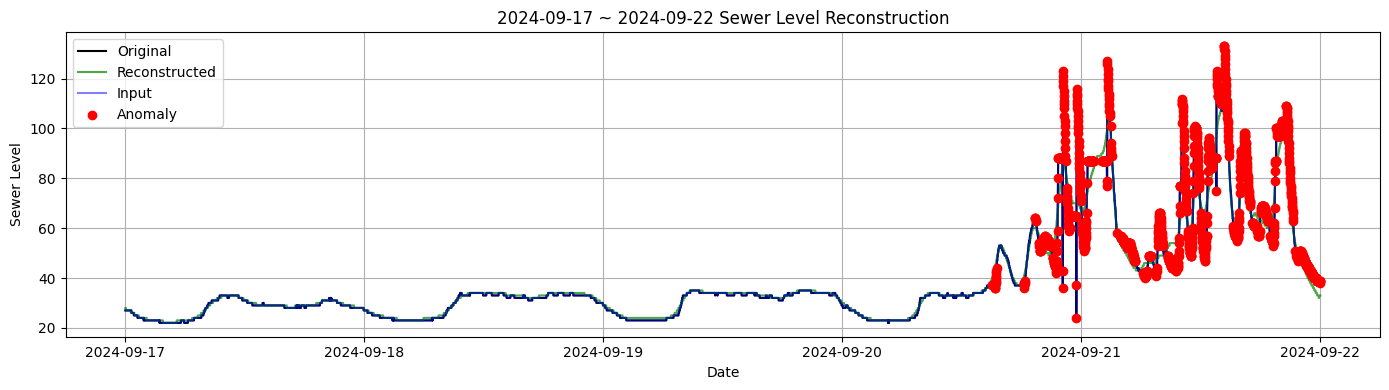

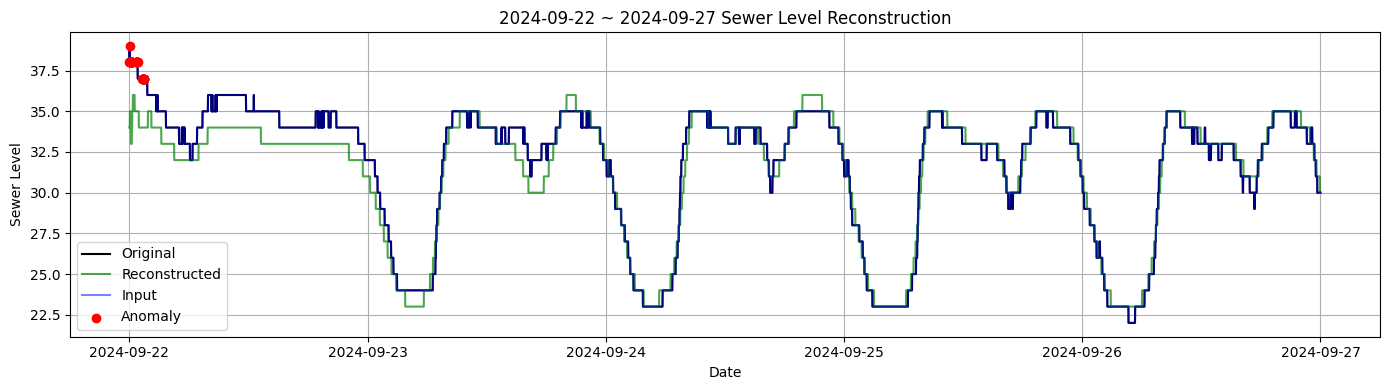

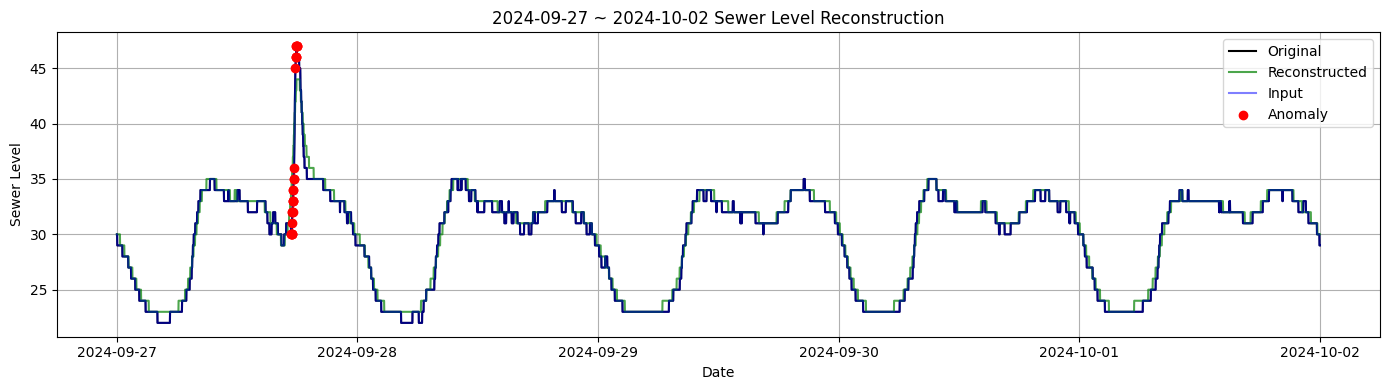

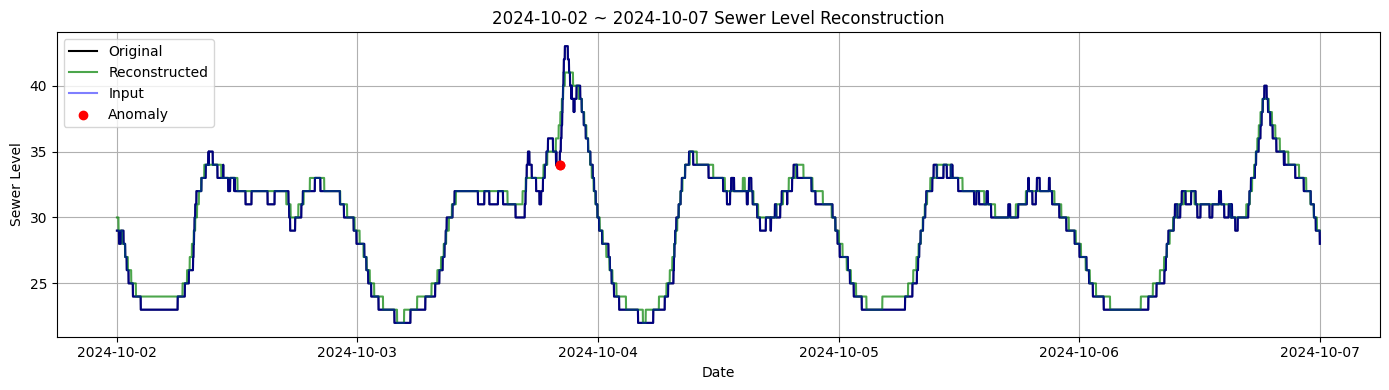

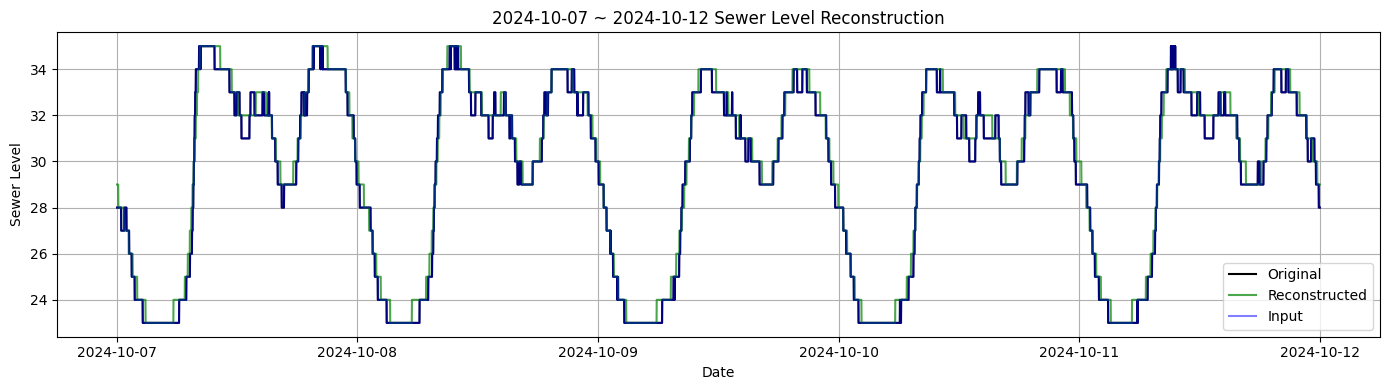

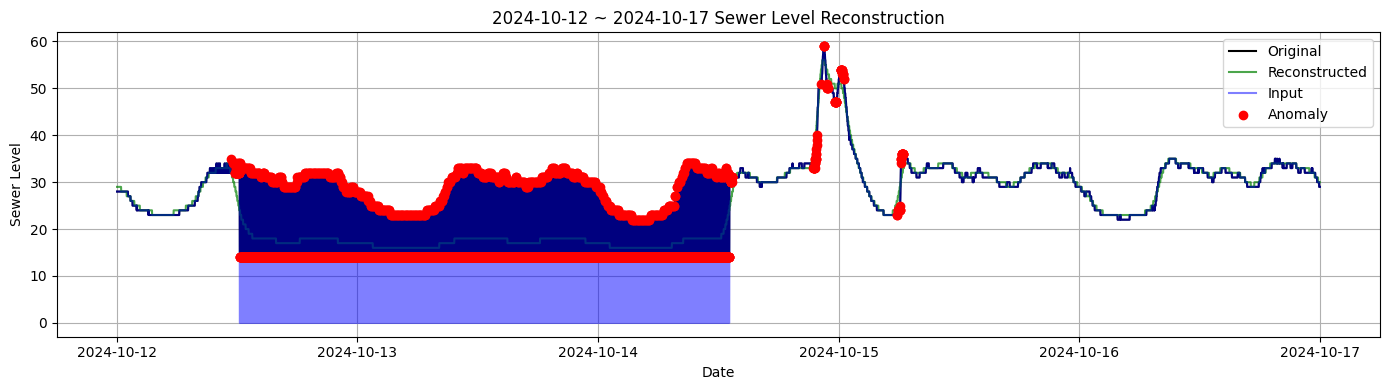

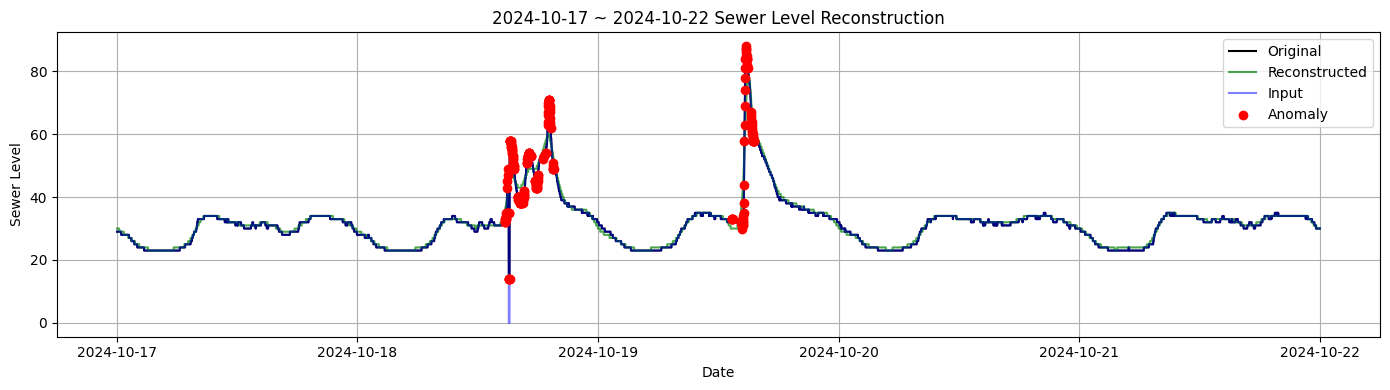

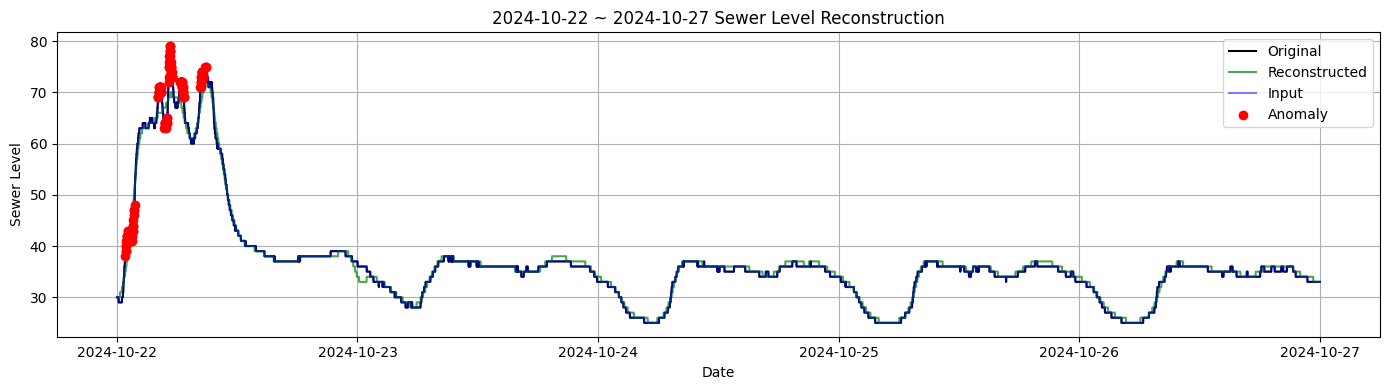

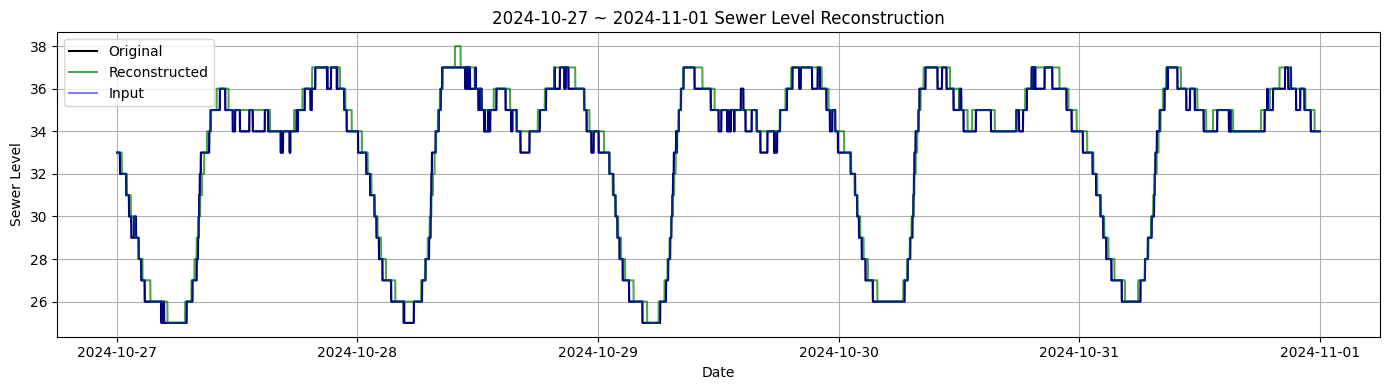

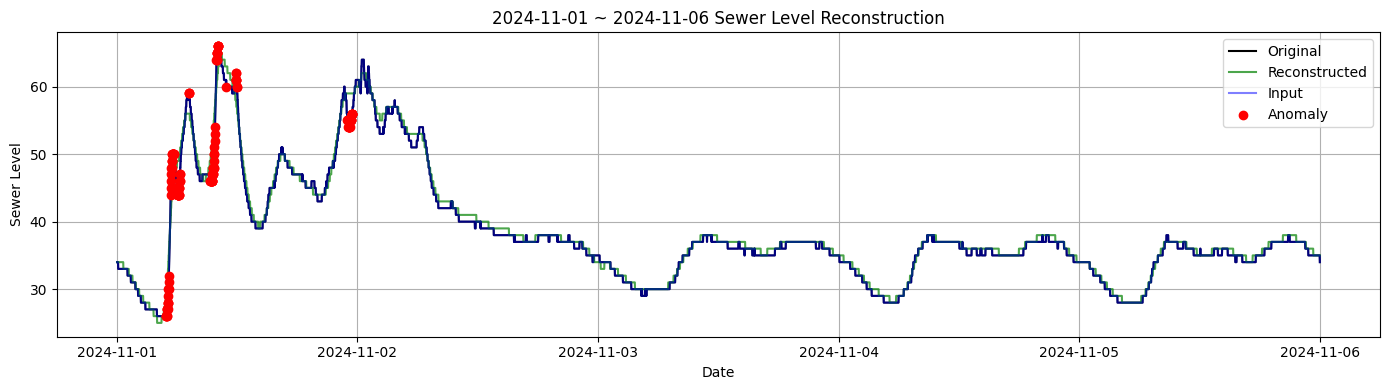

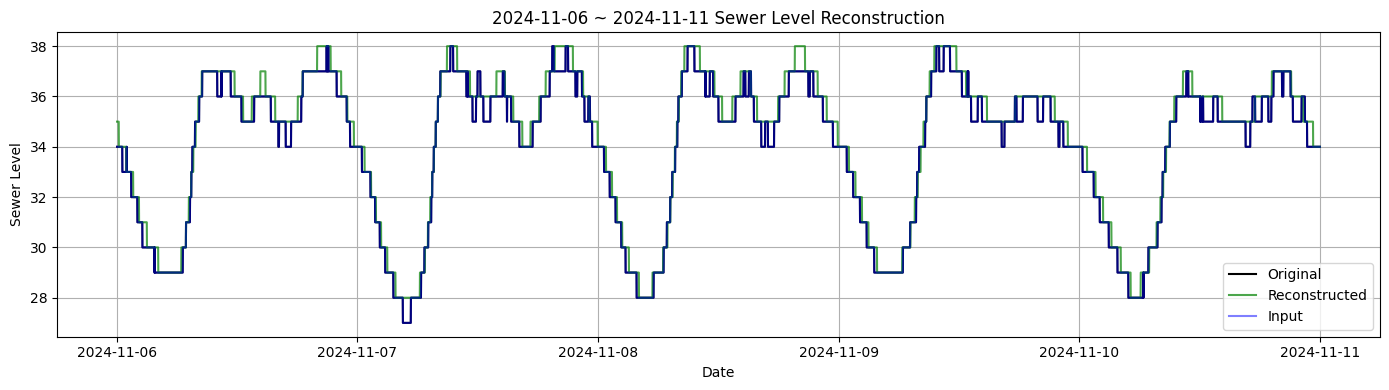

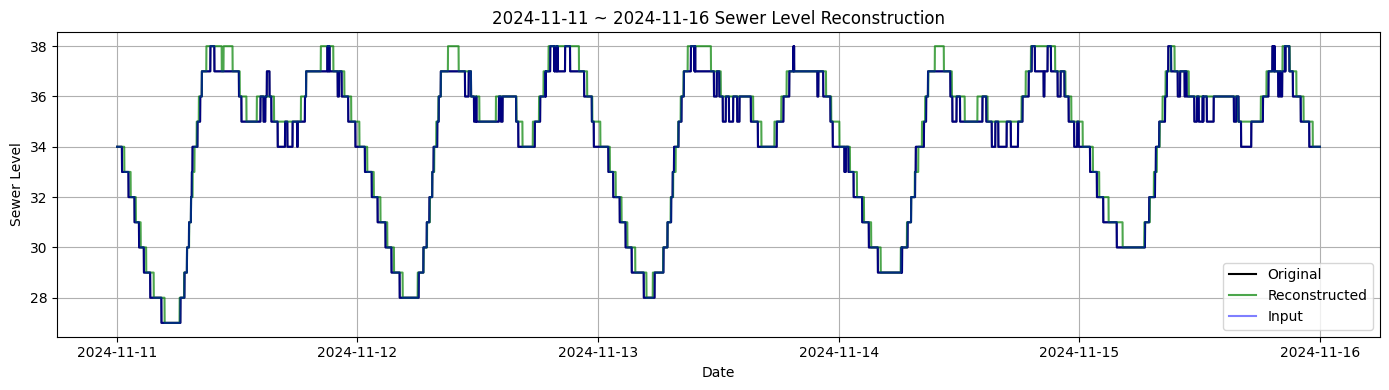

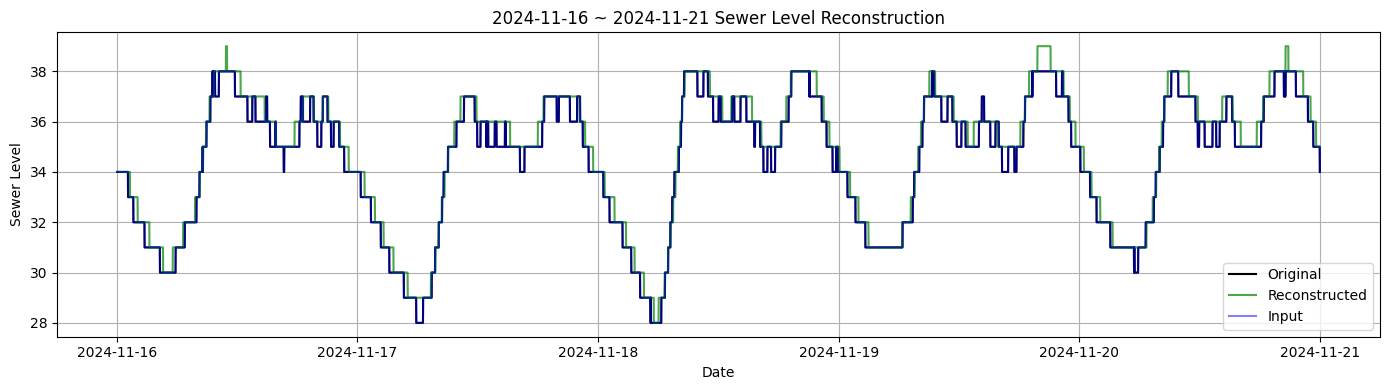

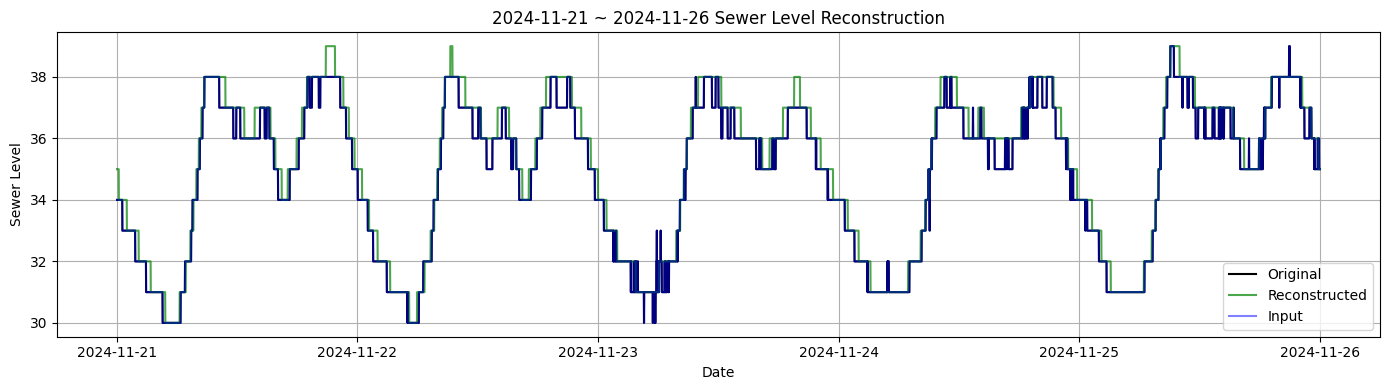

In [148]:
import matplotlib.dates as mdates
plot_decadal_timeseries_with_anomalies(
    tt=tt,
    original=original_norm_c, 
    predicted=corrected_norm_c, 
    input_data=input_seq_c,
    anomaly_flags=anomaly_flags_c,  
    # save_dir='./imgs/USAD_120_gc/changwon/',
    interval_days=5
)

## Gwangjoo anamaly statistics

In [104]:

summarize_pointwise_anomaly_statistics(point_errors_g, anomaly_flags_g)

📊 시점 단위 이상치 탐지 통계 요약
- 총 시점 수: 395999
- 이상치 시점 수: 4669
- 이상치 비율: 1.18%
- 이상치 평균 오차: 24.3098
- 정상값 평균 오차: 0.1511


## Changwon anamaly statistics

In [105]:

summarize_pointwise_anomaly_statistics(point_errors_c, anomaly_flags_c)

📊 시점 단위 이상치 탐지 통계 요약
- 총 시점 수: 395999
- 이상치 시점 수: 7920
- 이상치 비율: 2.00%
- 이상치 평균 오차: 53.9826
- 정상값 평균 오차: 0.3853
